# Exploratory Data Analysis: NYC Airbnb Listings for Neighborhood Recommendation

## 1. Introduction

This notebook details our Exploratory Data Analysis (EDA) of the `AB_NYC_2019.csv` dataset. Our primary objective for this project is to investigate how Airbnb can identify and recommend characteristically similar, yet less busy, `neighbourhoods` within the same `neighbourhood_group`, particularly when a user's initial area of interest faces constrained availability.

EDA is a critical first step, allowing us to immerse ourselves in the data, understand its structure, uncover initial patterns, and identify potential challenges or opportunities before developing any predictive models or recommendation logic (Tukey, 1977; Han, Pei and Tong, 2022).

Our guiding questions for this EDA were:
* What are the key characteristics of Airbnb listings in NYC in 2019 regarding price, room type, availability, review patterns, and host profiles?
* How can we define and quantify "busyness" for different `neighbourhoods` and `neighbourhood_group`s using the available data?
* What features best define the "character" of a `neighbourhood's` Airbnb offerings, which will allow us to determine similarity between them?
* Are there significant variations in these characteristics across different `neighbourhood_group`s and among `neighbourhoods` within the same `neighbourhood_group`?

This exploration will inform our feature engineering for creating `neighbourhood` profiles and guide the development of our K-Means clustering and K-Nearest Neighbors (KNN) based recommendation approach. We will document our findings, including data cleaning steps, visualizations, and interpretations for each stage of the EDA.

## 2. Data Loading and Initial Overview 

Our first step in the EDA process is to load the `AB_NYC_2019.csv` dataset and conduct an initial examination. This involves understanding the dataset's dimensions, the data types of each feature, and getting a first look at the data's content.

### 2.1. Load Data

In [44]:
import pandas as pd
import numpy as np
import os

df = pd.read_csv(os.path.join("..", "data", "AB_NYC_2019.csv"))
print("Dataset loaded. Shape:", df.shape)
df.head()

Dataset loaded. Shape: (48895, 16)


id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

## 3. Data Cleaning and Preprocessing

Before diving deep into feature exploration, we addressed data quality, focusing primarily on missing values. Accurate handling of missing data is crucial for reliable analysis (Han, Pei and Tong, 2022, Chapter 3).

### 3.1. Missing Value Analysis and Imputation

#### 3.1.1. Overall Missing Value Summary
*I began by identifying which columns contained missing values and the extent of this missingness.*

In [45]:
print("--- Overall Missing Value Counts ---")
missing_values_summary = df.isnull().sum()
print(missing_values_summary[missing_values_summary > 0])

--- Overall Missing Value Counts ---
name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64


*The summary highlighted `reviews_per_month` and `last_review` as having a significant number of missing entries (10,052 each). We also noted minor missing values in `name` (16) and `host_name` (21). Our next steps were to investigate the nature of these NaNs.*


#### 3.1.2. Analysis of Missing `reviews_per_month`

In [46]:
print("--- Analyzing Missing 'reviews_per_month' ---")
if 'reviews_per_month' in df.columns and 'number_of_reviews' in df.columns:
    total_nan_rpm = df['reviews_per_month'].isnull().sum()
    print(f"Total NaN values in 'reviews_per_month': {total_nan_rpm}")

    listings_with_zero_reviews = df[df['number_of_reviews'] == 0]
    print(f"Number of listings with 0 reviews: {len(listings_with_zero_reviews)}")

    nan_rpm_when_zero_reviews = 0
    if not listings_with_zero_reviews.empty:
        nan_rpm_when_zero_reviews = listings_with_zero_reviews['reviews_per_month'].isnull().sum()
    print(f"NaN in 'reviews_per_month' when 'number_of_reviews' is 0: {nan_rpm_when_zero_reviews}")

    if total_nan_rpm > 0 and total_nan_rpm == nan_rpm_when_zero_reviews and len(listings_with_zero_reviews) == total_nan_rpm:
        print("\nObservation: All NaN values in 'reviews_per_month' occur where 'number_of_reviews' is 0.")
        print("Interpretation: This is expected. If there are no reviews, 'reviews_per_month' cannot be calculated and is thus NaN.")
        print("Proposed Strategy for next step: Impute these NaNs with 0.")
    else:
        nan_rpm_with_reviews = df[(df['reviews_per_month'].isnull()) & (df['number_of_reviews'] > 0)]
        count_nan_rpm_with_reviews = len(nan_rpm_with_reviews)
        print(f"\nNumber of listings with 'reviews_per_month' = NaN BUT 'number_of_reviews' > 0: {count_nan_rpm_with_reviews}")
        if count_nan_rpm_with_reviews > 0:
            print("Observation: There are unexpected NaNs in 'reviews_per_month' for listings that DO have reviews. These need further investigation or a specific imputation strategy for them.")
        elif total_nan_rpm > 0 :
             print("\nObservation: 'reviews_per_month' has NaN values. The primary cause appears to be listings with 0 reviews.")
             print("Proposed Strategy for next step: For NaNs corresponding to 0 reviews, impute with 0. Investigate any other NaNs if present.")
        elif total_nan_rpm == 0:
            print("\nNo NaN values found in 'reviews_per_month'.")
        else:
            print("\nMixed observations about NaNs in 'reviews_per_month'. Review distribution carefully.")
else:
    print("Error: 'reviews_per_month' or 'number_of_reviews' column not found in DataFrame.")

--- Analyzing Missing 'reviews_per_month' ---
Total NaN values in 'reviews_per_month': 10052
Number of listings with 0 reviews: 10052
NaN in 'reviews_per_month' when 'number_of_reviews' is 0: 10052

Observation: All NaN values in 'reviews_per_month' occur where 'number_of_reviews' is 0.
Interpretation: This is expected. If there are no reviews, 'reviews_per_month' cannot be calculated and is thus NaN.
Proposed Strategy for next step: Impute these NaNs with 0.


*The analysis clearly showed that all 10,052 NaN values in `reviews_per_month` correspond directly to listings with zero `number_of_reviews`. This is an expected pattern: if a listing has no reviews, it logically has zero reviews per month. Based on this, we decided that imputing these NaN values with 0 is the most appropriate strategy.*


#### 3.1.3. Analysis of Missing `last_review`

In [47]:
print("\n--- Analyzing Missing 'last_review' ---")
if 'last_review' in df.columns and 'number_of_reviews' in df.columns:
    total_nan_last_review = df['last_review'].isnull().sum()
    print(f"Total NaN values in 'last_review': {total_nan_last_review}")

    nan_last_review_when_zero_reviews = 0
    listings_with_zero_reviews_for_last_review_check = df[df['number_of_reviews'] == 0]
    if not listings_with_zero_reviews_for_last_review_check.empty:
        nan_last_review_when_zero_reviews = listings_with_zero_reviews_for_last_review_check['last_review'].isnull().sum()
    print(f"NaN in 'last_review' when 'number_of_reviews' is 0: {nan_last_review_when_zero_reviews}")

    if total_nan_last_review > 0 and total_nan_last_review == nan_last_review_when_zero_reviews and len(listings_with_zero_reviews_for_last_review_check) == total_nan_last_review:
        print("\nObservation: All NaN values in 'last_review' occur where 'number_of_reviews' is 0.")
        print("Interpretation: This is expected. If there are no reviews, there is no 'last_review' date.")
        print("Proposed Strategy: These NaNs are informative. No direct imputation of the date is usually needed for these expected NaNs. If creating a 'days_since_last_review' feature, these would become NaN or a special large value.")
    else:
        nan_last_review_with_reviews = df[(df['last_review'].isnull()) & (df['number_of_reviews'] > 0)]
        count_nan_last_review_with_reviews = len(nan_last_review_with_reviews)
        print(f"\nNumber of listings with 'last_review' = NaN BUT 'number_of_reviews' > 0: {count_nan_last_review_with_reviews}")
        if count_nan_last_review_with_reviews > 0:
            print("Observation: There are unexpected NaNs in 'last_review' for listings that DO have reviews. These require investigation.")
        elif total_nan_last_review > 0:
            print("\nObservation: 'last_review' has NaN values. The primary cause appears to be listings with 0 reviews.")
        elif total_nan_last_review == 0:
            print("\nNo NaN values found in 'last_review'.")
        else:
            print("\nMixed observations about NaNs in 'last_review'. Review distribution carefully.")
else:
    print("Error: 'last_review' or 'number_of_reviews' column not found in DataFrame.")


--- Analyzing Missing 'last_review' ---
Total NaN values in 'last_review': 10052
NaN in 'last_review' when 'number_of_reviews' is 0: 10052

Observation: All NaN values in 'last_review' occur where 'number_of_reviews' is 0.
Interpretation: This is expected. If there are no reviews, there is no 'last_review' date.
Proposed Strategy: These NaNs are informative. No direct imputation of the date is usually needed for these expected NaNs. If creating a 'days_since_last_review' feature, these would become NaN or a special large value.


*Similar to `reviews_per_month`, our investigation confirmed that all 10,052 NaNs in `last_review` are associated with listings that have zero `number_of_reviews`. This means these listings genuinely lack a "last review date." We concluded that these NaNs are informative and should not be imputed with an artificial date. They will be naturally handled or noted in any subsequent analysis that might use this feature, such as calculating review recency.*

#### 3.1.4. Analysis of Minor Missing Values (`name`, `host_name`)

In [48]:
print("\n--- Analyzing Other Minor Missing Values ('name', 'host_name') ---")
minor_missing_cols_info = []

if 'name' in df.columns:
    missing_name_count = df['name'].isnull().sum()
    if missing_name_count > 0:
        print(f"Missing values in 'name': {missing_name_count} ({(missing_name_count/len(df)*100):.2f}%)")
        minor_missing_cols_info.append("'name'")
    else:
        print("No missing values in 'name'.")
else:
    print("Column 'name' not found.")

if 'host_name' in df.columns:
    missing_host_name_count = df['host_name'].isnull().sum()
    if missing_host_name_count > 0:
        print(f"Missing values in 'host_name': {missing_host_name_count} ({(missing_host_name_count/len(df)*100):.2f}%)")
        minor_missing_cols_info.append("'host_name'")
    else:
        print("No missing values in 'host_name'.")
else:
    print("Column 'host_name' not found.")

if minor_missing_cols_info:
    print(f"\nObservation: Columns {', '.join(minor_missing_cols_info)} have a very small number of missing values.")
    print("Proposed Strategy for next steps: Impute with a placeholder like 'Unknown' or 'Not Specified'.")


--- Analyzing Other Minor Missing Values ('name', 'host_name') ---
Missing values in 'name': 16 (0.03%)
Missing values in 'host_name': 21 (0.04%)

Observation: Columns 'name', 'host_name' have a very small number of missing values.
Proposed Strategy for next steps: Impute with a placeholder like 'Unknown' or 'Not Specified'.


*The `name` and `host_name` columns have a very small number of missing values (16 and 21, respectively). Given their textual nature and the low percentage of missingness, we opted to impute these with the placeholder string "Unknown" to maintain dataset integrity for any potential descriptive use.*

#### 3.1.5. Performing Imputations
*Based on the analysis above, I proceeded with the chosen imputation strategies.*

In [49]:
print("\n--- Imputing 'reviews_per_month' ---")
if 'reviews_per_month' in df.columns:
    print(f"Missing 'reviews_per_month' before imputation: {df['reviews_per_month'].isnull().sum()}")
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0) # Recommended change
    print(f"Missing 'reviews_per_month' after imputation with 0: {df['reviews_per_month'].isnull().sum()}")
    print("\nSample of 'number_of_reviews' and 'reviews_per_month' after imputation:")
    listings_with_zero_reviews = df[df['number_of_reviews'] == 0]
    print(listings_with_zero_reviews[['number_of_reviews', 'reviews_per_month']].head())
else:
    print("Error: 'reviews_per_month' column not found for imputation.")


--- Imputing 'reviews_per_month' ---
Missing 'reviews_per_month' before imputation: 10052
Missing 'reviews_per_month' after imputation with 0: 0

Sample of 'number_of_reviews' and 'reviews_per_month' after imputation:
    number_of_reviews  reviews_per_month
2                   0                0.0
19                  0                0.0
26                  0                0.0
36                  0                0.0
38                  0                0.0


In [50]:
print("\n--- Imputing 'name' ---")
if 'name' in df.columns:
    print(f"Missing 'name' before imputation: {df['name'].isnull().sum()}")
    df['name'] = df['name'].fillna('Unknown') # Recommended change
    print(f"Missing 'name' after imputation with 'Unknown': {df['name'].isnull().sum()}")
else:
    print("Error: 'name' column not found for imputation.")


--- Imputing 'name' ---
Missing 'name' before imputation: 16
Missing 'name' after imputation with 'Unknown': 0


In [51]:
print("\n--- Imputing 'host_name' ---")
if 'host_name' in df.columns:
    print(f"Missing 'host_name' before imputation: {df['host_name'].isnull().sum()}")
    df['host_name'] = df['host_name'].fillna('Unknown') # Recommended change
    print(f"Missing 'host_name' after imputation with 'Unknown': {df['host_name'].isnull().sum()}")
else:
    print("Error: 'host_name' column not found for imputation.")


--- Imputing 'host_name' ---
Missing 'host_name' before imputation: 21
Missing 'host_name' after imputation with 'Unknown': 0


#### 3.1.6. Final Check of Missing Values

In [52]:
print("\n--- Final Check of Missing Values After Imputations ---")
if not df.empty:
    final_missing_summary = df.isnull().sum()
    missing_after_imputation = final_missing_summary[final_missing_summary > 0]
    if missing_after_imputation.empty:
        print("No more missing values in 'name', 'host_name', 'reviews_per_month'.")
    else:
        print("Remaining missing values:")
        print(missing_after_imputation)
        if 'last_review' in missing_after_imputation.index:
            print("Note: 'last_review' will still show NaNs if listings had 0 reviews, which is expected and typically not imputed with a date.")
else:
    print("DataFrame 'df' is not loaded. Cannot perform final check.")


--- Final Check of Missing Values After Imputations ---
Remaining missing values:
last_review    10052
dtype: int64
Note: 'last_review' will still show NaNs if listings had 0 reviews, which is expected and typically not imputed with a date.


*Our final check confirmed that imputations for `reviews_per_month`, `name`, and `host_name` were successful, with these columns now showing zero missing values. As intended, `last_review` still contains NaNs for listings without review history.*

## 4. Exploratory Data Analysis: Key Feature Deep Dive

With the data cleaned, I proceed to a detailed exploration of individual features and their interrelationships. This stage is vital for understanding the underlying patterns that will inform our definitions of "busyness" and neighborhood "similarity." Our approach emphasizes visualization to uncover insights (Tukey, 1977; Wickham and Grolemund, 2017).

### 4.1. Understanding "Busyness" and Demand Indicators
*To address our research question, I first needed to explore various indicators that could help us quantify the "busyness" or demand associated with different `neighbourhoods` and `neighbourhood_group`s. We focused on `availability_365`, review metrics (`number_of_reviews`, `reviews_per_month`), and listing density.*

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_palette("viridis")

--- Availability Analysis: Overall Distribution of availability_365 ---


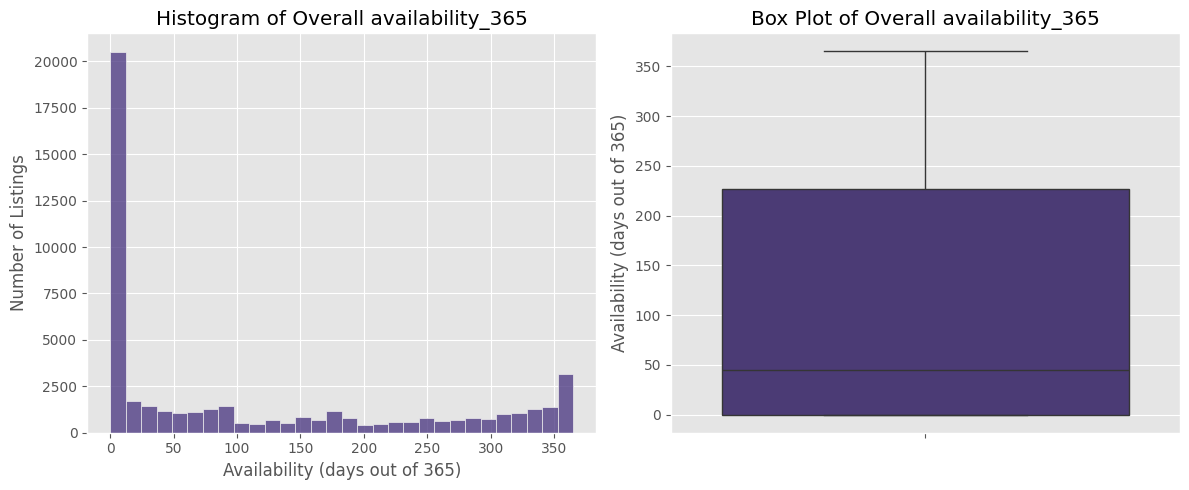


Description of availability_365:
count    48895.000000
mean       112.781327
std        131.622289
min          0.000000
25%          0.000000
50%         45.000000
75%        227.000000
max        365.000000
Name: availability_365, dtype: float64

Number of listings with 0 availability: 17533


In [54]:
print("--- Availability Analysis: Overall Distribution of availability_365 ---")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['availability_365'], bins=30, kde=False)
plt.title('Histogram of Overall availability_365')
plt.xlabel('Availability (days out of 365)')
plt.ylabel('Number of Listings')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['availability_365'])
plt.title('Box Plot of Overall availability_365')
plt.ylabel('Availability (days out of 365)')

plt.tight_layout()
plt.show()

print("\nDescription of availability_365:")
print(df['availability_365'].describe())
# Listings with 0 availability might be interesting to investigate separately
print(f"\nNumber of listings with 0 availability: {len(df[df['availability_365'] == 0])}")


--- Availability Analysis: Per neighbourhood_group and neighbourhood ---

Average availability_365 per neighbourhood_group (Sorted by least available):
neighbourhood_group
Brooklyn         100.232292
Manhattan        111.979410
Queens           144.451818
Bronx            165.758937
Staten Island    199.678284
Name: availability_365, dtype: float64


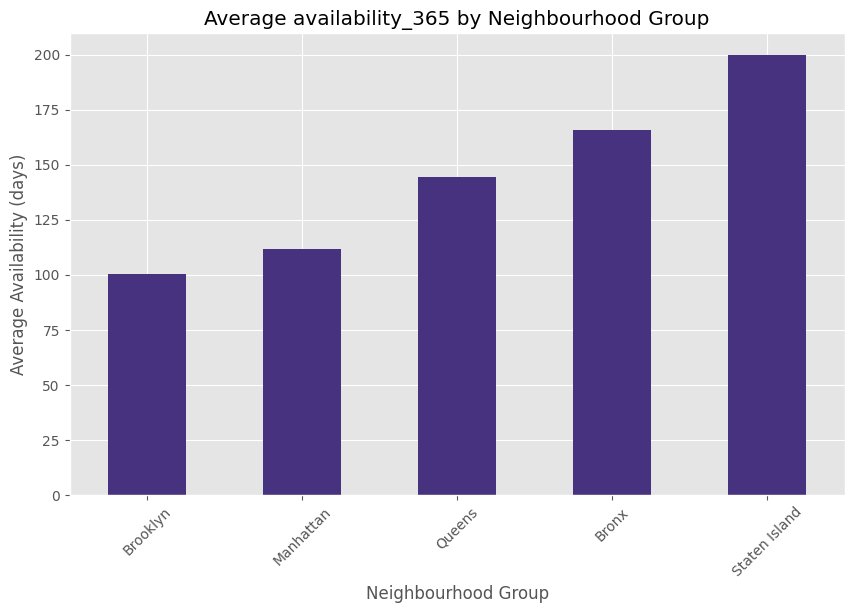

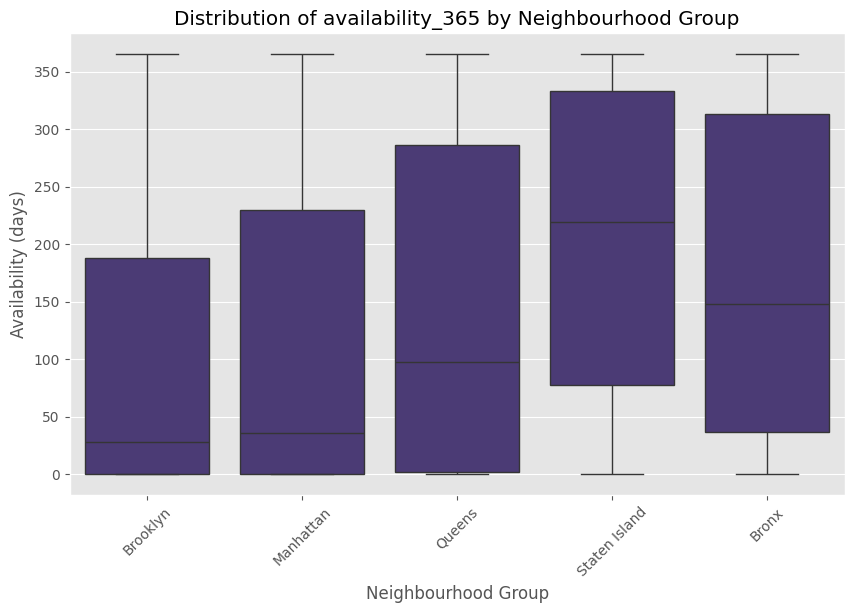


Top 10 Neighbourhoods with Lowest Average availability_365:
neighbourhood
Bay Terrace, Staten Island     0.000000
New Dorp                       0.000000
Woodrow                        0.000000
Downtown Brooklyn             39.481928
Morningside Heights           43.054913
Navy Yard                     48.928571
Rossville                     59.000000
Cobble Hill                   63.212121
Stuyvesant Town               65.108108
New Springville               65.250000
Name: availability_365, dtype: float64

Top 10 Neighbourhoods with Highest Average availability_365:
neighbourhood
Spuyten Duyvil    270.000000
West Brighton     274.722222
Randall Manor     275.210526
Edgemere          275.272727
Mill Basin        290.000000
Richmondtown      300.000000
Eastchester       333.461538
Willowbrook       351.000000
Co-op City        364.000000
Fort Wadsworth    365.000000
Name: availability_365, dtype: float64


In [55]:
print("\n--- Availability Analysis: Per neighbourhood_group and neighbourhood ---")

# Average availability per neighbourhood_group
avg_availability_group = df.groupby('neighbourhood_group')['availability_365'].mean().sort_values(ascending=True)
print("\nAverage availability_365 per neighbourhood_group (Sorted by least available):")
print(avg_availability_group)

plt.figure(figsize=(10, 6))
avg_availability_group.plot(kind='bar')
plt.title('Average availability_365 by Neighbourhood Group')
plt.ylabel('Average Availability (days)')
plt.xlabel('Neighbourhood Group')
plt.xticks(rotation=45)
plt.show()

# Box plot of availability_365 by neighbourhood_group
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbourhood_group', y='availability_365', data=df)
plt.title('Distribution of availability_365 by Neighbourhood Group')
plt.ylabel('Availability (days)')
plt.xlabel('Neighbourhood Group')
plt.xticks(rotation=45)
plt.show()

# Top 10 neighbourhoods with lowest average availability (potentially "busiest" by this metric)
avg_availability_neighbourhood = df.groupby('neighbourhood')['availability_365'].mean().sort_values(ascending=True)
print("\nTop 10 Neighbourhoods with Lowest Average availability_365:")
print(avg_availability_neighbourhood.head(10))

# Top 10 neighbourhoods with highest average availability
print("\nTop 10 Neighbourhoods with Highest Average availability_365:")
print(avg_availability_neighbourhood.tail(10))


--- Review Metrics: Overall Distribution ---


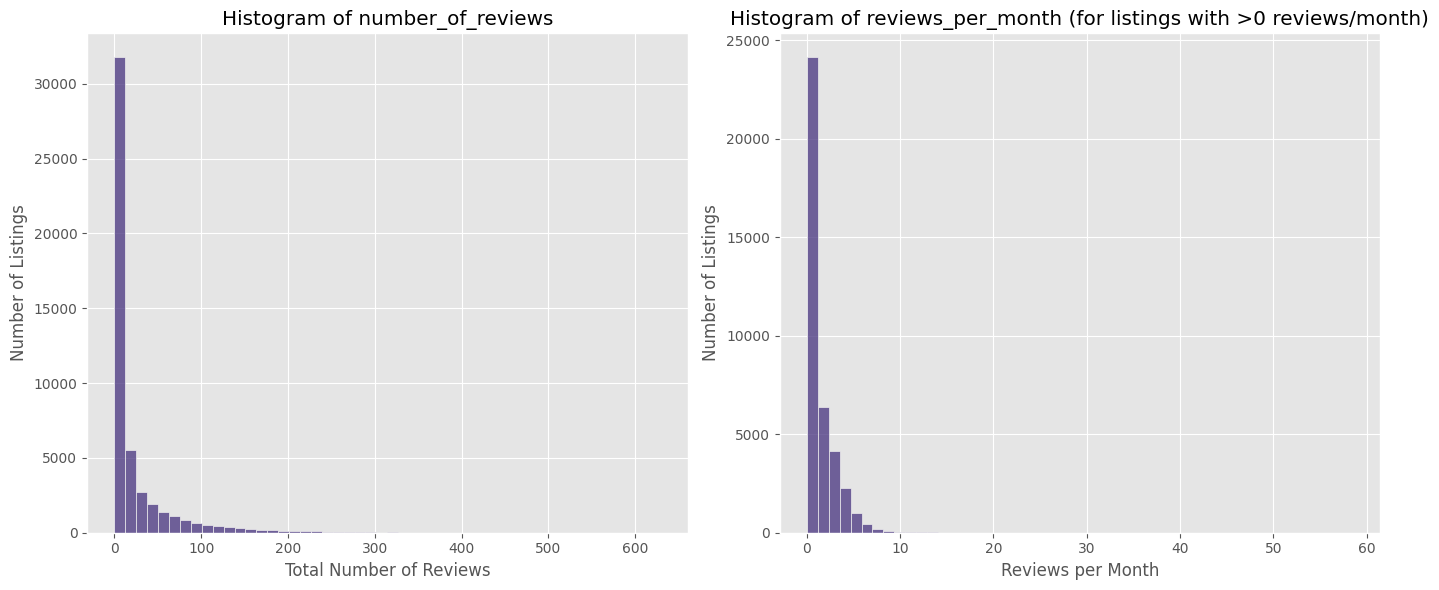


Description of number_of_reviews:
count    48895.000000
mean        23.274466
std         44.550582
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max        629.000000
Name: number_of_reviews, dtype: float64

Description of reviews_per_month (ensure NaNs were handled, e.g., filled with 0):
count    48895.000000
mean         1.090910
std          1.597283
min          0.000000
25%          0.040000
50%          0.370000
75%          1.580000
max         58.500000
Name: reviews_per_month, dtype: float64


In [56]:
print("\n--- Review Metrics: Overall Distribution ---")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['number_of_reviews'], bins=50, kde=False)
plt.title('Histogram of number_of_reviews')
plt.xlabel('Total Number of Reviews')
plt.ylabel('Number of Listings')
# May need to set xlim due to skewness for better visualization
# plt.xlim(0, df['number_of_reviews'].quantile(0.95)) # Example: view up to 95th percentile

plt.subplot(1, 2, 2)
sns.histplot(df[df['reviews_per_month'] > 0]['reviews_per_month'], bins=50, kde=False) # Exclude 0 for a better view of active listings
plt.title('Histogram of reviews_per_month (for listings with >0 reviews/month)')
plt.xlabel('Reviews per Month')
plt.ylabel('Number of Listings')
# May need to set xlim due to skewness
# plt.xlim(0, df['reviews_per_month'].quantile(0.95)) # Example

plt.tight_layout()
plt.show()

print("\nDescription of number_of_reviews:")
print(df['number_of_reviews'].describe())
print("\nDescription of reviews_per_month (ensure NaNs were handled, e.g., filled with 0):")
print(df['reviews_per_month'].describe())


--- Review Metrics: Per neighbourhood_group and neighbourhood ---

Average reviews_per_month per neighbourhood_group (Sorted by most active):
neighbourhood_group
Staten Island    1.576381
Queens           1.567076
Bronx            1.475655
Brooklyn         1.049790
Manhattan        0.976782
Name: reviews_per_month, dtype: float64


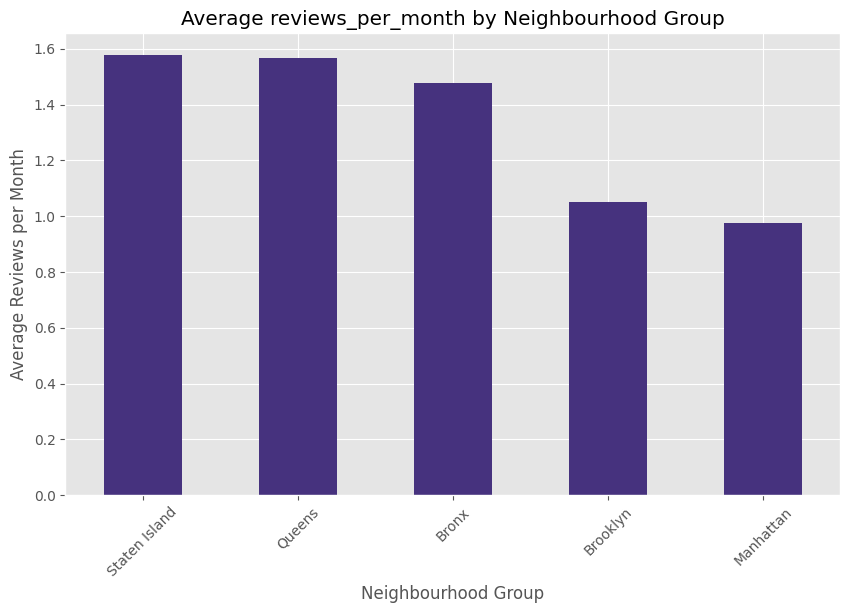

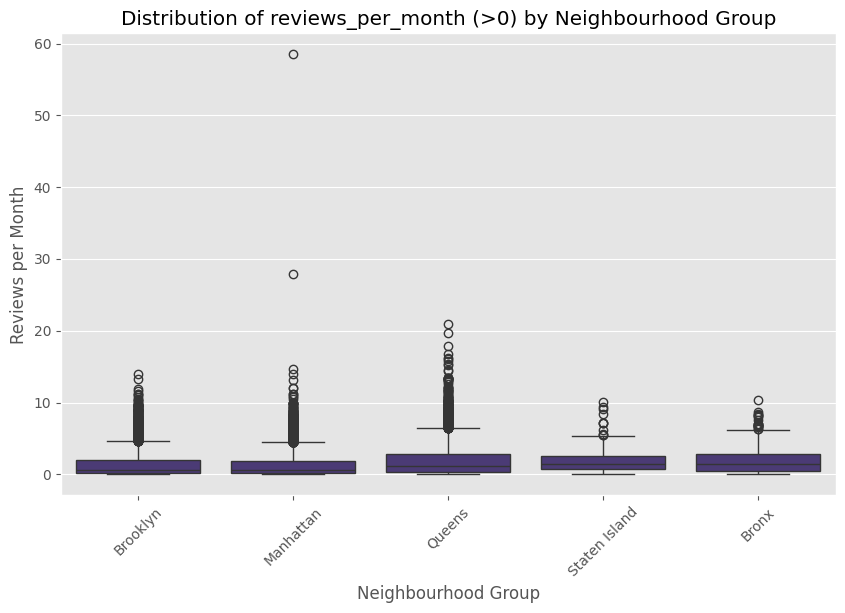


Top 10 Neighbourhoods with Highest Average reviews_per_month:
neighbourhood
East Elmhurst          4.458000
Silver Lake            4.340000
Springfield Gardens    4.193176
Rosebank               3.812857
Huguenot               3.760000
Schuylerville          3.157692
South Ozone Park       3.019750
Jamaica Hills          2.901250
Queens Village         2.684000
Fresh Meadows          2.646875
Name: reviews_per_month, dtype: float64


In [57]:
print("\n--- Review Metrics: Per neighbourhood_group and neighbourhood ---")

# Average reviews_per_month per neighbourhood_group
# Ensure reviews_per_month does not have NaNs before this step (e.g., filled with 0)
avg_reviews_group = df.groupby('neighbourhood_group')['reviews_per_month'].mean().sort_values(ascending=False)
print("\nAverage reviews_per_month per neighbourhood_group (Sorted by most active):")
print(avg_reviews_group)

plt.figure(figsize=(10, 6))
avg_reviews_group.plot(kind='bar')
plt.title('Average reviews_per_month by Neighbourhood Group')
plt.ylabel('Average Reviews per Month')
plt.xlabel('Neighbourhood Group')
plt.xticks(rotation=45)
plt.show()

# Box plot of reviews_per_month by neighbourhood_group (for listings with reviews_per_month > 0)
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbourhood_group', y='reviews_per_month', data=df[df['reviews_per_month'] > 0])
plt.title('Distribution of reviews_per_month (>0) by Neighbourhood Group')
plt.ylabel('Reviews per Month')
plt.xlabel('Neighbourhood Group')
plt.xticks(rotation=45)
# Consider using plt.ylim to zoom in if outliers are too extreme
# plt.ylim(0, df[df['reviews_per_month'] > 0]['reviews_per_month'].quantile(0.95))
plt.show()

# Top 10 neighbourhoods with highest average reviews_per_month (potentially "busiest" by this metric)
avg_reviews_neighbourhood = df.groupby('neighbourhood')['reviews_per_month'].mean().sort_values(ascending=False)
print("\nTop 10 Neighbourhoods with Highest Average reviews_per_month:")
print(avg_reviews_neighbourhood.head(10))


--- Listing Density Analysis ---

Listing Density (Count) per neighbourhood_group:
neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: id, dtype: int64


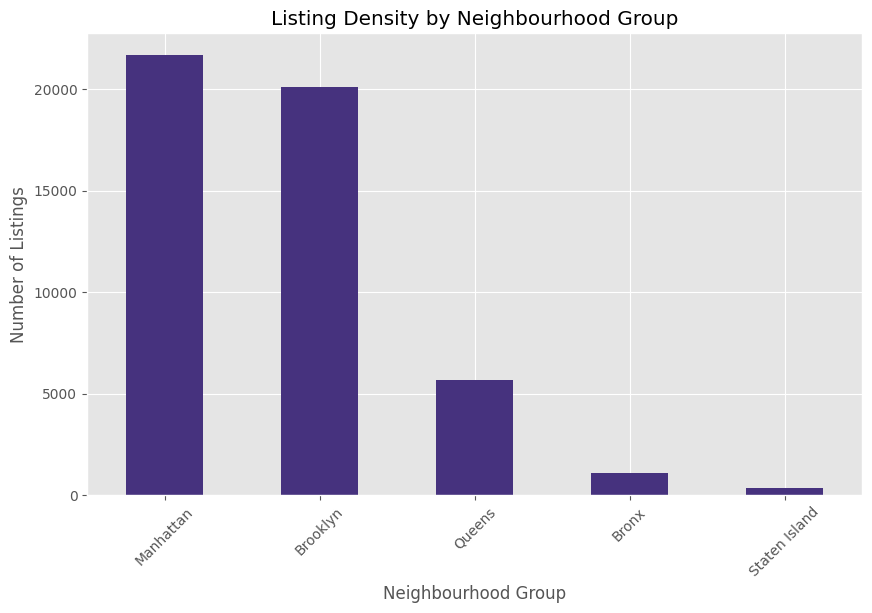


Top 10 Neighbourhoods with Highest Listing Density:
neighbourhood
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
Name: id, dtype: int64


In [58]:
print("\n--- Listing Density Analysis ---")

# Listing density per neighbourhood_group
density_group = df.groupby('neighbourhood_group')['id'].count().sort_values(ascending=False)
print("\nListing Density (Count) per neighbourhood_group:")
print(density_group)

plt.figure(figsize=(10, 6))
density_group.plot(kind='bar')
plt.title('Listing Density by Neighbourhood Group')
plt.ylabel('Number of Listings')
plt.xlabel('Neighbourhood Group')
plt.xticks(rotation=45)
plt.show()

# Top 10 neighbourhoods with highest listing density
density_neighbourhood = df.groupby('neighbourhood')['id'].count().sort_values(ascending=False)
print("\nTop 10 Neighbourhoods with Highest Listing Density:")
print(density_neighbourhood.head(10))


--- Correlations for Busyness (at Neighbourhood Level) ---

Neighbourhood Level Stats (first 5 rows):
   neighbourhood  avg_availability_365  avg_reviews_per_month  listing_density
0       Allerton            163.666667               1.615714               42
1  Arden Heights             94.250000               1.040000                4
2       Arrochar            255.809524               1.060952               21
3        Arverne            188.428571               1.515455               77
4        Astoria            109.191111               1.001411              900

Correlation matrix for potential busyness indicators:
                          inverse_avg_availability  avg_reviews_per_month  \
inverse_avg_availability                  1.000000              -0.190497   
avg_reviews_per_month                    -0.190497               1.000000   
listing_density                          -0.048217              -0.136348   

                          listing_density  
inverse_avg_ava

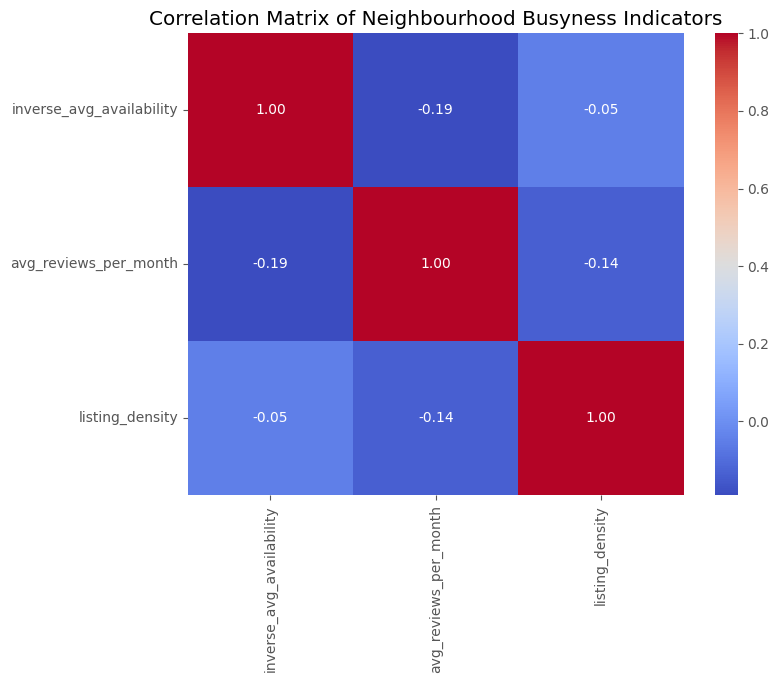


Interpretation of Correlation Matrix:
- Positive values close to 1 indicate strong positive correlation.
- Negative values close to -1 indicate strong negative correlation.
- Values close to 0 indicate weak or no linear correlation.
This helps understand if these metrics move together and could form parts of a composite 'busyness' score.


In [59]:
print("\n--- Correlations for Busyness (at Neighbourhood Level) ---")

# 1. Create a neighbourhood-level DataFrame
neighbourhood_stats = df.groupby('neighbourhood').agg(
    avg_availability_365=('availability_365', 'mean'),
    avg_reviews_per_month=('reviews_per_month', 'mean'), # Assumes reviews_per_month NaNs handled
    listing_density=('id', 'count')
).reset_index()

print("\nNeighbourhood Level Stats (first 5 rows):")
print(neighbourhood_stats.head())

# 2. Calculate the correlation matrix
# For busyness, we expect:
# - avg_availability_365 to be negatively correlated with busyness (lower availability = busier)
# - avg_reviews_per_month to be positively correlated with busyness
# - listing_density to be positively correlated with busyness
# So, let's make 'inverse_avg_availability' for easier interpretation in correlation
neighbourhood_stats['inverse_avg_availability'] = 1 / (neighbourhood_stats['avg_availability_365'] + 0.001) # Add small constant to avoid division by zero

busyness_features_corr = neighbourhood_stats[['inverse_avg_availability', 'avg_reviews_per_month', 'listing_density']].corr()

print("\nCorrelation matrix for potential busyness indicators:")
print(busyness_features_corr)

# 3. Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(busyness_features_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Neighbourhood Busyness Indicators')
plt.show()

print("\nInterpretation of Correlation Matrix:")
print("- Positive values close to 1 indicate strong positive correlation.")
print("- Negative values close to -1 indicate strong negative correlation.")
print("- Values close to 0 indicate weak or no linear correlation.")
print("This helps understand if these metrics move together and could form parts of a composite 'busyness' score.")

#### Summary of "Busyness" and Demand Indicators Analysis

Our exploration into what defines "busyness" yielded several important insights:

* **Availability (`availability_365`):** We found that a substantial portion of listings (over 35%) report zero availability for the year, and half of all listings are available for 45 days or less. At the `neighbourhood_group` level, 'Brooklyn' and 'Manhattan' showed the lowest median availability. However, when we examined individual `neighbourhoods`, we saw extreme variations, with some showing no average availability and others very high availability.

* **Review Activity (`number_of_reviews`, `reviews_per_month`):** The distributions for both total reviews and reviews per month are highly right-skewed, meaning most listings have few reviews and low monthly review rates, while a minority are very active. A surprising finding was that outer `neighbourhood_group`s like 'Staten Island', 'Queens', and 'Bronx' exhibited higher average `reviews_per_month` *per listing* than the denser `neighbourhood_group`s of 'Manhattan' and 'Brooklyn'. Specific `neighbourhoods`, often within these outer groups, stood out with very high average review velocity.

* **Listing Density:** As anticipated, 'Manhattan' and 'Brooklyn' (and their popular `neighbourhoods` like Williamsburg, Bedford-Stuyvesant, and Harlem) overwhelmingly concentrate the highest number of listings.

* **Complexity of "Busyness":** When we aggregated these indicators at the `neighbourhood` level and examined their correlations (inverse availability, average reviews per month, and density), we found only weak, and sometimes counterintuitive negative, linear relationships. This was a key realization: these different facets of "busyness" don't always move in the same direction, suggesting that "busyness" is a multi-dimensional concept rather than a single, easily combined metric.


### 4.2. Defining "Similarity" - Exploring Core Listing and `neighbourhood` Characteristics
*To recommend "similar" `neighbourhoods`, we next investigated features that define the intrinsic character of listings, which can then be aggregated to profile `neighbourhoods`. We focused on price, room type, minimum nights, and host characteristics.*

--- Overall Price Distribution ---
Descriptive statistics for 'price':
count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


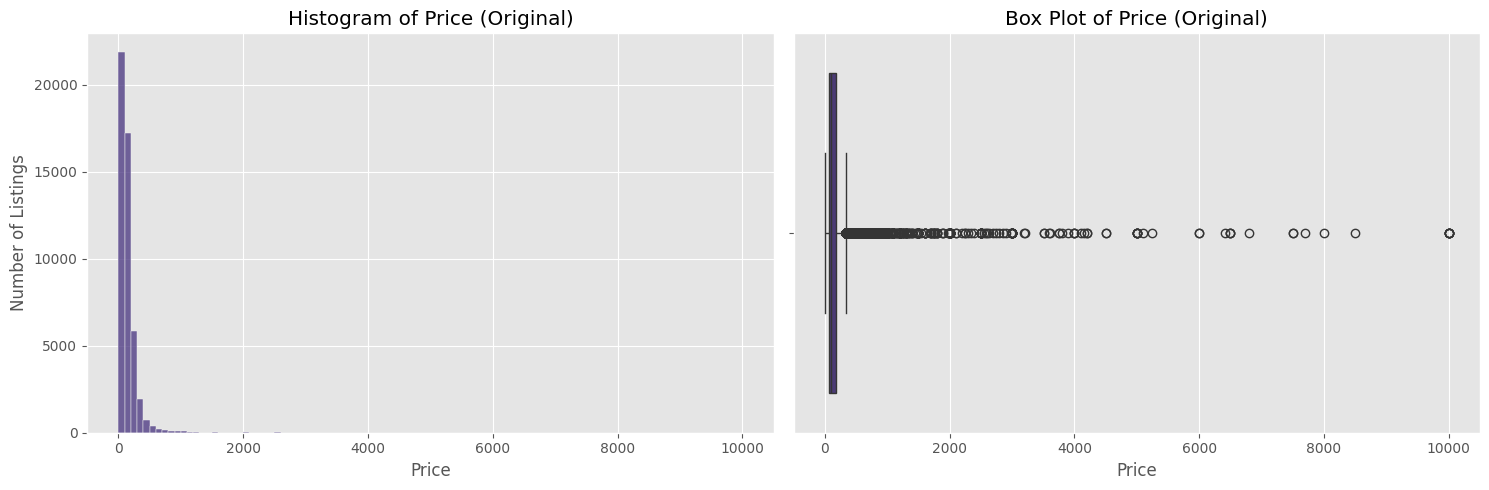

In [60]:
print("--- Overall Price Distribution ---")
print("Descriptive statistics for 'price':")
print(df['price'].describe())

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=100, kde=False)
plt.title('Histogram of Price (Original)')
plt.xlabel('Price')
plt.ylabel('Number of Listings')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['price'])
plt.title('Box Plot of Price (Original)')
plt.xlabel('Price')

plt.tight_layout()
plt.show()



--- Price Distribution (Log Transformed for Visualization) ---


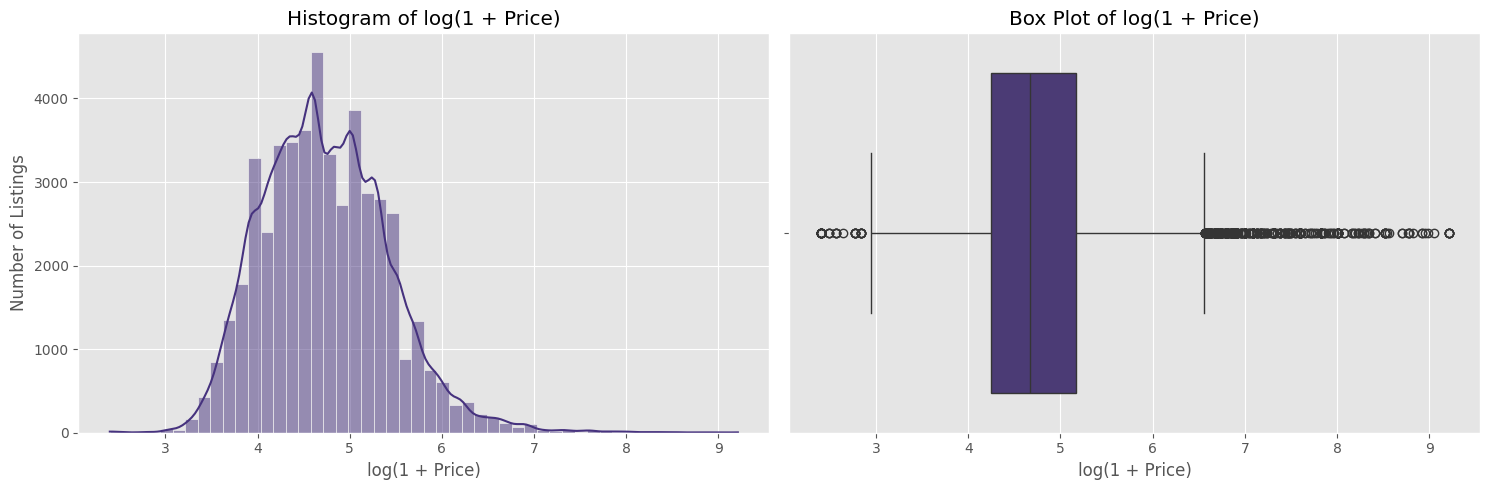

In [61]:
print("\n--- Price Distribution (Log Transformed for Visualization) ---")
df_log_price = df[df['price'] > 0]['price']
log_price = np.log1p(df_log_price)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(log_price, bins=50, kde=True)
plt.title('Histogram of log(1 + Price)')
plt.xlabel('log(1 + Price)')
plt.ylabel('Number of Listings')

plt.subplot(1, 2, 2)
sns.boxplot(x=log_price)
plt.title('Box Plot of log(1 + Price)')
plt.xlabel('log(1 + Price)')

plt.tight_layout()
plt.show()


--- Price Distribution per room_type ---


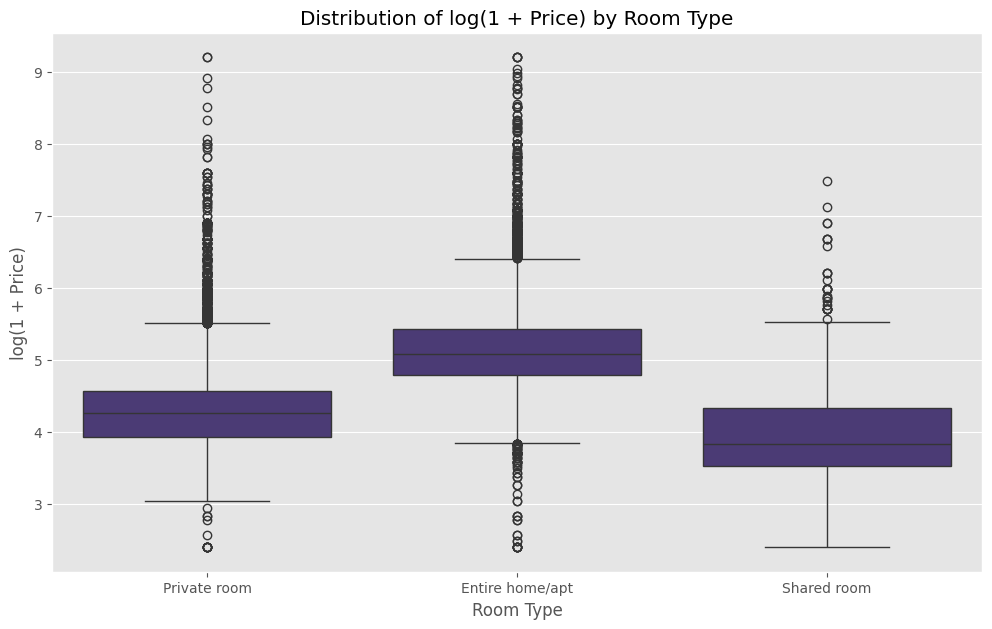

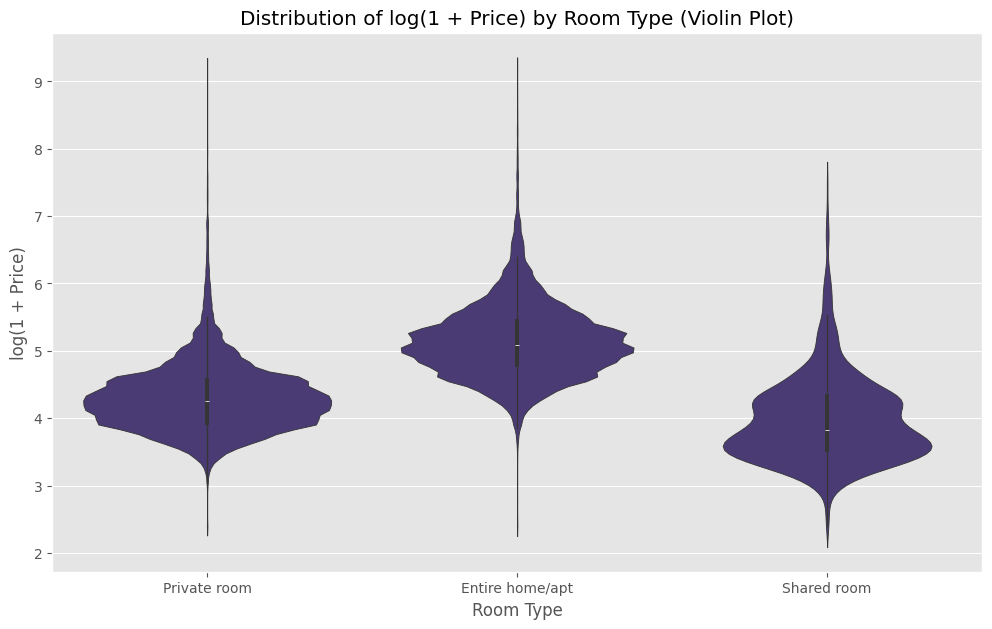


Average and Median price per room_type:
                       mean  median  count
room_type                                 
Entire home/apt  211.794246   160.0  25409
Private room      89.780973    70.0  22326
Shared room       70.127586    45.0   1160


In [62]:
print("\n--- Price Distribution per room_type ---")

price_to_plot = np.log1p(df[df['price'] > 0]['price']) 
y_label_plot = 'log(1 + Price)' # Or 'Price'

plt.figure(figsize=(12, 7))
sns.boxplot(x='room_type', y=price_to_plot, data=df[df['price'] > 0]) # Ensure data matches price_to_plot
plt.title(f'Distribution of {y_label_plot} by Room Type')
plt.xlabel('Room Type')
plt.ylabel(y_label_plot)
plt.show()

plt.figure(figsize=(12, 7))
sns.violinplot(x='room_type', y=price_to_plot, data=df[df['price'] > 0])
plt.title(f'Distribution of {y_label_plot} by Room Type (Violin Plot)')
plt.xlabel('Room Type')
plt.ylabel(y_label_plot)
plt.show()

print("\nAverage and Median price per room_type:")
print(df.groupby('room_type')['price'].agg(['mean', 'median', 'count']).sort_values(by='median', ascending=False))


--- Price Distribution per neighbourhood_group ---


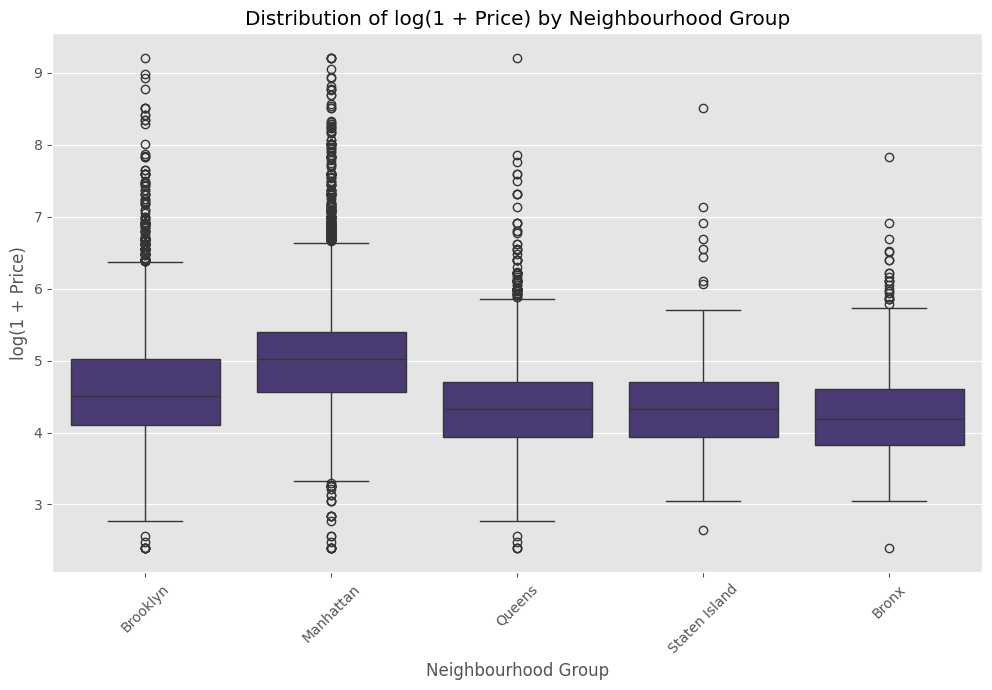


Average and Median price per neighbourhood_group:
                           mean  median  count
neighbourhood_group                           
Manhattan            196.875814   150.0  21661
Brooklyn             124.383207    90.0  20104
Queens                99.517649    75.0   5666
Staten Island        114.812332    75.0    373
Bronx                 87.496792    65.0   1091


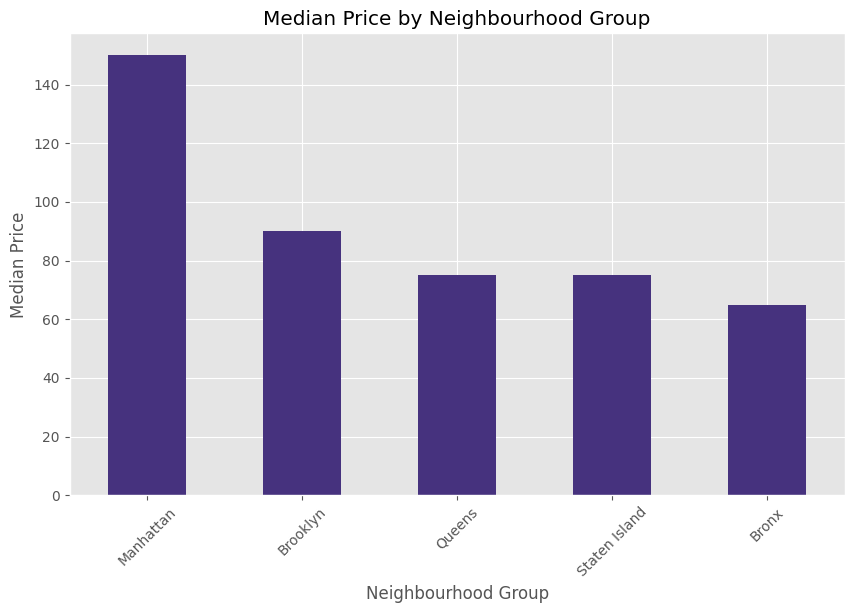

In [63]:
print("\n--- Price Distribution per neighbourhood_group ---")

plt.figure(figsize=(12, 7))
sns.boxplot(x='neighbourhood_group', y=price_to_plot, data=df[df['price'] > 0])
plt.title(f'Distribution of {y_label_plot} by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel(y_label_plot)
plt.xticks(rotation=45)
plt.show()

print("\nAverage and Median price per neighbourhood_group:")
avg_price_neighbourhood = df.groupby('neighbourhood_group')['price'].agg(['mean', 'median', 'count']).sort_values(by='median', ascending=False)
print(avg_price_neighbourhood)

plt.figure(figsize=(10, 6))
avg_price_neighbourhood['median'].plot(kind='bar')
plt.title('Median Price by Neighbourhood Group')
plt.ylabel('Median Price')
plt.xlabel('Neighbourhood Group')
plt.xticks(rotation=45)
plt.show()


--- Price Distribution per neighbourhood (Example: Top 10 most common) ---
Analyzing price for Top 10 most common neighbourhoods: ['Williamsburg', 'Bedford-Stuyvesant', 'Harlem', 'Bushwick', 'Upper West Side', "Hell's Kitchen", 'East Village', 'Upper East Side', 'Crown Heights', 'Midtown']


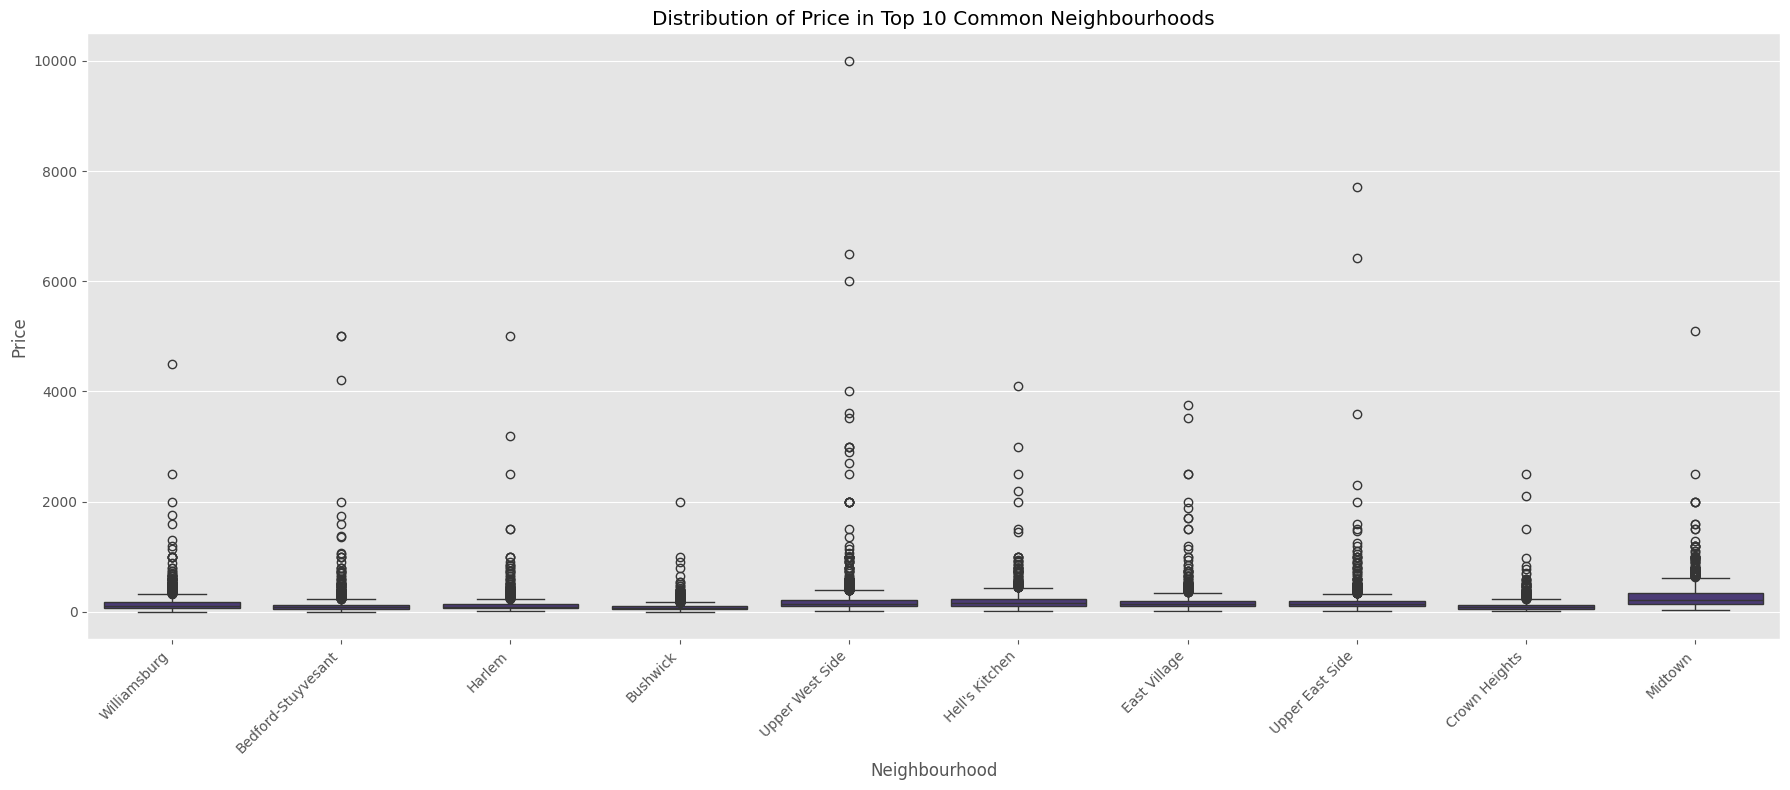


Average and Median price for Top 10 most common neighbourhoods:
                          mean  median  count
neighbourhood                                
Williamsburg        143.802806   105.0   3920
Bedford-Stuyvesant  107.678244    80.0   3714
Harlem              118.974041    89.0   2658
Bushwick             84.800406    65.0   2465
Upper West Side     210.918316   150.0   1971
Hell's Kitchen      204.794178   168.0   1958
East Village        186.083108   150.0   1853
Upper East Side     188.948276   149.0   1798
Crown Heights       112.480179    85.0   1564
Midtown             282.719094   210.0   1545


In [64]:
print("\n--- Price Distribution per neighbourhood (Example: Top 10 most common) ---")

# Find the top 10 most common neighborhoods
top_10_neighbourhoods = df['neighbourhood'].value_counts().nlargest(10).index
print(f"Analyzing price for Top 10 most common neighbourhoods: {list(top_10_neighbourhoods)}")

# Filter the DataFrame for these top 10 neighborhoods
df_top_neighbourhoods = df[df['neighbourhood'].isin(top_10_neighbourhoods)]

# Using log_price for visualization
price_to_plot_neigh = np.log1p(df_top_neighbourhoods[df_top_neighbourhoods['price'] > 0]['price'])
y_label_plot_neigh = 'log(1 + Price)'


plt.figure(figsize=(18, 8))
sns.boxplot(x='neighbourhood', y='price', data=df_top_neighbourhoods, order=top_10_neighbourhoods)
plt.title(f'Distribution of Price in Top 10 Common Neighbourhoods')
plt.xlabel('Neighbourhood')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nAverage and Median price for Top 10 most common neighbourhoods:")
avg_price_top_neigh = df_top_neighbourhoods.groupby('neighbourhood')['price'].agg(['mean', 'median', 'count']).reindex(top_10_neighbourhoods) # Keep original order
print(avg_price_top_neigh)

--- Overall Room Type Distribution ---
Frequency of each room_type:
room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64

Proportion of each room_type (%):
room_type
Entire home/apt    51.966459
Private room       45.661111
Shared room         2.372431
Name: proportion, dtype: float64


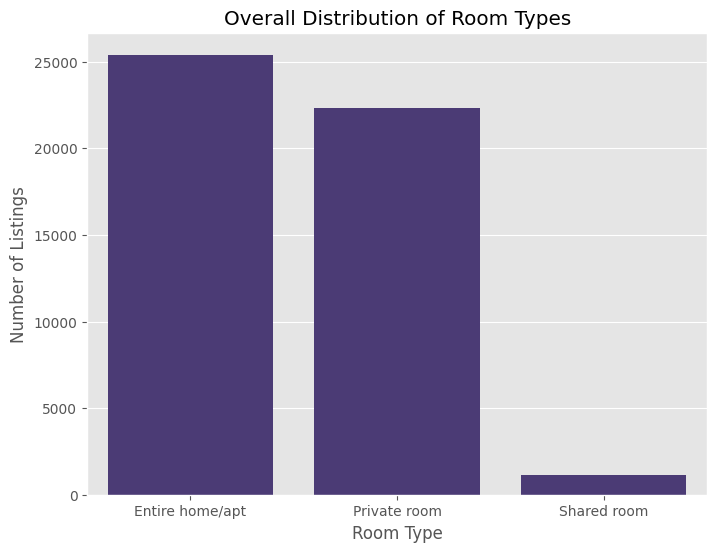

In [65]:
print("--- Overall Room Type Distribution ---")

# Frequency counts
room_type_counts = df['room_type'].value_counts()
print("Frequency of each room_type:")
print(room_type_counts)

# Proportions
room_type_proportions = df['room_type'].value_counts(normalize=True) * 100
print("\nProportion of each room_type (%):")
print(room_type_proportions)

# Visualization
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='room_type', order=room_type_counts.index) # Order by frequency
plt.title('Overall Distribution of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Number of Listings')
plt.show()


--- Room Type Distribution per Neighbourhood Group ---
Counts of room_type within each neighbourhood_group:
room_type            Entire home/apt  Private room  Shared room
neighbourhood_group                                            
Bronx                            379           652           60
Brooklyn                        9559         10132          413
Manhattan                      13199          7982          480
Queens                          2096          3372          198
Staten Island                    176           188            9

Proportions (%) of room_type within each neighbourhood_group:
room_type            Entire home/apt  Private room  Shared room
neighbourhood_group                                            
Bronx                      34.738772     59.761687     5.499542
Brooklyn                   47.547752     50.397931     2.054318
Manhattan                  60.934398     36.849638     2.215964
Queens                     36.992587     59.512884     3.494

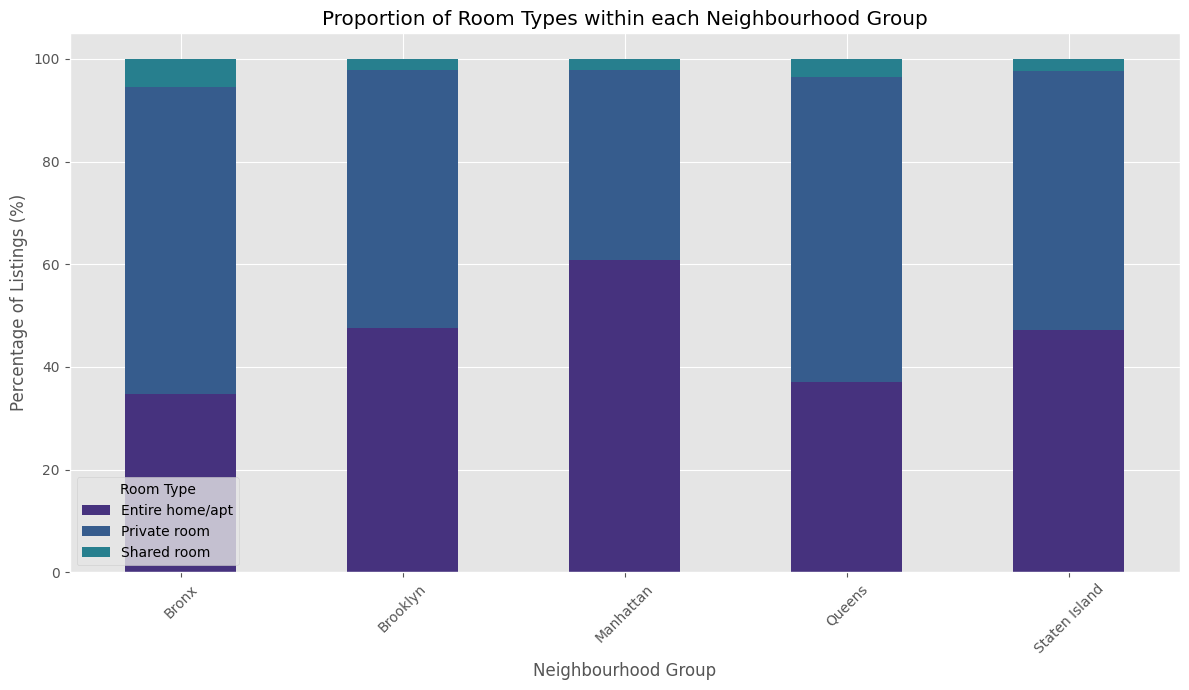

<Figure size 1200x700 with 0 Axes>

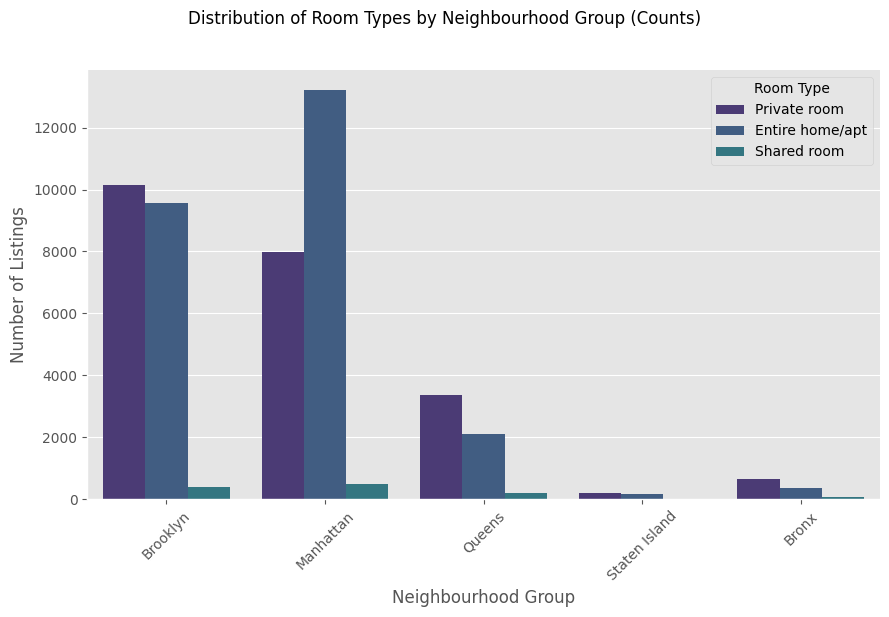

In [66]:
print("\n--- Room Type Distribution per Neighbourhood Group ---")

# Grouped counts
group_room_counts = df.groupby('neighbourhood_group')['room_type'].value_counts(normalize=False).unstack(fill_value=0)
print("Counts of room_type within each neighbourhood_group:")
print(group_room_counts)

# Proportions for stacked bar chart
group_room_proportions = df.groupby('neighbourhood_group')['room_type'].value_counts(normalize=True).mul(100).unstack(fill_value=0)
print("\nProportions (%) of room_type within each neighbourhood_group:")
print(group_room_proportions)

# Visualization - Stacked Bar Chart for Proportions
group_room_proportions.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Proportion of Room Types within each Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Percentage of Listings (%)')
plt.xticks(rotation=45)
plt.legend(title='Room Type')
plt.tight_layout()
plt.show()

# Alternative Visualization - Grouped Bar Chart for Counts (using catplot)
plt.figure(figsize=(12, 7)) # May need to adjust figure size if using catplot separately
g = sns.catplot(data=df, x='neighbourhood_group', hue='room_type', kind='count', height=6, aspect=1.5, legend_out=False)
g.set_axis_labels("Neighbourhood Group", "Number of Listings")
g.fig.suptitle('Distribution of Room Types by Neighbourhood Group (Counts)', y=1.02) # Adjust title position
plt.xticks(rotation=45)
plt.legend(title='Room Type')
plt.tight_layout() # Apply to the figure of the catplot
plt.show()


--- Room Type Distribution per Neighbourhood (Example: Top 5 Most Common) ---
Analyzing room type distribution for Top 5 most common neighbourhoods: ['Williamsburg', 'Bedford-Stuyvesant', 'Harlem', 'Bushwick', 'Upper West Side']

Proportions (%) of room_type within selected top neighbourhoods:
room_type           Entire home/apt  Private room  Shared room
neighbourhood                                                 
Williamsburg              48.239796     50.943878     0.816327
Bedford-Stuyvesant        42.837911     54.873452     2.288638
Harlem                    38.976674     59.179834     1.843491
Bushwick                  27.505071     69.736308     2.758621
Upper West Side           63.723998     34.246575     2.029427


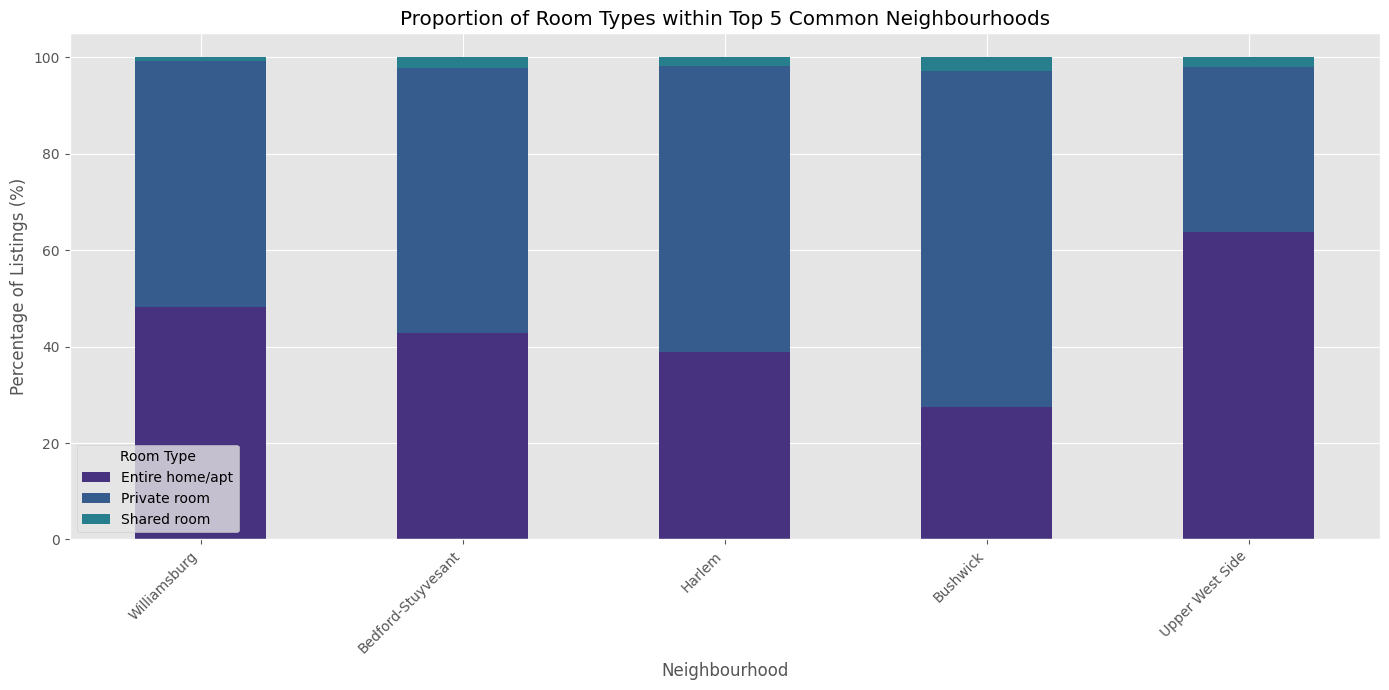

In [67]:
print("\n--- Room Type Distribution per Neighbourhood (Example: Top 5 Most Common) ---")

# Find the top 5 most common neighborhoods
top_5_neighbourhoods = df['neighbourhood'].value_counts().nlargest(5).index
print(f"Analyzing room type distribution for Top 5 most common neighbourhoods: {list(top_5_neighbourhoods)}")

# Filter the DataFrame for these top 5 neighborhoods
df_top_neighbourhoods = df[df['neighbourhood'].isin(top_5_neighbourhoods)]

# Proportions for stacked bar chart for these specific neighborhoods
top_hoods_room_proportions = df_top_neighbourhoods.groupby('neighbourhood')['room_type'].value_counts(normalize=True).mul(100).unstack(fill_value=0)
print("\nProportions (%) of room_type within selected top neighbourhoods:")
print(top_hoods_room_proportions.reindex(top_5_neighbourhoods)) # Keep original order

# Visualization - Stacked Bar Chart for Proportions
if not top_hoods_room_proportions.empty:
    top_hoods_room_proportions.reindex(top_5_neighbourhoods).plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.title('Proportion of Room Types within Top 5 Common Neighbourhoods')
    plt.xlabel('Neighbourhood')
    plt.ylabel('Percentage of Listings (%)')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Room Type')
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot for top neighbourhoods.")

--- Overall minimum_nights Distribution ---
Descriptive statistics for 'minimum_nights':
count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64


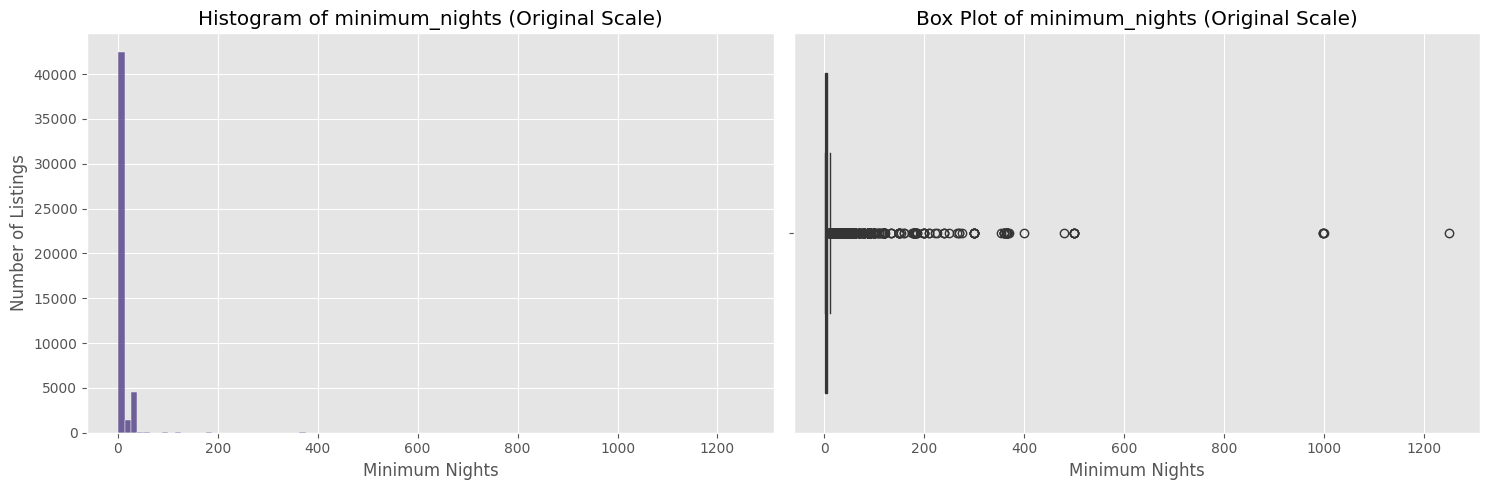

In [68]:
print("--- Overall minimum_nights Distribution ---")
print("Descriptive statistics for 'minimum_nights':")
print(df['minimum_nights'].describe())

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['minimum_nights'], bins=100, kde=False) # Using more bins initially
plt.title('Histogram of minimum_nights (Original Scale)')
plt.xlabel('Minimum Nights')
plt.ylabel('Number of Listings')
# The x-axis might be dominated by outliers. We'll address this.

plt.subplot(1, 2, 2)
sns.boxplot(x=df['minimum_nights'])
plt.title('Box Plot of minimum_nights (Original Scale)')
plt.xlabel('Minimum Nights')

plt.tight_layout()
plt.show()


--- Focused Visualization of minimum_nights ---


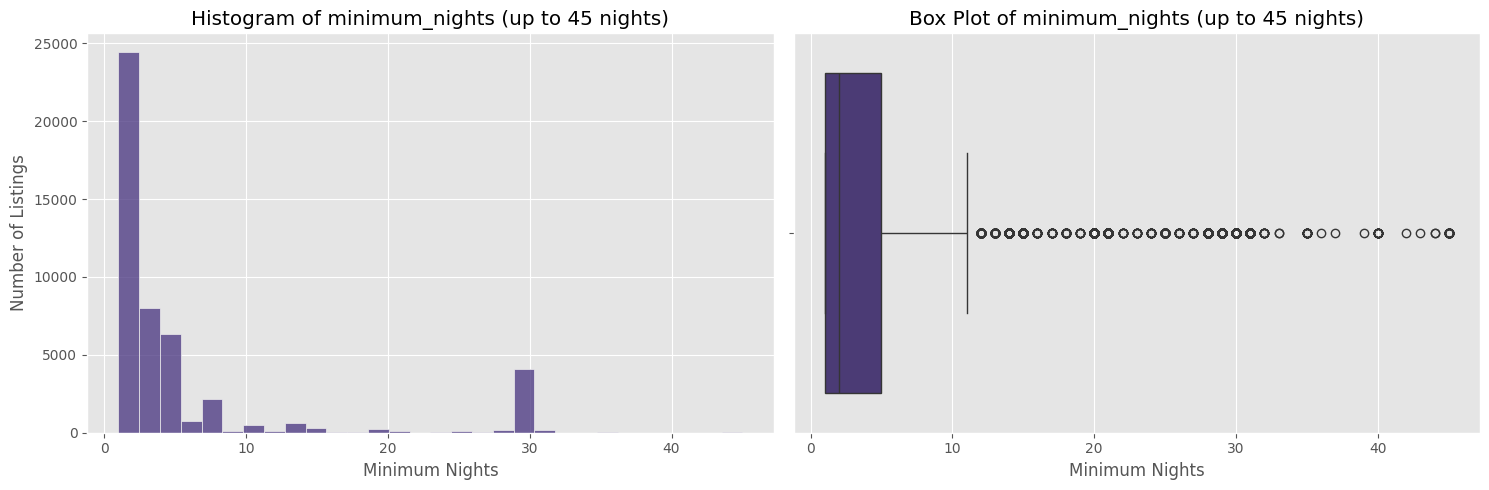

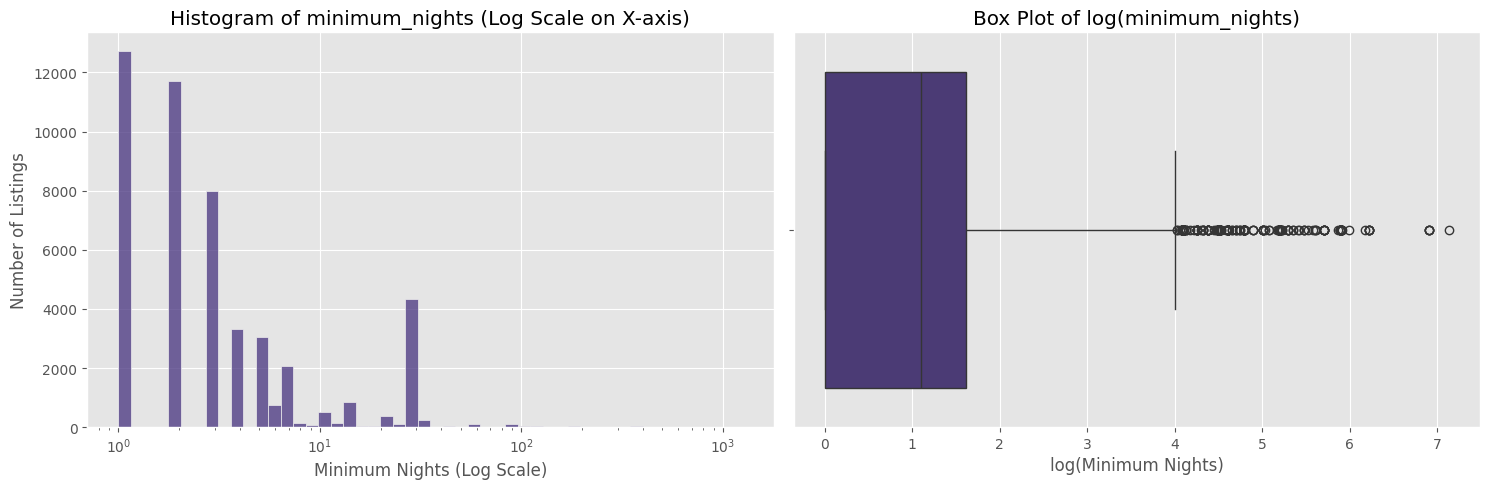

In [69]:
print("\n--- Focused Visualization of minimum_nights ---")


upper_limit = df['minimum_nights'].quantile(0.99) 

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(df[df['minimum_nights'] <= upper_limit]['minimum_nights'], bins=30, kde=False)
plt.title(f'Histogram of minimum_nights (up to {upper_limit:.0f} nights)')
plt.xlabel('Minimum Nights')
plt.ylabel('Number of Listings')

plt.subplot(1, 2, 2)
sns.boxplot(x=df[df['minimum_nights'] <= upper_limit]['minimum_nights'])
plt.title(f'Box Plot of minimum_nights (up to {upper_limit:.0f} nights)')
plt.xlabel('Minimum Nights')

plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

temp_min_nights_for_log_viz = df[df['minimum_nights'] > 0]['minimum_nights']
sns.histplot(temp_min_nights_for_log_viz, bins=50, kde=False, log_scale=True)
plt.title('Histogram of minimum_nights (Log Scale on X-axis)')
plt.xlabel('Minimum Nights (Log Scale)')
plt.ylabel('Number of Listings')

plt.subplot(1, 2, 2)

if df['minimum_nights'].min() >= 1:
    sns.boxplot(x=np.log(df['minimum_nights']))
    plt.title('Box Plot of log(minimum_nights)')
    plt.xlabel('log(Minimum Nights)')
elif df['minimum_nights'].min() >= 0: # If it can be 0, use log1p
    sns.boxplot(x=np.log1p(df['minimum_nights']))
    plt.title('Box Plot of log1p(minimum_nights)')
    plt.xlabel('log1p(Minimum Nights)')
    
plt.tight_layout()
plt.show()


--- minimum_nights Distribution per room_type ---


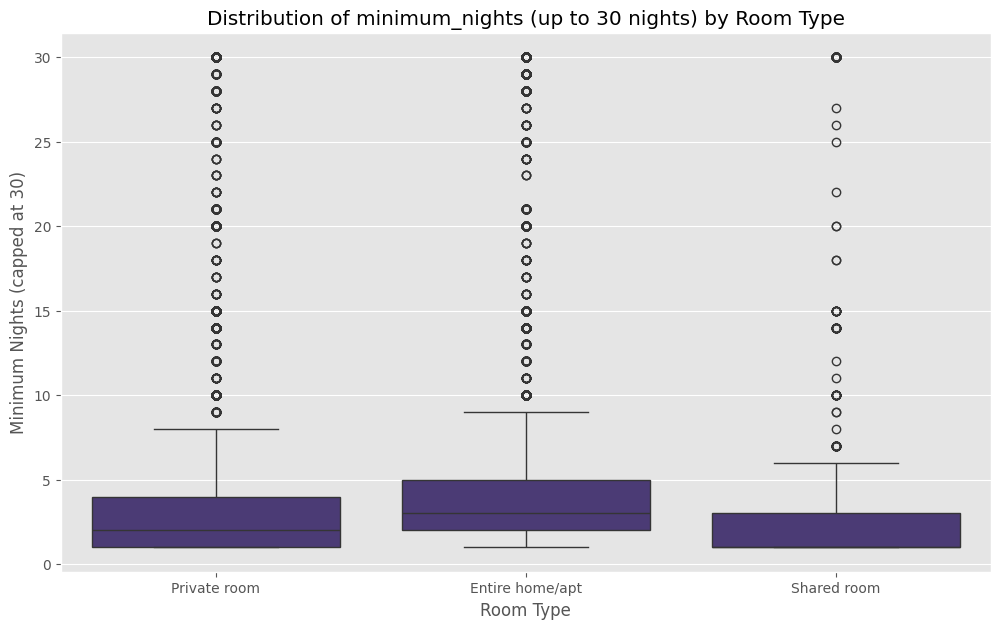

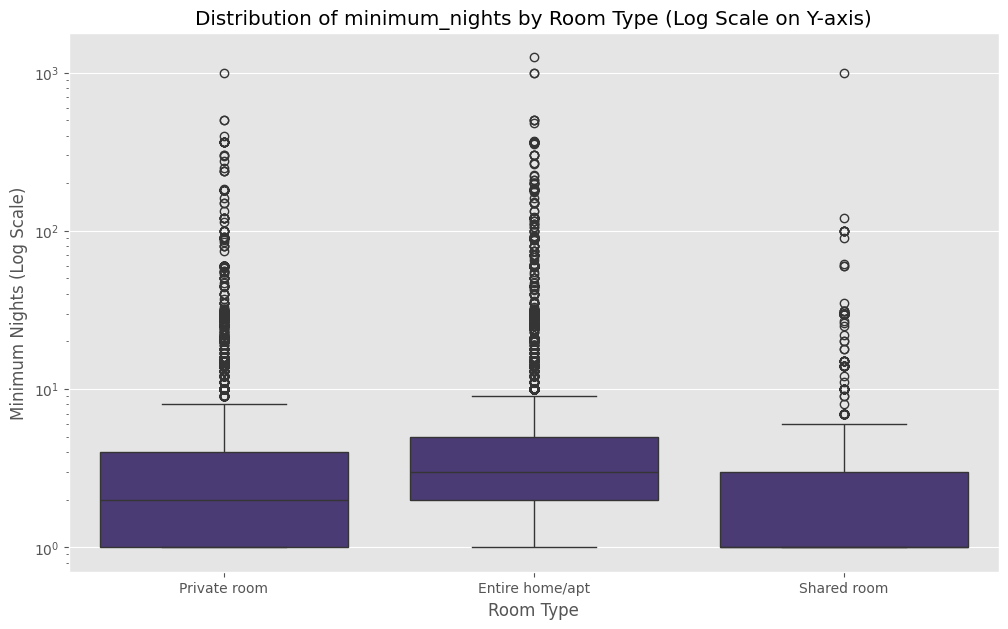


Average and Median minimum_nights per room_type:
                     mean  median  count
room_type                               
Entire home/apt  8.506907     3.0  25409
Private room     5.377900     2.0  22326
Shared room      6.475000     1.0   1160


In [70]:
print("\n--- minimum_nights Distribution per room_type ---")

upper_limit_plot = df['minimum_nights'].quantile(0.95)

plt.figure(figsize=(12, 7))
sns.boxplot(x='room_type', y='minimum_nights', data=df[df['minimum_nights'] <= upper_limit_plot])
plt.title(f'Distribution of minimum_nights (up to {upper_limit_plot:.0f} nights) by Room Type')
plt.xlabel('Room Type')
plt.ylabel(f'Minimum Nights (capped at {upper_limit_plot:.0f})')
plt.show()


plt.figure(figsize=(12, 7))
sns.boxplot(x='room_type', y='minimum_nights', data=df)
plt.yscale('log') 
plt.title('Distribution of minimum_nights by Room Type (Log Scale on Y-axis)')
plt.xlabel('Room Type')
plt.ylabel('Minimum Nights (Log Scale)')
plt.show()

print("\nAverage and Median minimum_nights per room_type:")
print(df.groupby('room_type')['minimum_nights'].agg(['mean', 'median', 'count']).sort_values(by='median', ascending=False))


--- minimum_nights Distribution per neighbourhood_group ---


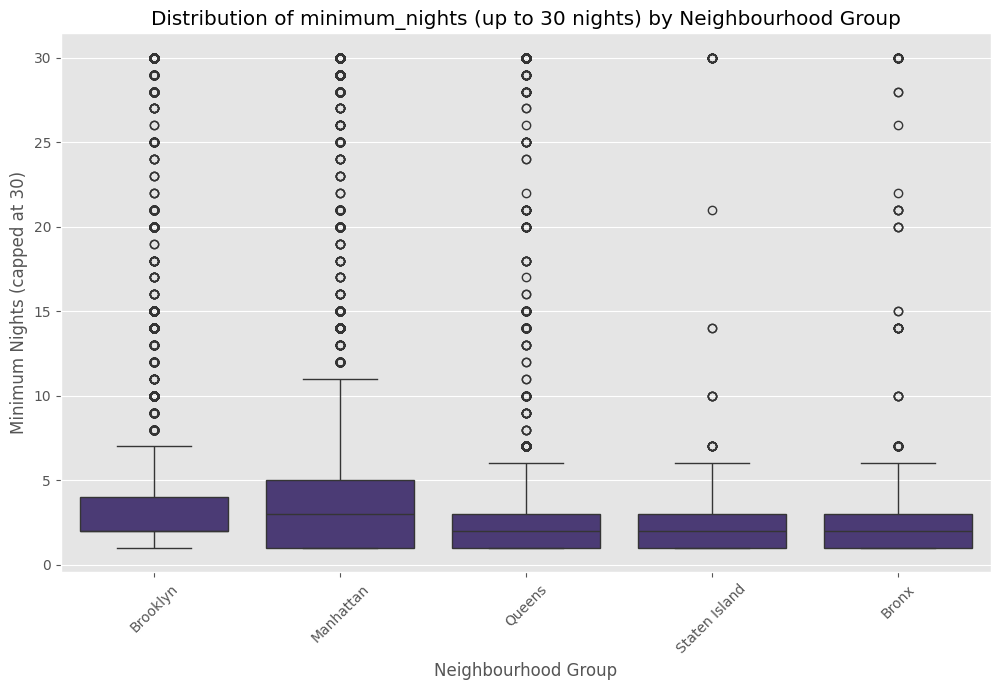

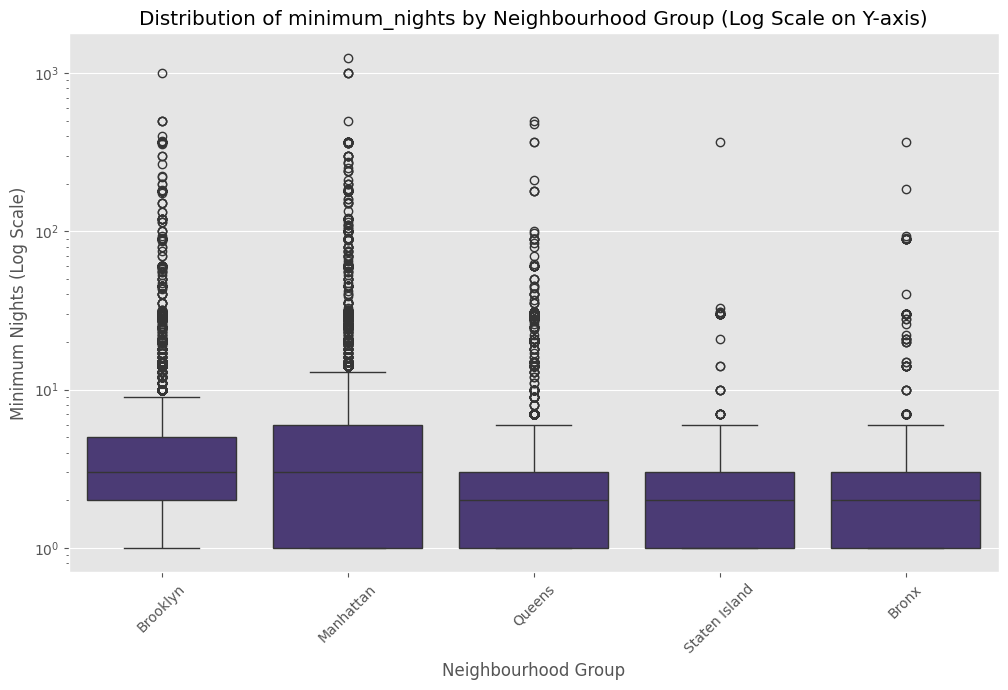


Average and Median minimum_nights per neighbourhood_group:
                         mean  median  count
neighbourhood_group                         
Brooklyn             6.056556     3.0  20104
Manhattan            8.579151     3.0  21661
Bronx                4.560953     2.0   1091
Queens               5.181433     2.0   5666
Staten Island        4.831099     2.0    373


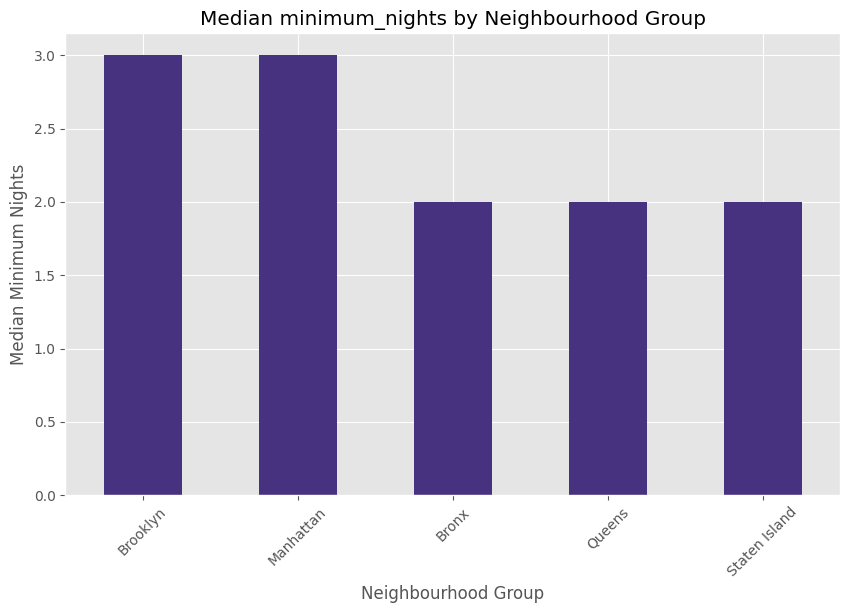

In [71]:
print("\n--- minimum_nights Distribution per neighbourhood_group ---")


plt.figure(figsize=(12, 7))
sns.boxplot(x='neighbourhood_group', y='minimum_nights', data=df[df['minimum_nights'] <= upper_limit_plot])
plt.title(f'Distribution of minimum_nights (up to {upper_limit_plot:.0f} nights) by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel(f'Minimum Nights (capped at {upper_limit_plot:.0f})')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 7))
sns.boxplot(x='neighbourhood_group', y='minimum_nights', data=df)
plt.yscale('log') # Apply log scale to y-axis
plt.title('Distribution of minimum_nights by Neighbourhood Group (Log Scale on Y-axis)')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Minimum Nights (Log Scale)')
plt.xticks(rotation=45)
plt.show()

print("\nAverage and Median minimum_nights per neighbourhood_group:")
avg_min_nights_neighbourhood = df.groupby('neighbourhood_group')['minimum_nights'].agg(['mean', 'median', 'count']).sort_values(by='median', ascending=False)
print(avg_min_nights_neighbourhood)

plt.figure(figsize=(10, 6))
avg_min_nights_neighbourhood['median'].plot(kind='bar')
plt.title('Median minimum_nights by Neighbourhood Group')
plt.ylabel('Median Minimum Nights')
plt.xlabel('Neighbourhood Group')
plt.xticks(rotation=45)
plt.show()

--- Overall calculated_host_listings_count Distribution ---
Descriptive statistics for 'calculated_host_listings_count':
count    48895.000000
mean         7.143982
std         32.952519
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64


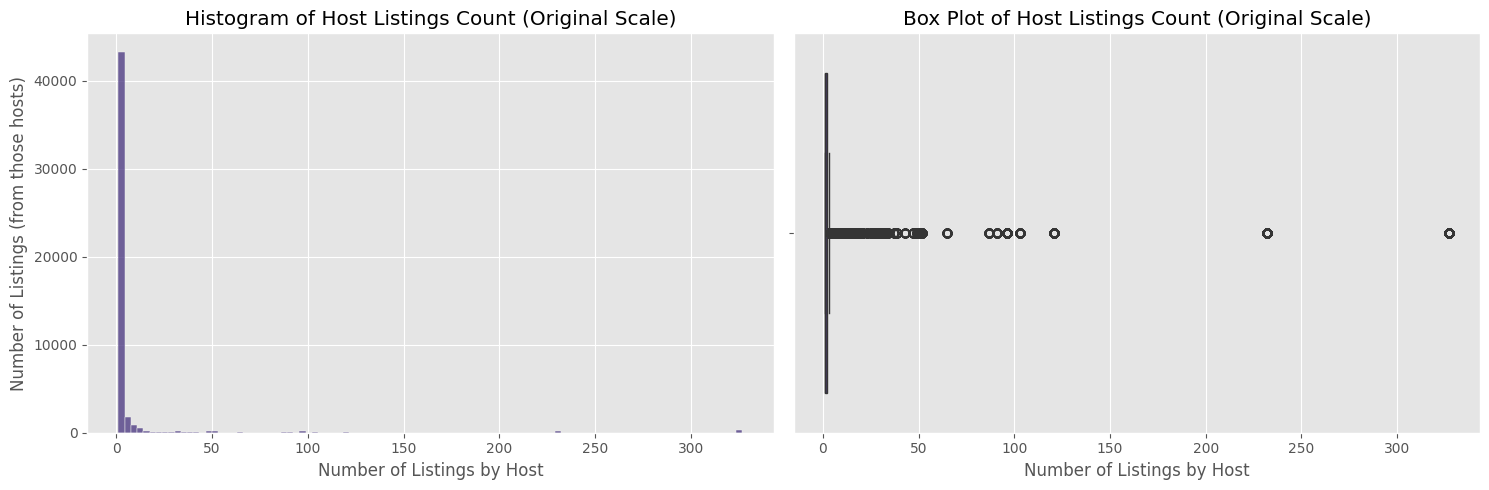


Value counts for host listings count (Top 10):
calculated_host_listings_count
1      32303
2       6658
3       2853
4       1440
5        845
6        570
8        416
7        399
327      327
9        234
Name: count, dtype: int64

Percentage of listings by hosts with only 1 listing: 66.07%
Percentage of listings by hosts with 1 to 2 listings: 79.68%
Percentage of listings by hosts with more than 10 listings: 6.07%


In [72]:
print("--- Overall calculated_host_listings_count Distribution ---")
print("Descriptive statistics for 'calculated_host_listings_count':")
print(df['calculated_host_listings_count'].describe())

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['calculated_host_listings_count'], bins=100, kde=False)
plt.title('Histogram of Host Listings Count (Original Scale)')
plt.xlabel('Number of Listings by Host')
plt.ylabel('Number of Listings (from those hosts)')
# The x-axis will likely be dominated by hosts with few listings.

plt.subplot(1, 2, 2)
sns.boxplot(x=df['calculated_host_listings_count'])
plt.title('Box Plot of Host Listings Count (Original Scale)')
plt.xlabel('Number of Listings by Host')

plt.tight_layout()
plt.show()

print("\nValue counts for host listings count (Top 10):")
print(df['calculated_host_listings_count'].value_counts().nlargest(10))

print(f"\nPercentage of listings by hosts with only 1 listing: {(df['calculated_host_listings_count'] == 1).mean()*100:.2f}%")
print(f"Percentage of listings by hosts with 1 to 2 listings: {(df['calculated_host_listings_count'] <= 2).mean()*100:.2f}%")
print(f"Percentage of listings by hosts with more than 10 listings: {(df['calculated_host_listings_count'] > 10).mean()*100:.2f}%")



--- Focused Visualization of calculated_host_listings_count ---


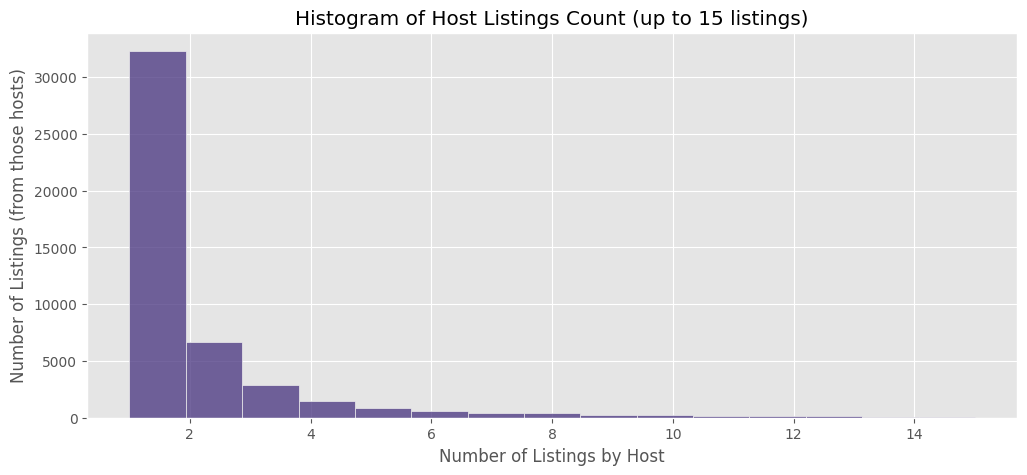

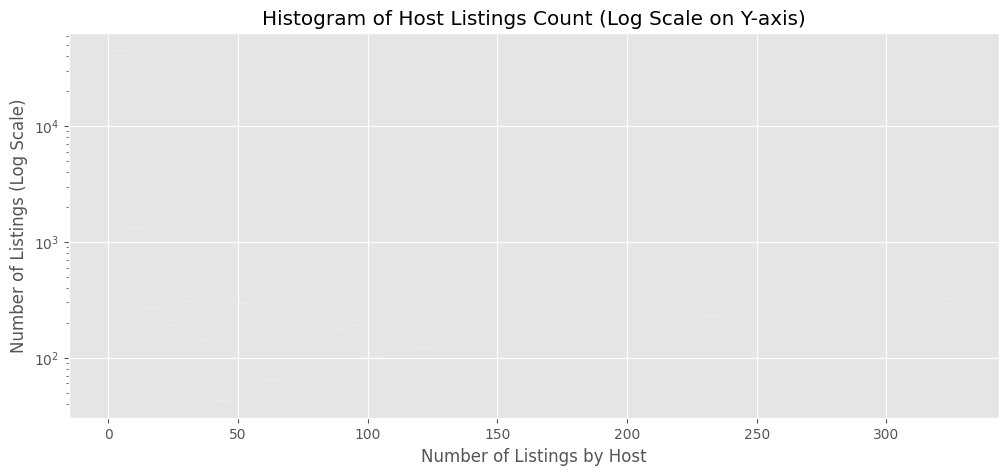


Distribution of listings by derived host_type_category:
host_type_category
1        32303
2         6658
3-5       5138
6-10      1829
11-50     1645
51+       1322
Name: count, dtype: int64


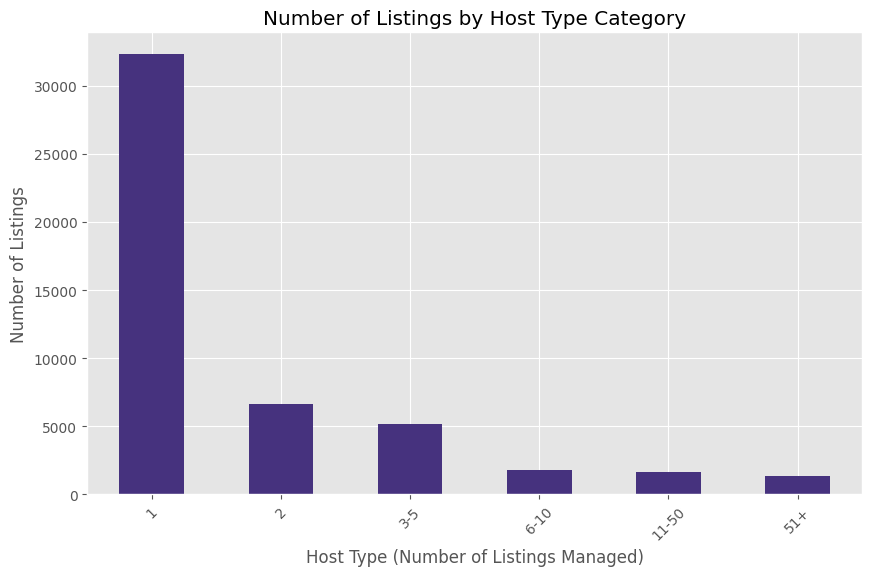

In [73]:
print("\n--- Focused Visualization of calculated_host_listings_count ---")

upper_limit_host_viz = df['calculated_host_listings_count'].quantile(0.95)

plt.figure(figsize=(12, 5))
sns.histplot(df[df['calculated_host_listings_count'] <= upper_limit_host_viz]['calculated_host_listings_count'],
             bins=int(upper_limit_host_viz), kde=False)
plt.title(f'Histogram of Host Listings Count (up to {upper_limit_host_viz:.0f} listings)')
plt.xlabel('Number of Listings by Host')
plt.ylabel('Number of Listings (from those hosts)')
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df['calculated_host_listings_count'], bins=50, kde=False, log_scale=(False, True))
plt.title('Histogram of Host Listings Count (Log Scale on Y-axis)')
plt.xlabel('Number of Listings by Host')
plt.ylabel('Number of Listings (Log Scale)')
plt.show()


bins = [0, 1, 2, 5, 10, 50, df['calculated_host_listings_count'].max() + 1]
labels = ['1', '2', '3-5', '6-10', '11-50', '51+']
df['host_type_category'] = pd.cut(df['calculated_host_listings_count'], bins=bins, labels=labels, right=True)

print("\nDistribution of listings by derived host_type_category:")
host_type_counts = df['host_type_category'].value_counts().reindex(labels) # Ensure correct order
print(host_type_counts)

plt.figure(figsize=(10, 6))
host_type_counts.plot(kind='bar')
plt.title('Number of Listings by Host Type Category')
plt.xlabel('Host Type (Number of Listings Managed)')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.show()


--- Host Type Distribution per room_type ---

Proportions (%) of listings by host_type_category within each room_type:
host_type_category          1          2        3-5       6-10     11-50  \
room_type                                                                  
Entire home/apt     74.760911   9.957102   5.486245   1.826125  3.199654   
Private room        57.627878  17.750605  15.726059   5.106154  3.296605   
Shared room         38.017241  14.224138  20.086207  19.396552  8.275862   

host_type_category       51+  
room_type                     
Entire home/apt     4.769963  
Private room        0.492699  
Shared room         0.000000  


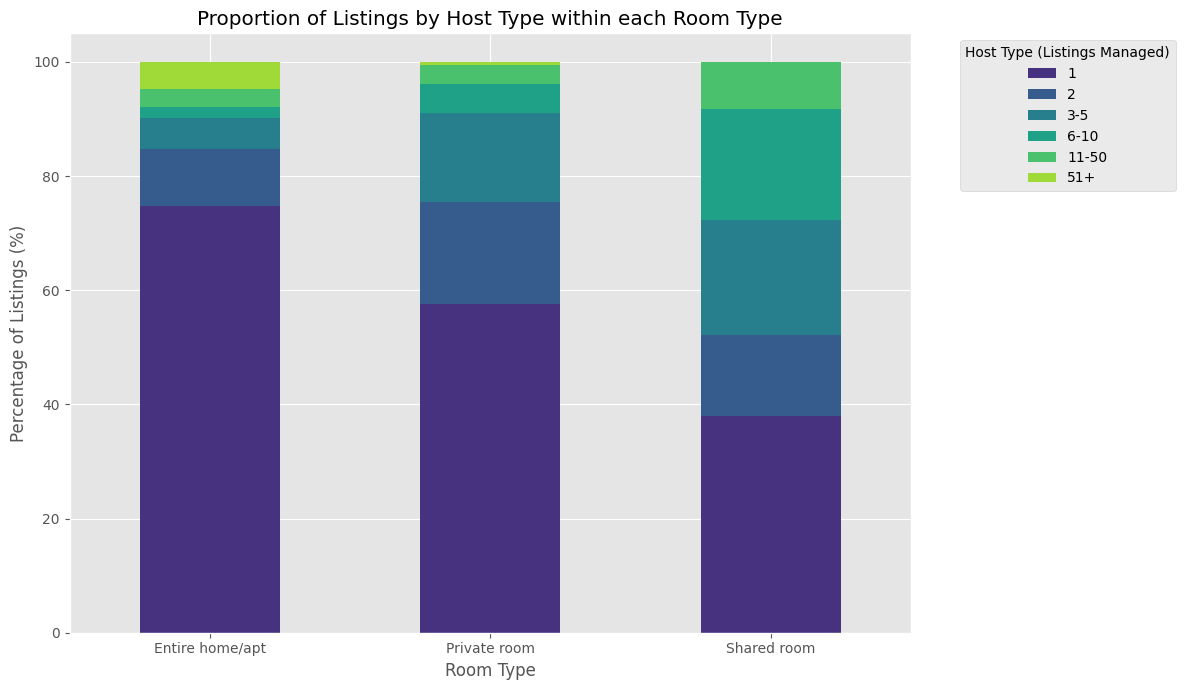

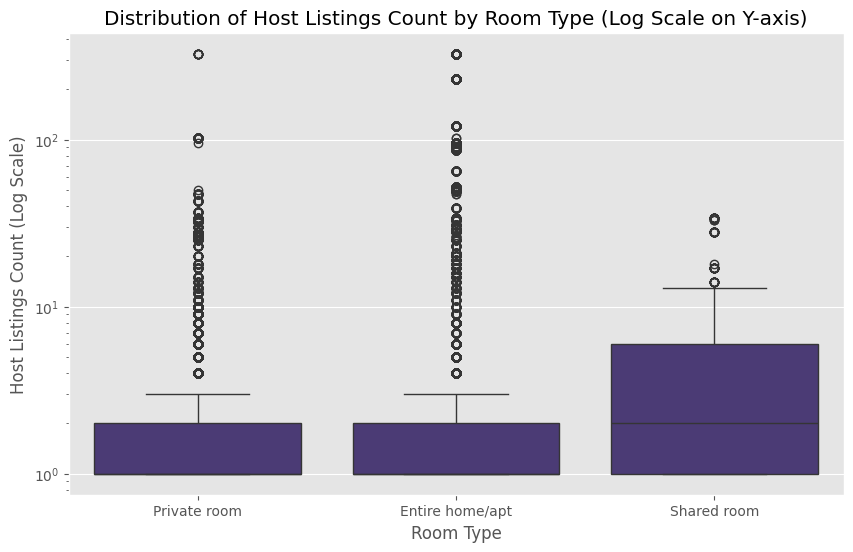

In [74]:
print("\n--- Host Type Distribution per room_type ---")

if 'host_type_category' in df.columns:
    # Proportions for stacked bar chart
    room_host_type_proportions = df.groupby('room_type')['host_type_category'].value_counts(normalize=True).mul(100).unstack(fill_value=0)
    print("\nProportions (%) of listings by host_type_category within each room_type:")
    print(room_host_type_proportions)

    room_host_type_proportions.plot(kind='bar', stacked=True, figsize=(12, 7))
    plt.title('Proportion of Listings by Host Type within each Room Type')
    plt.xlabel('Room Type')
    plt.ylabel('Percentage of Listings (%)')
    plt.xticks(rotation=0)
    plt.legend(title='Host Type (Listings Managed)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Column 'host_type_category' not created. Skipping this plot.")

# Boxplots of the original 'calculated_host_listings_count' by room_type
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='calculated_host_listings_count', data=df)
plt.yscale('log') # Apply log scale to y-axis
plt.title('Distribution of Host Listings Count by Room Type (Log Scale on Y-axis)')
plt.xlabel('Room Type')
plt.ylabel('Host Listings Count (Log Scale)')
plt.show()

--- Correlation Matrix for Price and Related Numerical Features ---


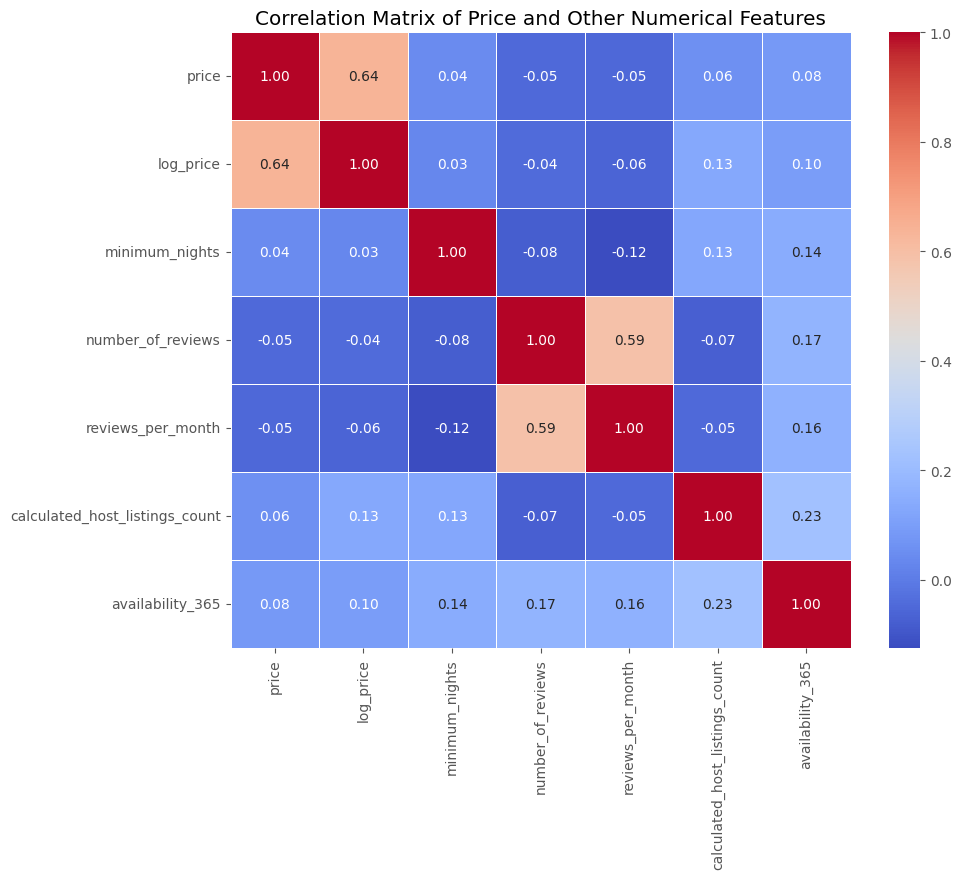

In [75]:
print("--- Correlation Matrix for Price and Related Numerical Features ---")

# Select numerical features that might correlate with price
numerical_features_for_corr = ['price', 'log_price', 'minimum_nights', 'number_of_reviews',
                               'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


if 'log_price' not in df.columns and 'price' in df.columns:
    df['log_price'] = np.log1p(df['price']) 
elif 'log_price' not in df.columns and 'price' not in df.columns:
    numerical_features_for_corr = [col for col in numerical_features_for_corr if col in df.columns and col != 'log_price']


correlation_matrix = df[numerical_features_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Price and Other Numerical Features')
plt.show()


--- Scatter Plot: log_price vs. number_of_reviews ---


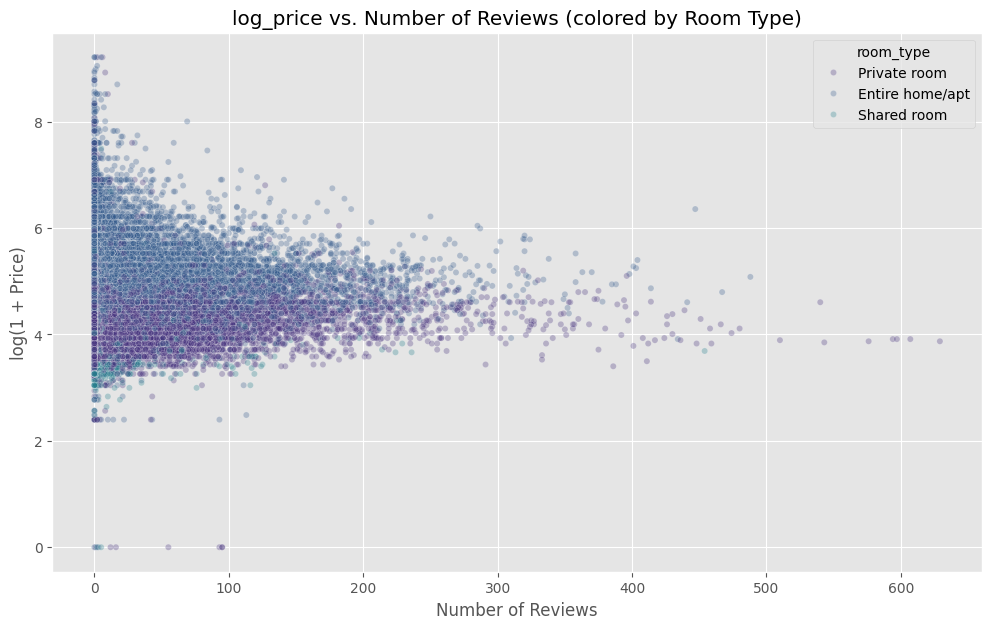

In [76]:
print("\n--- Scatter Plot: log_price vs. number_of_reviews ---")

if 'log_price' in df.columns and 'number_of_reviews' in df.columns and 'room_type' in df.columns:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(x='number_of_reviews', y='log_price', data=df, hue='room_type', alpha=0.3, s=20) # s for marker size
    plt.title('log_price vs. Number of Reviews (colored by Room Type)')
    plt.xlabel('Number of Reviews')
    plt.ylabel('log(1 + Price)')
    plt.show()
else:
    print("Skipping scatter plot: 'log_price', 'number_of_reviews', or 'room_type' not found.")



--- Scatter Plot: log_price vs. reviews_per_month ---


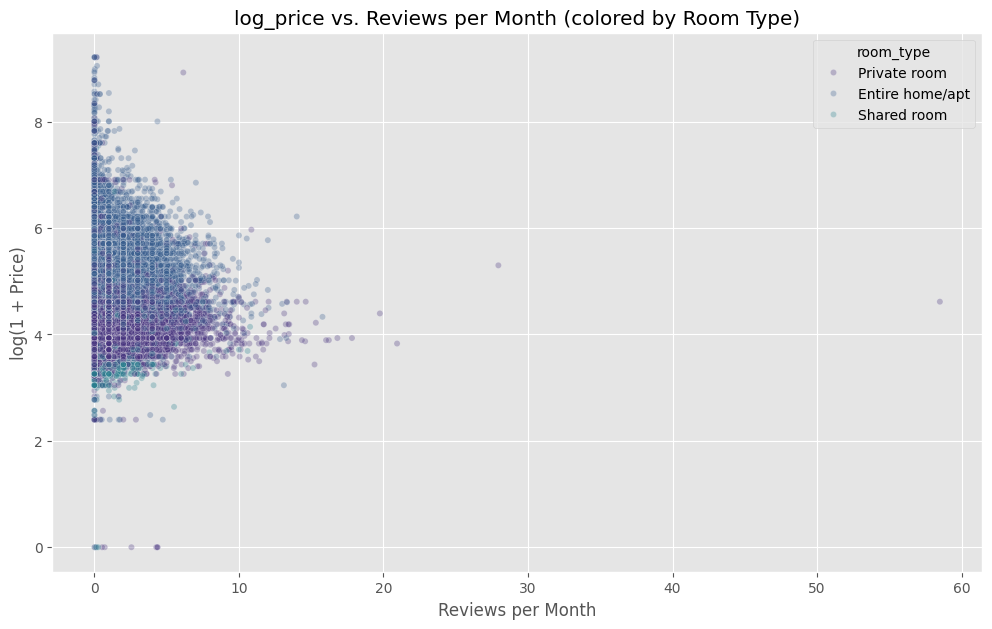

In [77]:
print("\n--- Scatter Plot: log_price vs. reviews_per_month ---")

if 'log_price' in df.columns and 'reviews_per_month' in df.columns and 'room_type' in df.columns:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(x='reviews_per_month', y='log_price', data=df, hue='room_type', alpha=0.3, s=20)
    plt.title('log_price vs. Reviews per Month (colored by Room Type)')
    plt.xlabel('Reviews per Month')
    plt.ylabel('log(1 + Price)')
    plt.show()
else:
    print("Skipping scatter plot: 'log_price', 'reviews_per_month', or 'room_type' not found.")



--- Scatter Plot: log_price vs. availability_365 ---


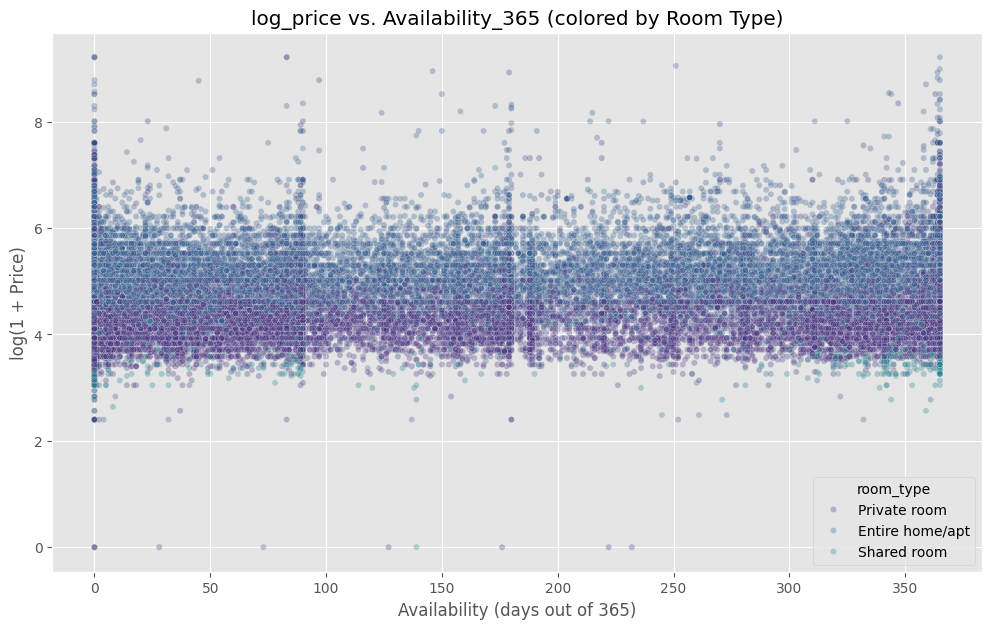

In [78]:
print("\n--- Scatter Plot: log_price vs. availability_365 ---")

if 'log_price' in df.columns and 'availability_365' in df.columns and 'room_type' in df.columns:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(x='availability_365', y='log_price', data=df, hue='room_type', alpha=0.3, s=20)
    plt.title('log_price vs. Availability_365 (colored by Room Type)')
    plt.xlabel('Availability (days out of 365)')
    plt.ylabel('log(1 + Price)')
    plt.show()
else:
    print("Skipping scatter plot: 'log_price', 'availability_365', or 'room_type' not found.")


--- Price vs. calculated_host_listings_count ---


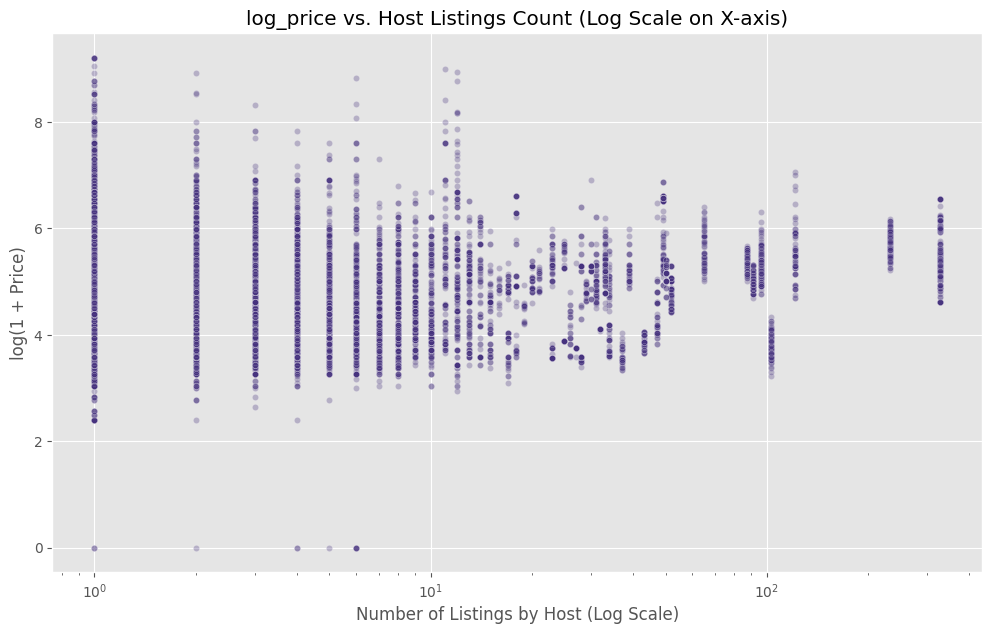

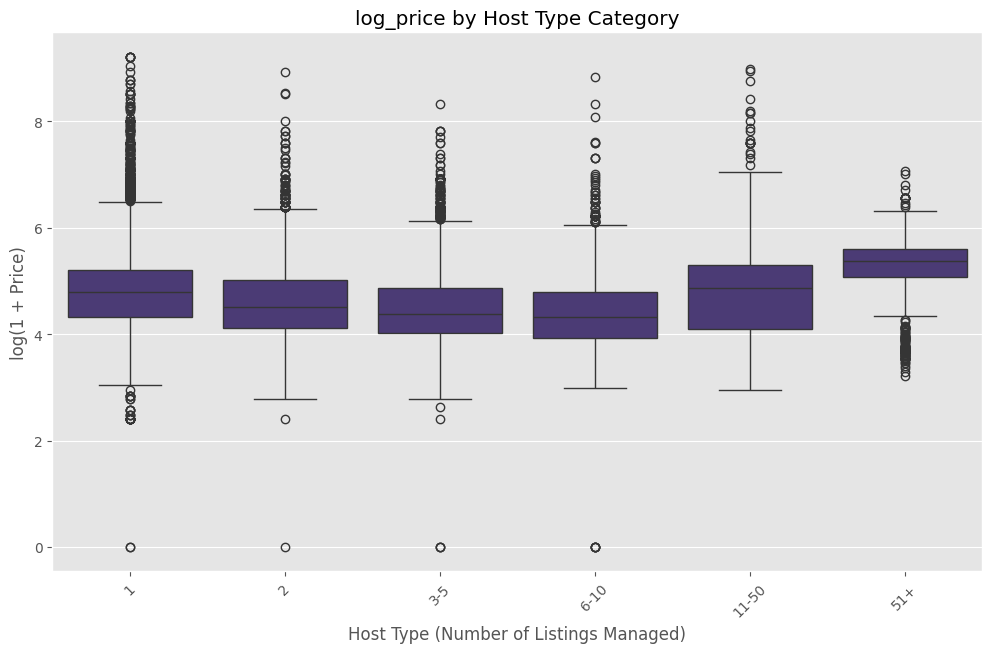

In [79]:
print("\n--- Price vs. calculated_host_listings_count ---")

if 'log_price' in df.columns and 'calculated_host_listings_count' in df.columns:
    plt.figure(figsize=(12, 7))
    temp_host_counts_for_log_viz = df[df['calculated_host_listings_count'] > 0]['calculated_host_listings_count']
    
    sns.scatterplot(x='calculated_host_listings_count', y='log_price', data=df, alpha=0.3, s=20)
    plt.xscale('log') # Log scale for x-axis due to skewness of host listings count
    plt.title('log_price vs. Host Listings Count (Log Scale on X-axis)')
    plt.xlabel('Number of Listings by Host (Log Scale)')
    plt.ylabel('log(1 + Price)')
    plt.show()

    if 'host_type_category' in df.columns:
        plt.figure(figsize=(12, 7))
        sns.boxplot(x='host_type_category', y='log_price', data=df, order=['1', '2', '3-5', '6-10', '11-50', '51+'])
        plt.title('log_price by Host Type Category')
        plt.xlabel('Host Type (Number of Listings Managed)')
        plt.ylabel('log(1 + Price)')
        plt.xticks(rotation=45)
        plt.show()
else:
    print("Skipping plot: 'log_price' or 'calculated_host_listings_count' not found.")

#### Summary of "Similarity" Feature Exploration (for `Neighbourhood` Characterization)

Our analysis of features crucial for defining the character of Airbnb offerings revealed the following:

* **Price Profile:**
    * We confirmed that the overall price distribution is heavily right-skewed (median $106, mean $153). Using a log transformation (`log_price`) proved essential for clearer visualization.
    * `room_type` emerged as a primary price driver, with 'Entire home/apt' (median $160) being substantially more expensive than 'Private room' ($70) and 'Shared room' ($45).
    * `neighbourhood_group` also significantly dictates price: 'Manhattan' (median $150) is the most expensive, followed by 'Brooklyn' ($90), then 'Queens' and 'Staten Island' (both $75), and the 'Bronx' ($65).
    * Importantly, we observed significant price variation even among the most common `neighbourhoods` within the same `neighbourhood_group` (e.g., in 'Manhattan', Midtown's median price of $210 starkly contrasts with Harlem's $89).
    * Our investigation into relationships showed that `price` has a weak linear correlation with `number_of_reviews` and `availability_365` but is strongly influenced by `room_type` and the broader location (`neighbourhood_group`).

* **Room Type Composition:**
    * The market is clearly dominated by 'Entire home/apt' (constituting approximately 52% of listings) and 'Private room' (around 45.7%), with 'Shared room' representing a small niche (about 2.4%).
    * We found that the mix of `room_type`s varies substantially by `neighbourhood_group`. For example, 'Manhattan' has a higher proportion of 'Entire home/apt' (~61%), whereas 'Queens' and the 'Bronx' feature more 'Private room' listings (~60%). 'Brooklyn' and 'Staten Island' present a more balanced mix.
    * This variation in room type composition extends down to specific popular `neighbourhoods` (e.g., within 'Manhattan', Harlem is characterized by mostly 'Private rooms', while the Upper West Side is dominated by 'Entire home/apt').

* **Minimum Nights Profile:**
    * The analysis of `minimum_nights` also revealed a highly right-skewed distribution (median 3 nights, mean ~7 nights, with a max of 1250 nights). This indicates that while most listings (approximately 75%) require a minimum stay of 5 nights or less, catering to short stays, there's a notable segment requiring much longer commitments.
    * Median `minimum_nights` are consistently short across all `neighbourhood_group`s (2-3 nights). However, 'Manhattan' and 'Brooklyn' exhibit higher mean `minimum_nights`, which we attribute to a greater prevalence of listings with very long minimum stay requirements in these areas.

* **Host Profile (`calculated_host_listings_count`):**
    * Our findings show that the vast majority of listings (~66%) are managed by hosts with only a single property, and about 80% come from hosts managing 1 or 2 listings.
    * A "long tail" of professional hosts or property managers with many listings (up to 327 by one host) is also present, though they represent a smaller percentage of total listings.
    * Interestingly, the distribution of these host types appears to vary by `room_type`. For instance, 'Entire home/apt' listings are offered by many single hosts but also have the largest share from very large professional operators. 'Private rooms' seem more common among small to mid-size hosts, and 'Shared rooms' often involve hosts managing several such listings. We also noted an observation that price ranges might be more standardized for listings managed by larger hosts.

* **Implications for Defining `Neighbourhood` Similarity (Our Perspective):**
    * This deep dive confirms that to define "characteristically similar `neighbourhoods`," we must construct a rich profile for each `neighbourhood`. This profile should be based on aggregated features that reflect its typical offerings.
    * Key components we've identified for these profiles include: the `neighbourhood's` typical price level(s) and distribution, its dominant mix of available `room_type`s, its common `minimum_nights` requirements, and potentially the predominant host profile (e.g., prevalence of single-listing vs. professional hosts).
    * The EDA strongly suggests these characteristics vary significantly across `neighbourhoods`, even within the same `neighbourhood_group`, making them crucial for distinguishing `neighbourhood` types for our recommendation system.

### 4.3. Deeper Dive: Understanding `neighbourhood_group` and `neighbourhood` Variations
*Building on the individual feature analyses, this section synthesizes these characteristics at the `neighbourhood_group` level and then explores the variation among `neighbourhoods` within each group. This helps us understand both broad typologies and local specificities.*

--- Price Profile per Neighbourhood Group ---
Price profile (min, 25th, median, mean, 75th, max, std, count) per neighbourhood_group:
                     min  25th_percentile  median        mean  \
neighbourhood_group                                             
Manhattan              0             95.0   150.0  196.875814   
Brooklyn               0             60.0    90.0  124.383207   
Queens                10             50.0    75.0   99.517649   
Staten Island         13             50.0    75.0  114.812332   
Bronx                  0             45.0    65.0   87.496792   

                     75th_percentile    max         std  count  
neighbourhood_group                                             
Manhattan                      220.0  10000  291.383183  21661  
Brooklyn                       150.0  10000  186.873538  20104  
Queens                         110.0  10000  167.102155   5666  
Staten Island                  110.0   5000  277.620403    373  
Bronx               

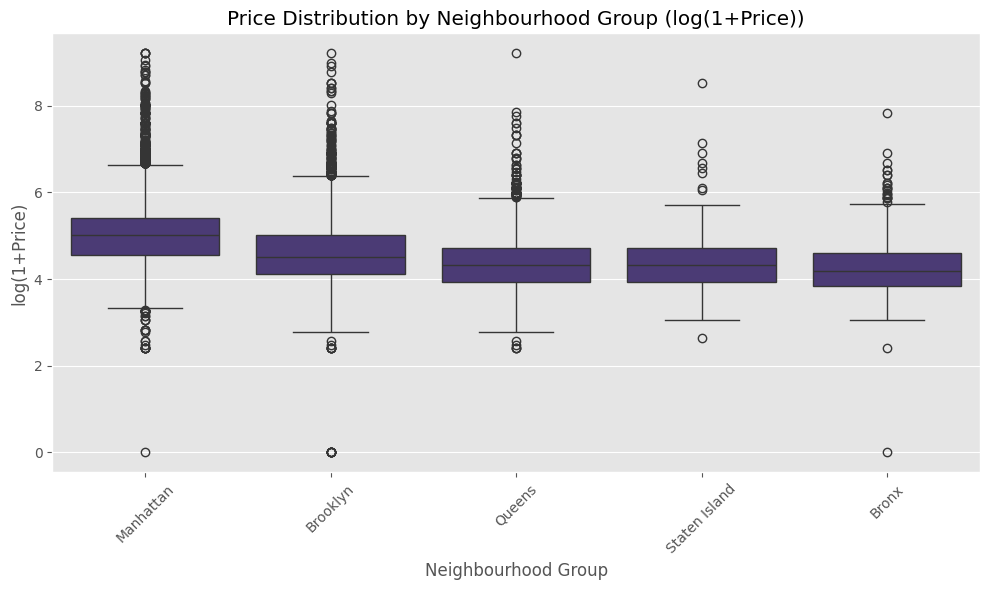

In [80]:
print("--- Price Profile per Neighbourhood Group ---")

# Define custom quantiles for price range
def q1(x): return x.quantile(0.25)
def q3(x): return x.quantile(0.75)

price_profile_group = df.groupby('neighbourhood_group')['price'].agg(
    ['min', q1, 'median', 'mean', q3, 'max', 'std', 'count']
).sort_values(by='median', ascending=False)

price_profile_group.rename(columns={'q1': '25th_percentile', 'q3': '75th_percentile'}, inplace=True)

print("Price profile (min, 25th, median, mean, 75th, max, std, count) per neighbourhood_group:")
print(price_profile_group)

# Visualization (Box plot - you might have done this in price analysis, but good to see here too)
# Using log_price for better visualization if available and price is skewed
price_col_to_plot = 'log_price' if 'log_price' in df.columns else 'price'
y_label = 'log(1+Price)' if price_col_to_plot == 'log_price' else 'Price'

plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbourhood_group', y=price_col_to_plot, data=df, order=price_profile_group.index)
plt.title(f'Price Distribution by Neighbourhood Group ({y_label})')
plt.xlabel('Neighbourhood Group')
plt.ylabel(y_label)
plt.xticks(rotation=45)
if price_col_to_plot == 'price':
    pass
plt.tight_layout()
plt.show()


--- Availability Profile per Neighbourhood Group ---
Availability_365 profile (min, 25th, median, mean, 75th, max, std, count) per neighbourhood_group:
                     min  25th_percentile  median        mean  \
neighbourhood_group                                             
Brooklyn               0              0.0    28.0  100.232292   
Manhattan              0              0.0    36.0  111.979410   
Queens                 0              2.0    98.0  144.451818   
Bronx                  0             37.0   148.0  165.758937   
Staten Island          0             78.0   219.0  199.678284   

                     75th_percentile  max         std  count  
neighbourhood_group                                           
Brooklyn                       188.0  365  126.275775  20104  
Manhattan                      230.0  365  132.677836  21661  
Queens                         286.0  365  135.538597   5666  
Bronx                          313.5  365  135.247098   1091  
Staten Island

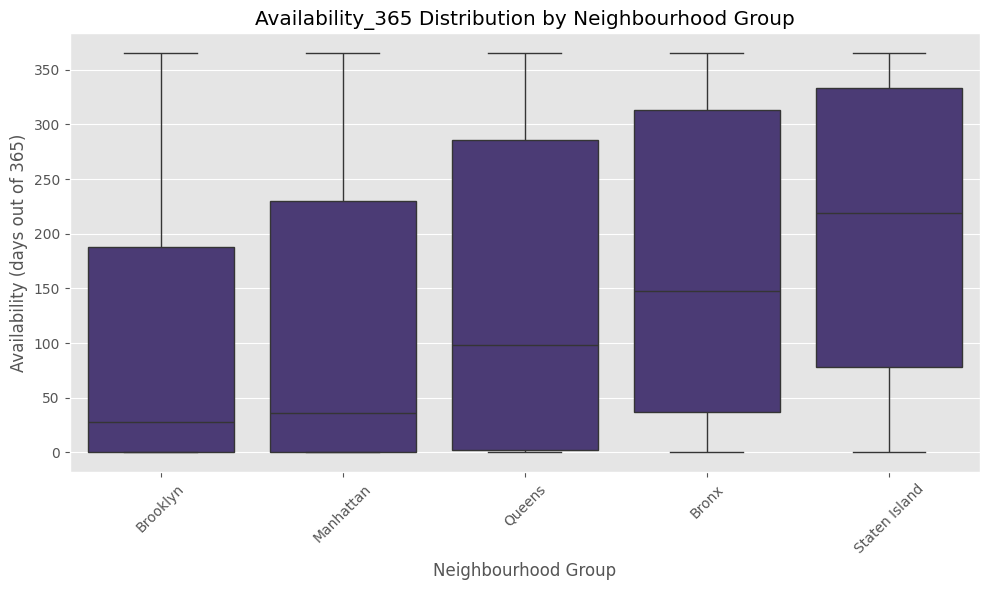

In [81]:
print("\n--- Availability Profile per Neighbourhood Group ---")

availability_profile_group = df.groupby('neighbourhood_group')['availability_365'].agg(
    ['min', q1, 'median', 'mean', q3, 'max', 'std', 'count']
).sort_values(by='median', ascending=True) # Sorted by typically least available

availability_profile_group.rename(columns={'q1': '25th_percentile', 'q3': '75th_percentile'}, inplace=True)

print("Availability_365 profile (min, 25th, median, mean, 75th, max, std, count) per neighbourhood_group:")
print(availability_profile_group)

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbourhood_group', y='availability_365', data=df, order=availability_profile_group.index)
plt.title('Availability_365 Distribution by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Availability (days out of 365)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


--- Dominant Room Type(s) per Neighbourhood Group ---
Proportions (%) of room_types within each neighbourhood_group:
room_type            Entire home/apt  Private room  Shared room
neighbourhood_group                                            
Bronx                          34.74         59.76         5.50
Brooklyn                       47.55         50.40         2.05
Manhattan                      60.93         36.85         2.22
Queens                         36.99         59.51         3.49
Staten Island                  47.18         50.40         2.41

Dominant room types (top 1 or 2 based on count):

Bronx:
  - Private room: 652 listings (59.76%)
  - Entire home/apt: 379 listings (34.74%)

Brooklyn:
  - Private room: 10132 listings (50.40%)
  - Entire home/apt: 9559 listings (47.55%)

Manhattan:
  - Entire home/apt: 13199 listings (60.93%)
  - Private room: 7982 listings (36.85%)

Queens:
  - Private room: 3372 listings (59.51%)
  - Entire home/apt: 2096 listings (36.99%)

Sta

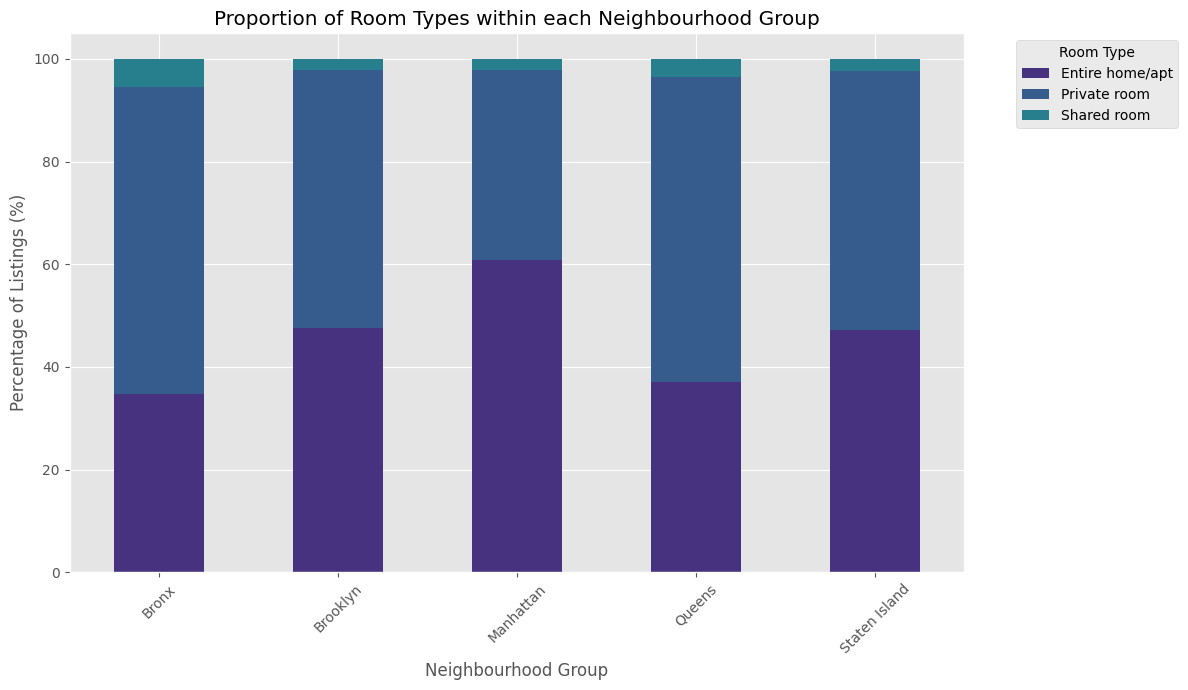

In [82]:
print("\n--- Dominant Room Type(s) per Neighbourhood Group ---")

# Calculate proportions of each room_type within each neighbourhood_group
room_type_proportions_group = pd.crosstab(df['neighbourhood_group'], df['room_type'], normalize='index') * 100
room_type_proportions_group = room_type_proportions_group.round(2) # Round for cleaner display

print("Proportions (%) of room_types within each neighbourhood_group:")
print(room_type_proportions_group)

# To find the top 1 or 2 dominant types programmatically:
print("\nDominant room types (top 1 or 2 based on count):")
for group, data in df.groupby('neighbourhood_group'):
    print(f"\n{group}:")
    top_room_types = data['room_type'].value_counts().nlargest(2) # Get top 2
    for room_type, count in top_room_types.items():
        percentage = (count / len(data)) * 100
        print(f"  - {room_type}: {count} listings ({percentage:.2f}%)")


# Visualization (Stacked Bar Chart - you might have done this, but good for profile summary)
if not room_type_proportions_group.empty:
    room_type_proportions_group.plot(kind='bar', stacked=True, figsize=(12, 7))
    plt.title('Proportion of Room Types within each Neighbourhood Group')
    plt.xlabel('Neighbourhood Group')
    plt.ylabel('Percentage of Listings (%)')
    plt.xticks(rotation=45)
    plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


--- Review Volume Profile per Neighbourhood Group ---

--- Profile for 'number_of_reviews' (Total Reviews Received) ---
                        sum  25th_percentile  median       mean  \
neighbourhood_group                                               
Staten Island         11541              1.0    12.0  30.941019   
Bronx                 28371              1.0     9.0  26.004583   
Queens               156950              1.0     7.0  27.700318   
Brooklyn             486574              1.0     6.0  24.202845   
Manhattan            454569              1.0     4.0  20.985596   

                     75th_percentile  max  count  
neighbourhood_group                               
Staten Island                   42.0  333    373  
Bronx                           32.0  321   1091  
Queens                          32.0  629   5666  
Brooklyn                        25.0  488  20104  
Manhattan                       19.0  607  21661  


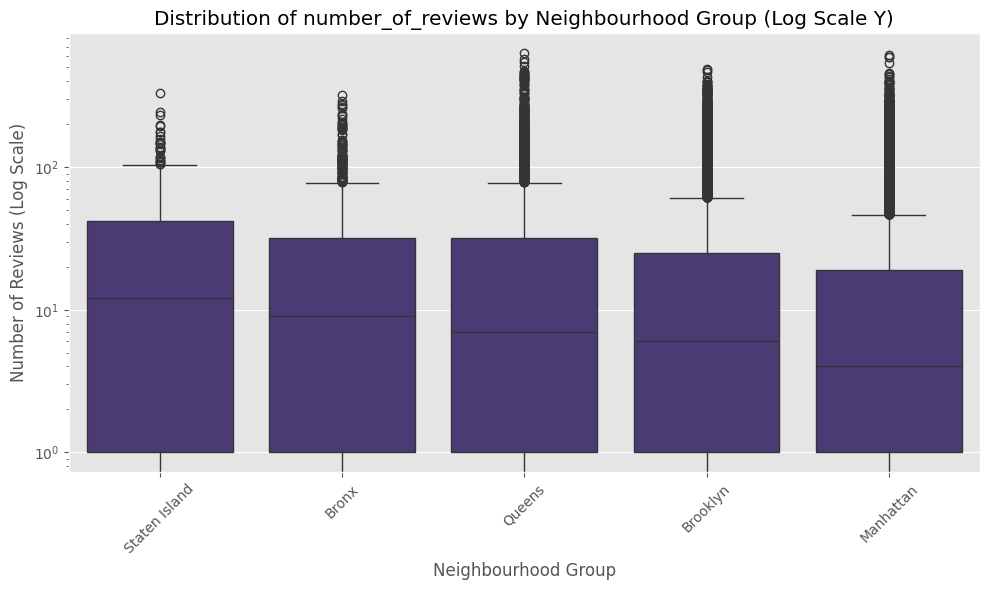


--- Profile for 'reviews_per_month' (Review Activity Rate) ---
                          sum  25th_percentile  median      mean  \
neighbourhood_group                                                
Staten Island          587.99             0.26    1.00  1.576381   
Bronx                 1609.94             0.12    0.87  1.475655   
Queens                8879.05             0.08    0.76  1.567076   
Brooklyn             21104.98             0.05    0.38  1.049790   
Manhattan            21158.08             0.02    0.28  0.976782   

                     75th_percentile    max  count  
neighbourhood_group                                 
Staten Island                 2.3100  10.12    373  
Bronx                         2.3600  10.34   1091  
Queens                        2.3075  20.94   5666  
Brooklyn                      1.5500  14.00  20104  
Manhattan                     1.3000  58.50  21661  


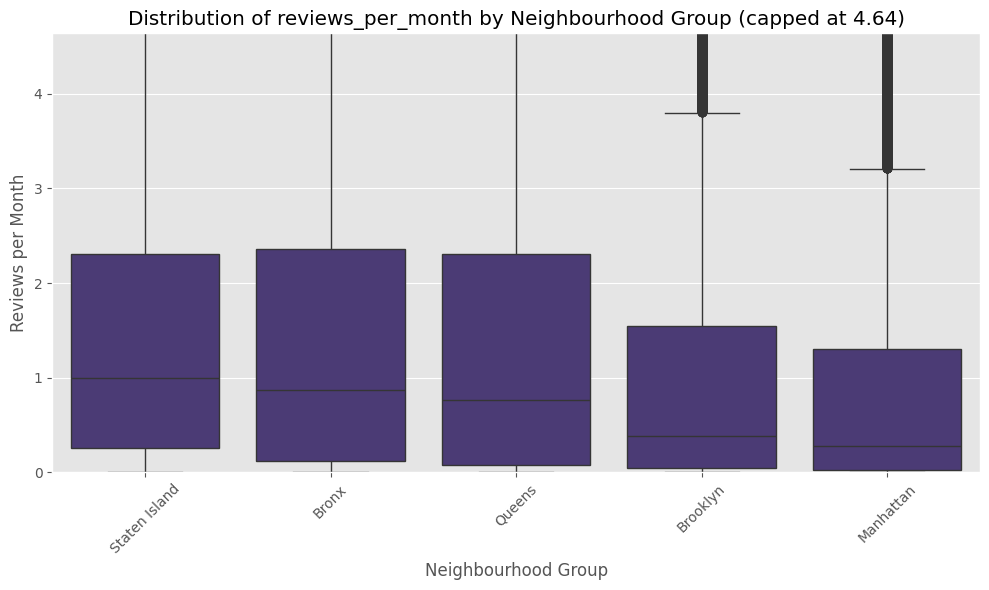

In [83]:
print("\n--- Review Volume Profile per Neighbourhood Group ---")

print("\n--- Profile for 'number_of_reviews' (Total Reviews Received) ---")
review_count_profile_group = df.groupby('neighbourhood_group')['number_of_reviews'].agg(
    ['sum', q1, 'median', 'mean', q3, 'max', 'count'] # Sum might be interesting too
).sort_values(by='median', ascending=False)
review_count_profile_group.rename(columns={'q1': '25th_percentile', 'q3': '75th_percentile'}, inplace=True)
print(review_count_profile_group)

plt.figure(figsize=(10,6))
sns.boxplot(x='neighbourhood_group', y='number_of_reviews', data=df, order=review_count_profile_group.index)
plt.yscale('log') # Use log scale due to skewness
plt.title('Distribution of number_of_reviews by Neighbourhood Group (Log Scale Y)')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Number of Reviews (Log Scale)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


print("\n--- Profile for 'reviews_per_month' (Review Activity Rate) ---")
# Ensure 'reviews_per_month' has NaNs filled with 0 as per earlier EDA steps
rpm_profile_group = df.groupby('neighbourhood_group')['reviews_per_month'].agg(
    ['sum', q1, 'median', 'mean', q3, 'max', 'count']
).sort_values(by='median', ascending=False)
rpm_profile_group.rename(columns={'q1': '25th_percentile', 'q3': '75th_percentile'}, inplace=True)
print(rpm_profile_group)

plt.figure(figsize=(10,6))
sns.boxplot(x='neighbourhood_group', y='reviews_per_month', data=df, order=rpm_profile_group.index)
upper_rpm_viz_limit = df[df['reviews_per_month'] > 0]['reviews_per_month'].quantile(0.95) # 95th percentile of non-zero values
if pd.notna(upper_rpm_viz_limit) and upper_rpm_viz_limit > 0 : # Check if limit is valid
    plt.ylim(0, upper_rpm_viz_limit)
plt.title(f'Distribution of reviews_per_month by Neighbourhood Group (capped at {upper_rpm_viz_limit:.2f})')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Reviews per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

--- Intra-neighbourhood Variation: Price (log_price) ---


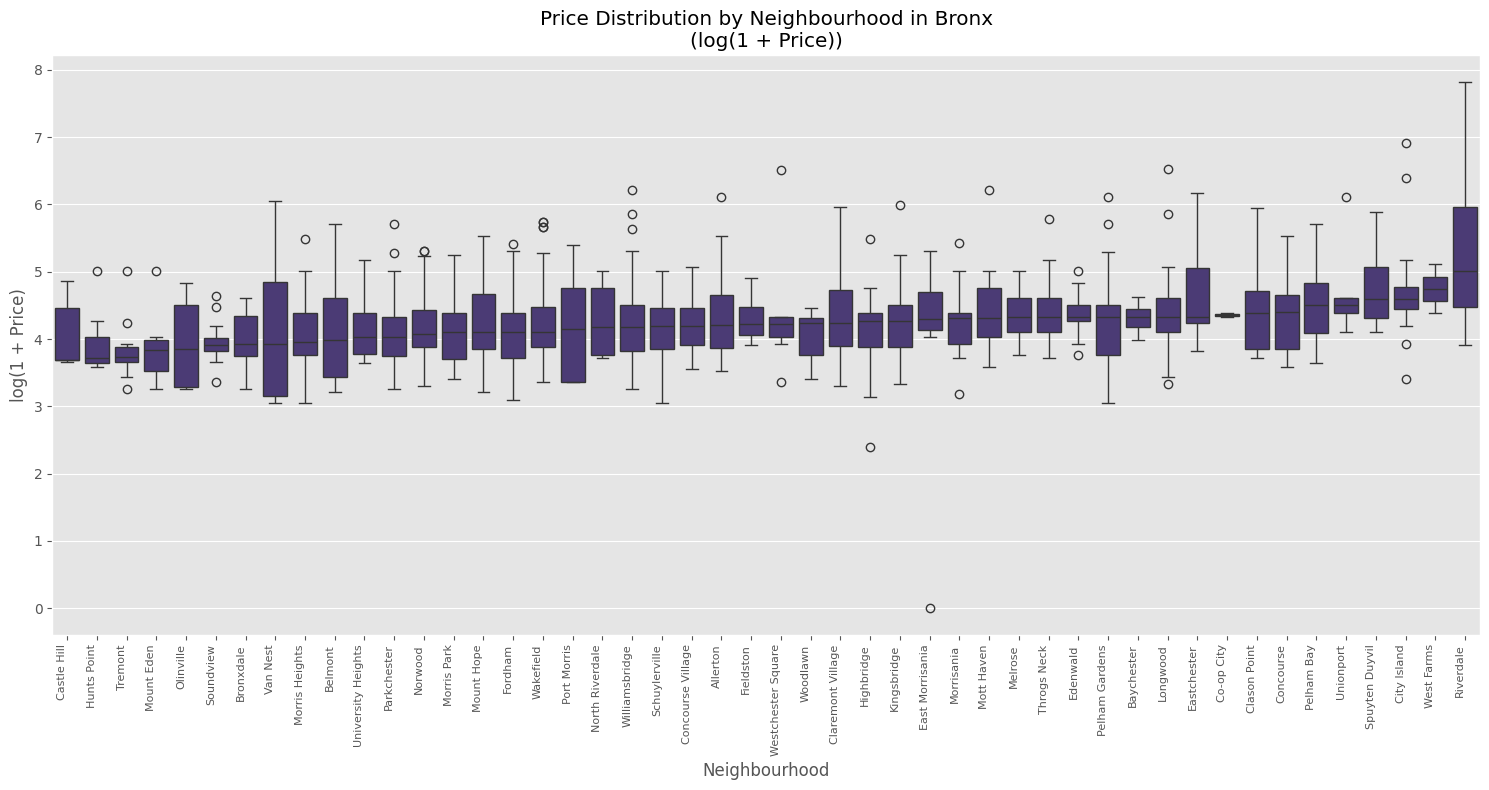

Descriptive statistics for log_price in Bronx (Top 5 neighbourhoods by median log_price):
                  median      mean  count       std
neighbourhood                                      
Riverdale       5.017280  5.299470     11  1.209458
West Farms      4.747007  4.747007      2  0.516160
City Island     4.589734  4.733983     18  0.799273
Spuyten Duyvil  4.588909  4.794392      4  0.782122
Unionport       4.510860  4.678360      7  0.656115
--------------------------------------------------


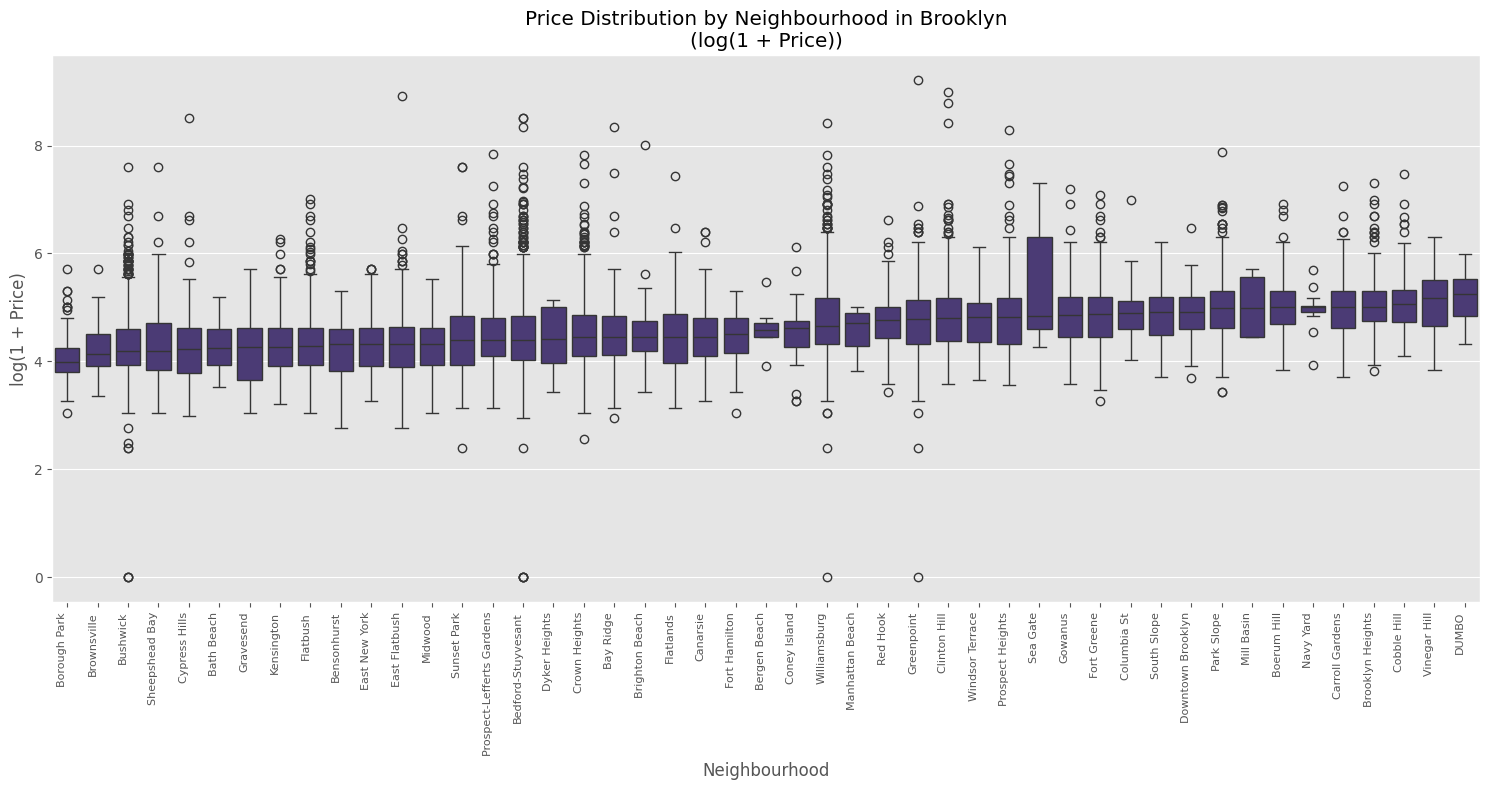

Descriptive statistics for log_price in Brooklyn (Top 5 neighbourhoods by median log_price):
                    median      mean  count       std
neighbourhood                                        
DUMBO             5.247024  5.202456     36  0.410975
Vinegar Hill      5.170484  5.092104     34  0.561001
Cobble Hill       5.056246  5.115996     99  0.619984
Carroll Gardens   5.017280  5.006536    233  0.552758
Brooklyn Heights  5.017280  5.129429    154  0.592269
--------------------------------------------------


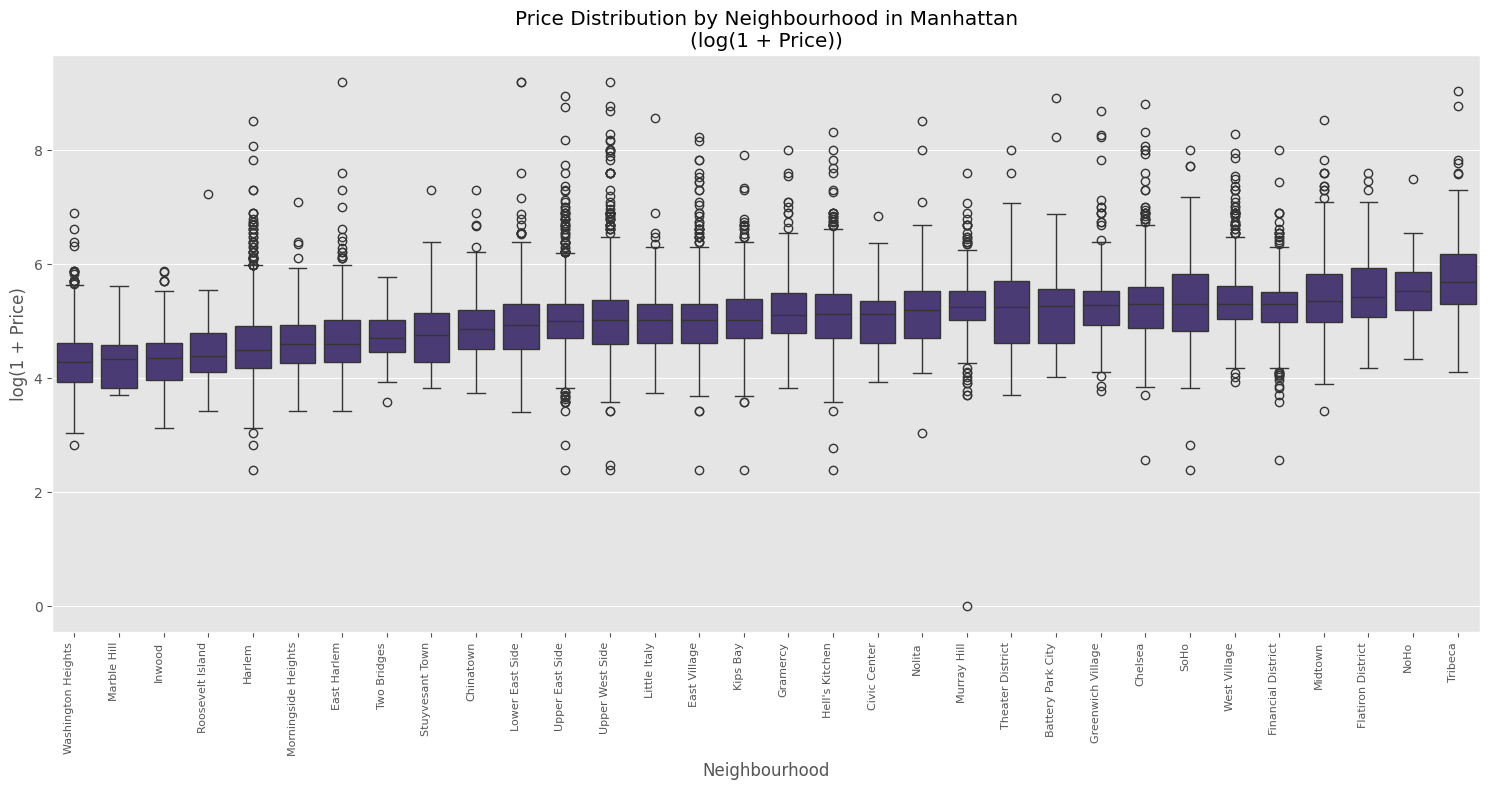

Descriptive statistics for log_price in Manhattan (Top 5 neighbourhoods by median log_price):
                      median      mean  count       std
neighbourhood                                          
Tribeca             5.690359  5.759137    177  0.805505
NoHo                5.525453  5.534596     78  0.538355
Flatiron District   5.420535  5.541792     80  0.717936
Midtown             5.351858  5.421864   1545  0.635997
Financial District  5.303305  5.276188    744  0.521640
--------------------------------------------------


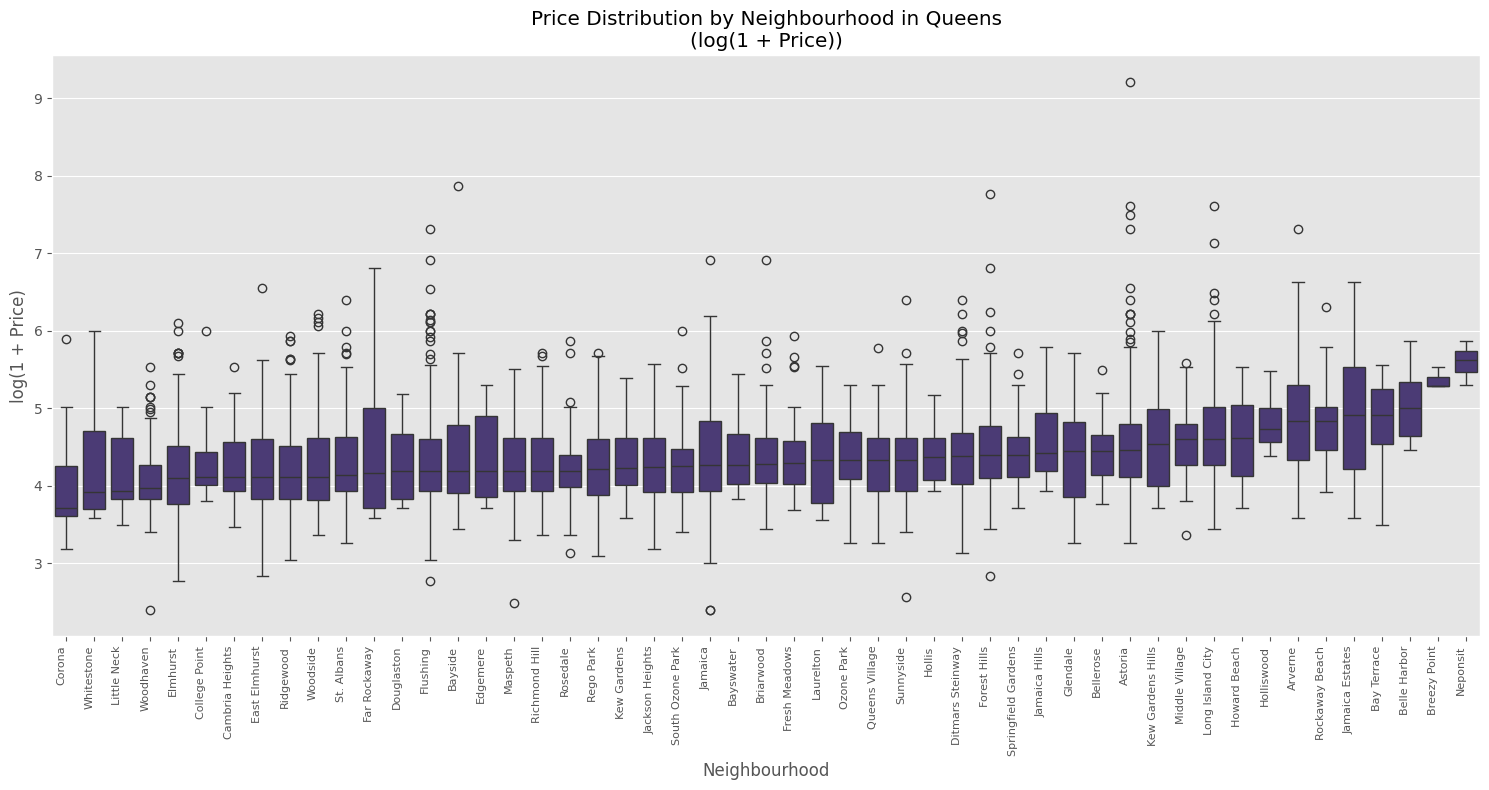

Descriptive statistics for log_price in Queens (Top 5 neighbourhoods by median log_price):
                   median      mean  count       std
neighbourhood                                       
Neponsit         5.616771  5.593621      3  0.279461
Breezy Point     5.278115  5.360561      3  0.142801
Belle Harbor     5.006418  5.037527      8  0.501164
Bay Terrace      4.912763  4.772791      6  0.743711
Jamaica Estates  4.912655  4.895921     19  0.804033
--------------------------------------------------


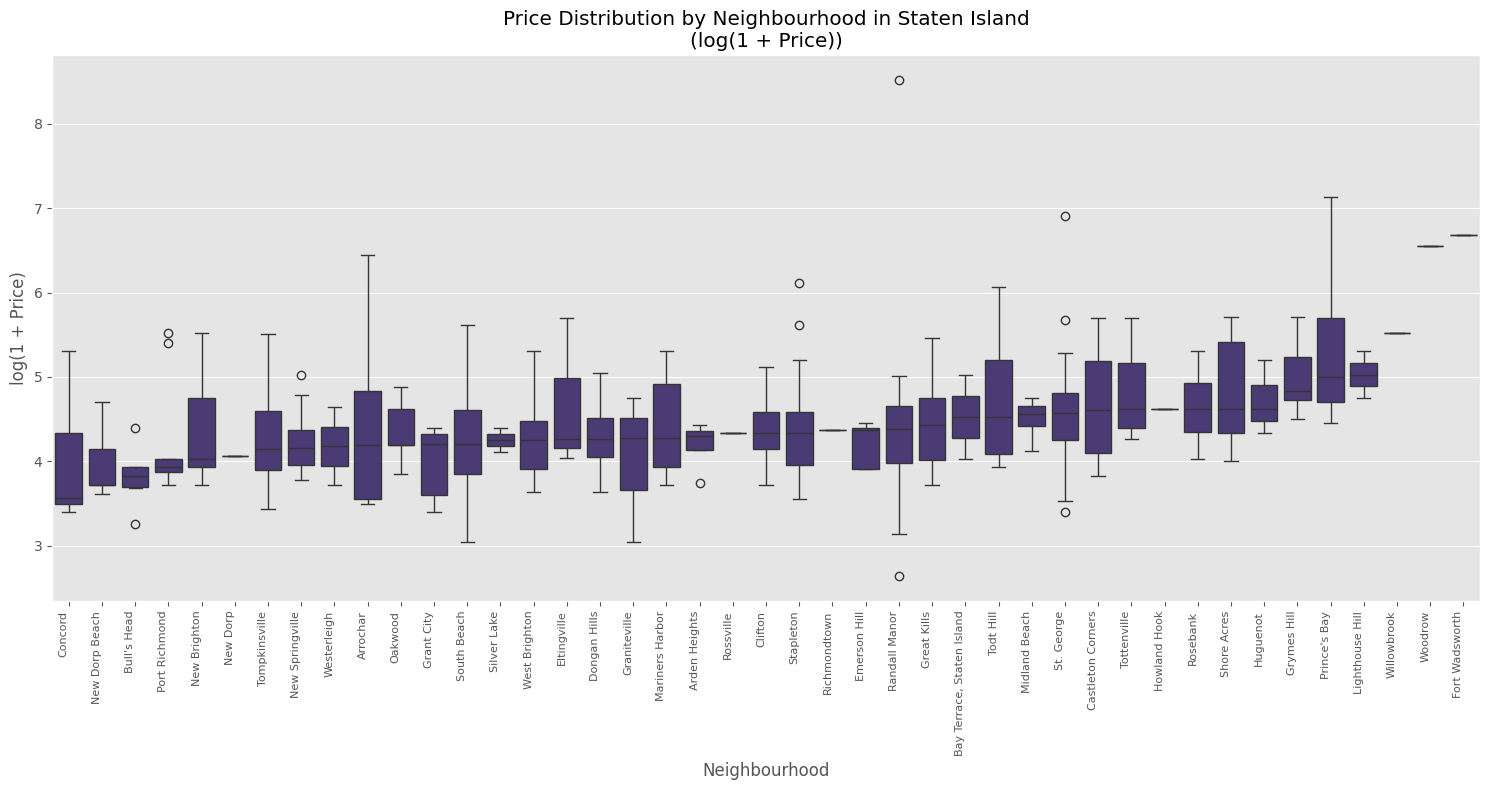

Descriptive statistics for log_price in Staten Island (Top 5 neighbourhoods by median log_price):
                   median      mean  count       std
neighbourhood                                       
Fort Wadsworth   6.685861  6.685861      1       NaN
Woodrow          6.552508  6.552508      1       NaN
Willowbrook      5.521461  5.521461      1       NaN
Lighthouse Hill  5.028448  5.028448      2  0.388707
Prince's Bay     5.002435  5.397729      4  1.198453
--------------------------------------------------


In [84]:
print("--- Intra-neighbourhood Variation: Price (log_price) ---")

if 'log_price' not in df.columns:
    print("Warning: 'log_price' column not found. Please create it first for better price visualization.")
    # As a fallback, try to use original 'price' but it might be heavily skewed
    price_col_to_plot = 'price'
    price_y_label = 'Price (Original Scale - may be skewed)'
else:
    price_col_to_plot = 'log_price'
    price_y_label = 'log(1 + Price)'


for group_name, group_df in df.groupby('neighbourhood_group'):
    plt.figure(figsize=(15, 8)) # Adjust size as needed
    
    ordered_neighbourhoods = group_df.groupby('neighbourhood')[price_col_to_plot].median().sort_values().index
    
    sns.boxplot(x='neighbourhood', y=price_col_to_plot, data=group_df, order=ordered_neighbourhoods)
    
    plt.title(f'Price Distribution by Neighbourhood in {group_name}\n({price_y_label})')
    plt.xlabel('Neighbourhood')
    plt.ylabel(price_y_label)
    plt.xticks(rotation=90, ha='right', fontsize=8) # Rotate labels for readability
    plt.tight_layout() # Adjust layout to make room for labels
    plt.show()
    
    print(f"Descriptive statistics for {price_col_to_plot} in {group_name} (Top 5 neighbourhoods by median {price_col_to_plot}):")
    top_5_hoods_price_stats = group_df.groupby('neighbourhood')[price_col_to_plot].agg(['median', 'mean', 'count', 'std']).loc[ordered_neighbourhoods[-5:]].sort_values('median', ascending=False)
    print(top_5_hoods_price_stats)
    print("-" * 50)


--- Intra-neighbourhood Variation: Listing Types (Room Type Proportions) ---


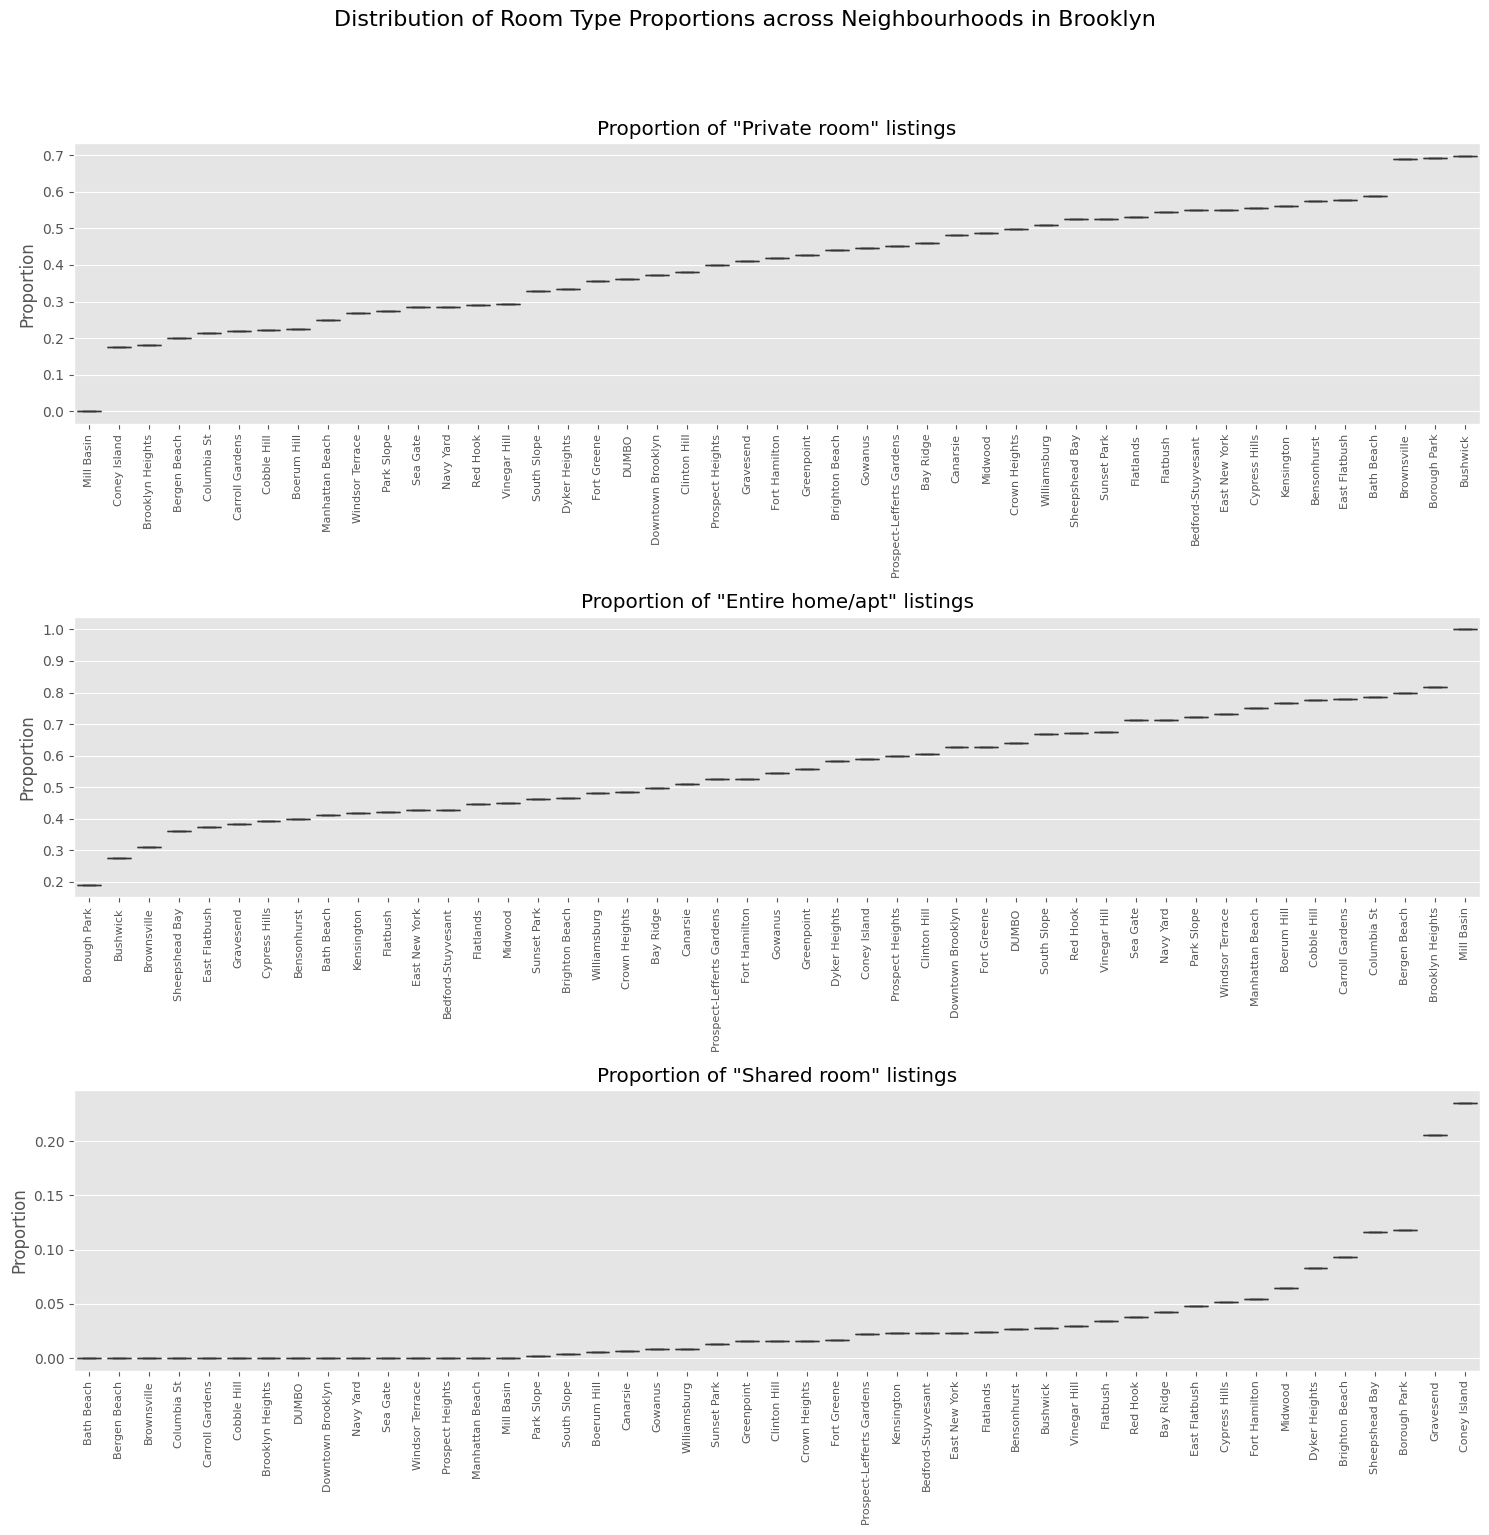

Summary of 'Entire home/apt' proportions in Brooklyn (example):
room_type  Entire home/apt
count            47.000000
mean              0.561625
std               0.168534
min               0.191176
25%               0.427492
50%               0.546559
75%               0.695378
max               1.000000
--------------------------------------------------


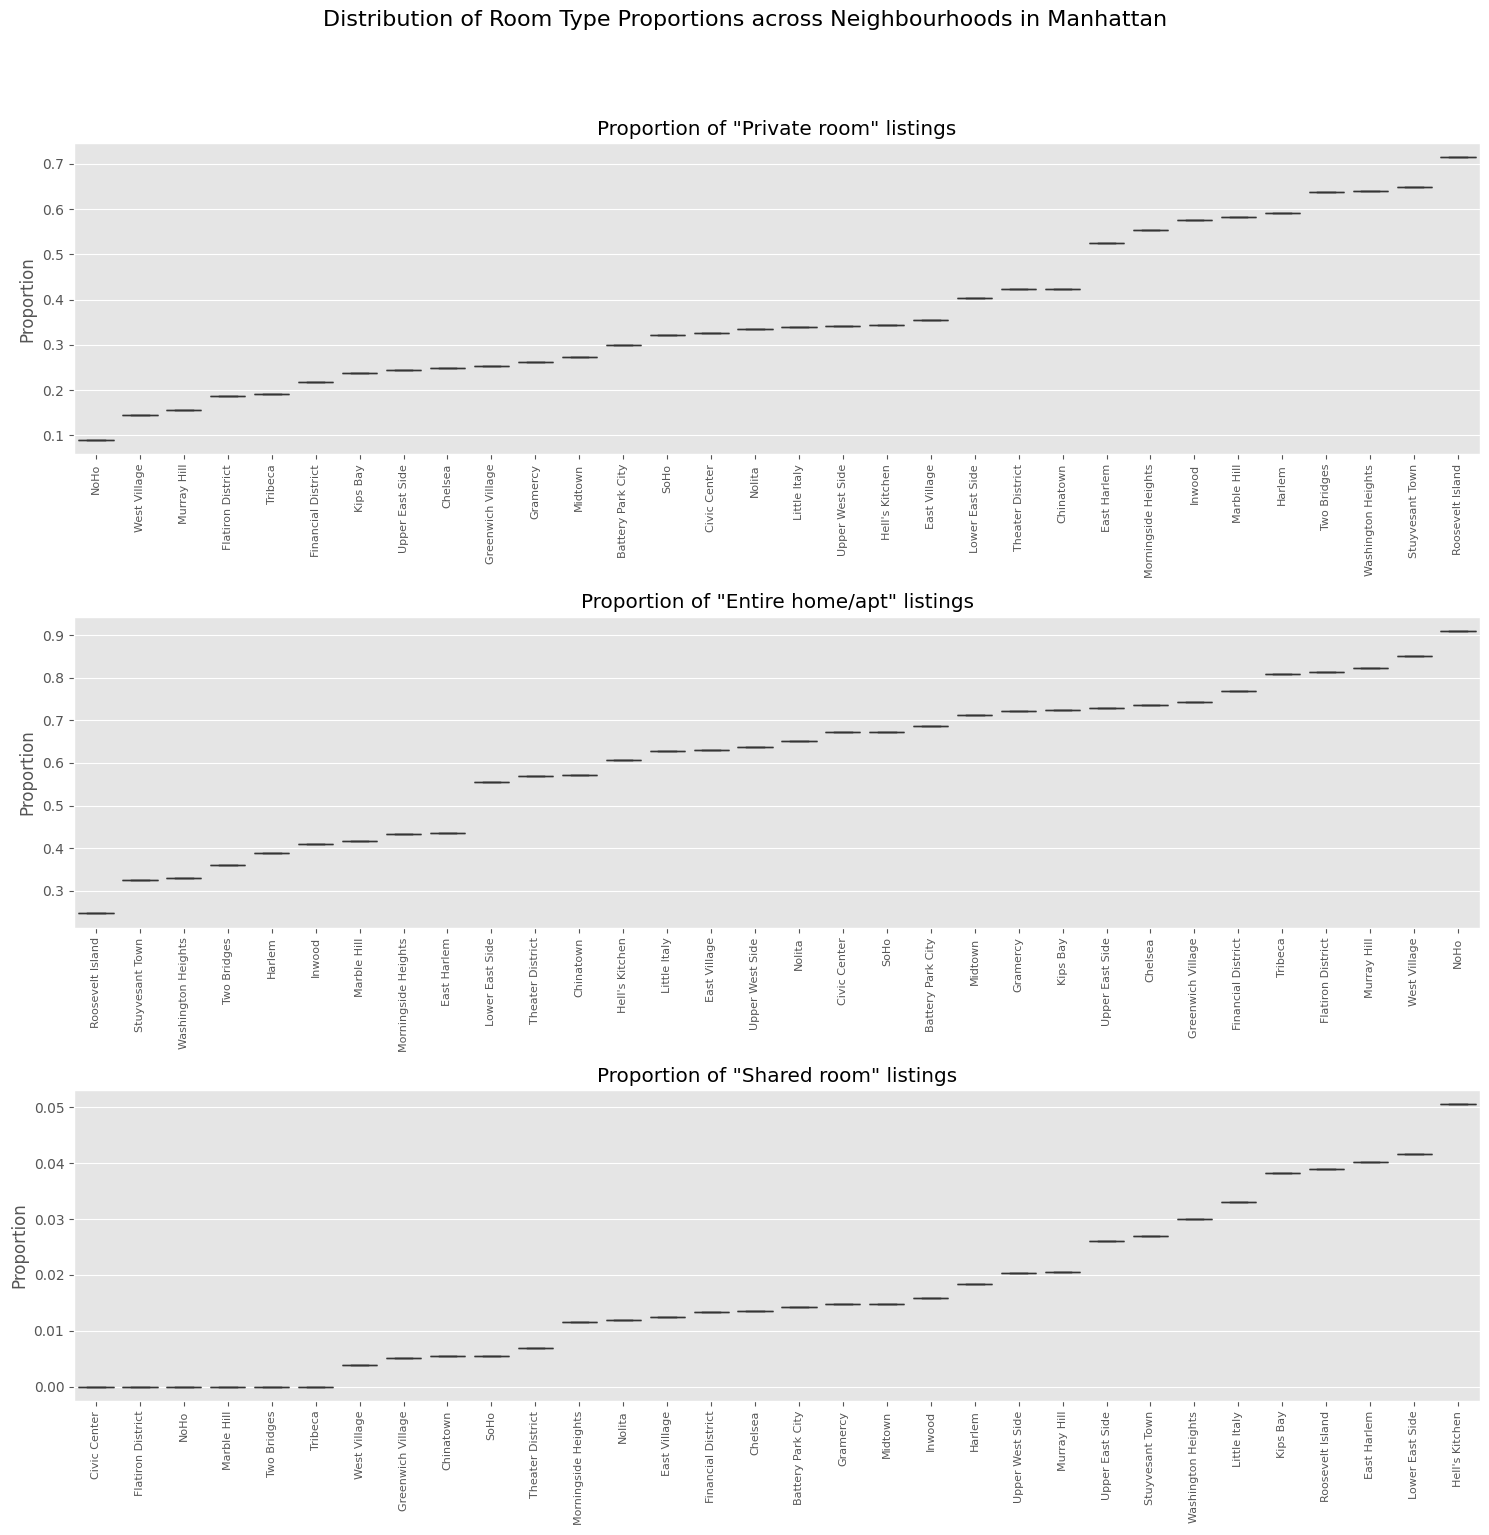

Summary of 'Entire home/apt' proportions in Manhattan (example):
room_type  Entire home/apt
count            32.000000
mean              0.611414
std               0.174828
min               0.246753
25%               0.434702
50%               0.644707
75%               0.730627
max               0.910256
--------------------------------------------------


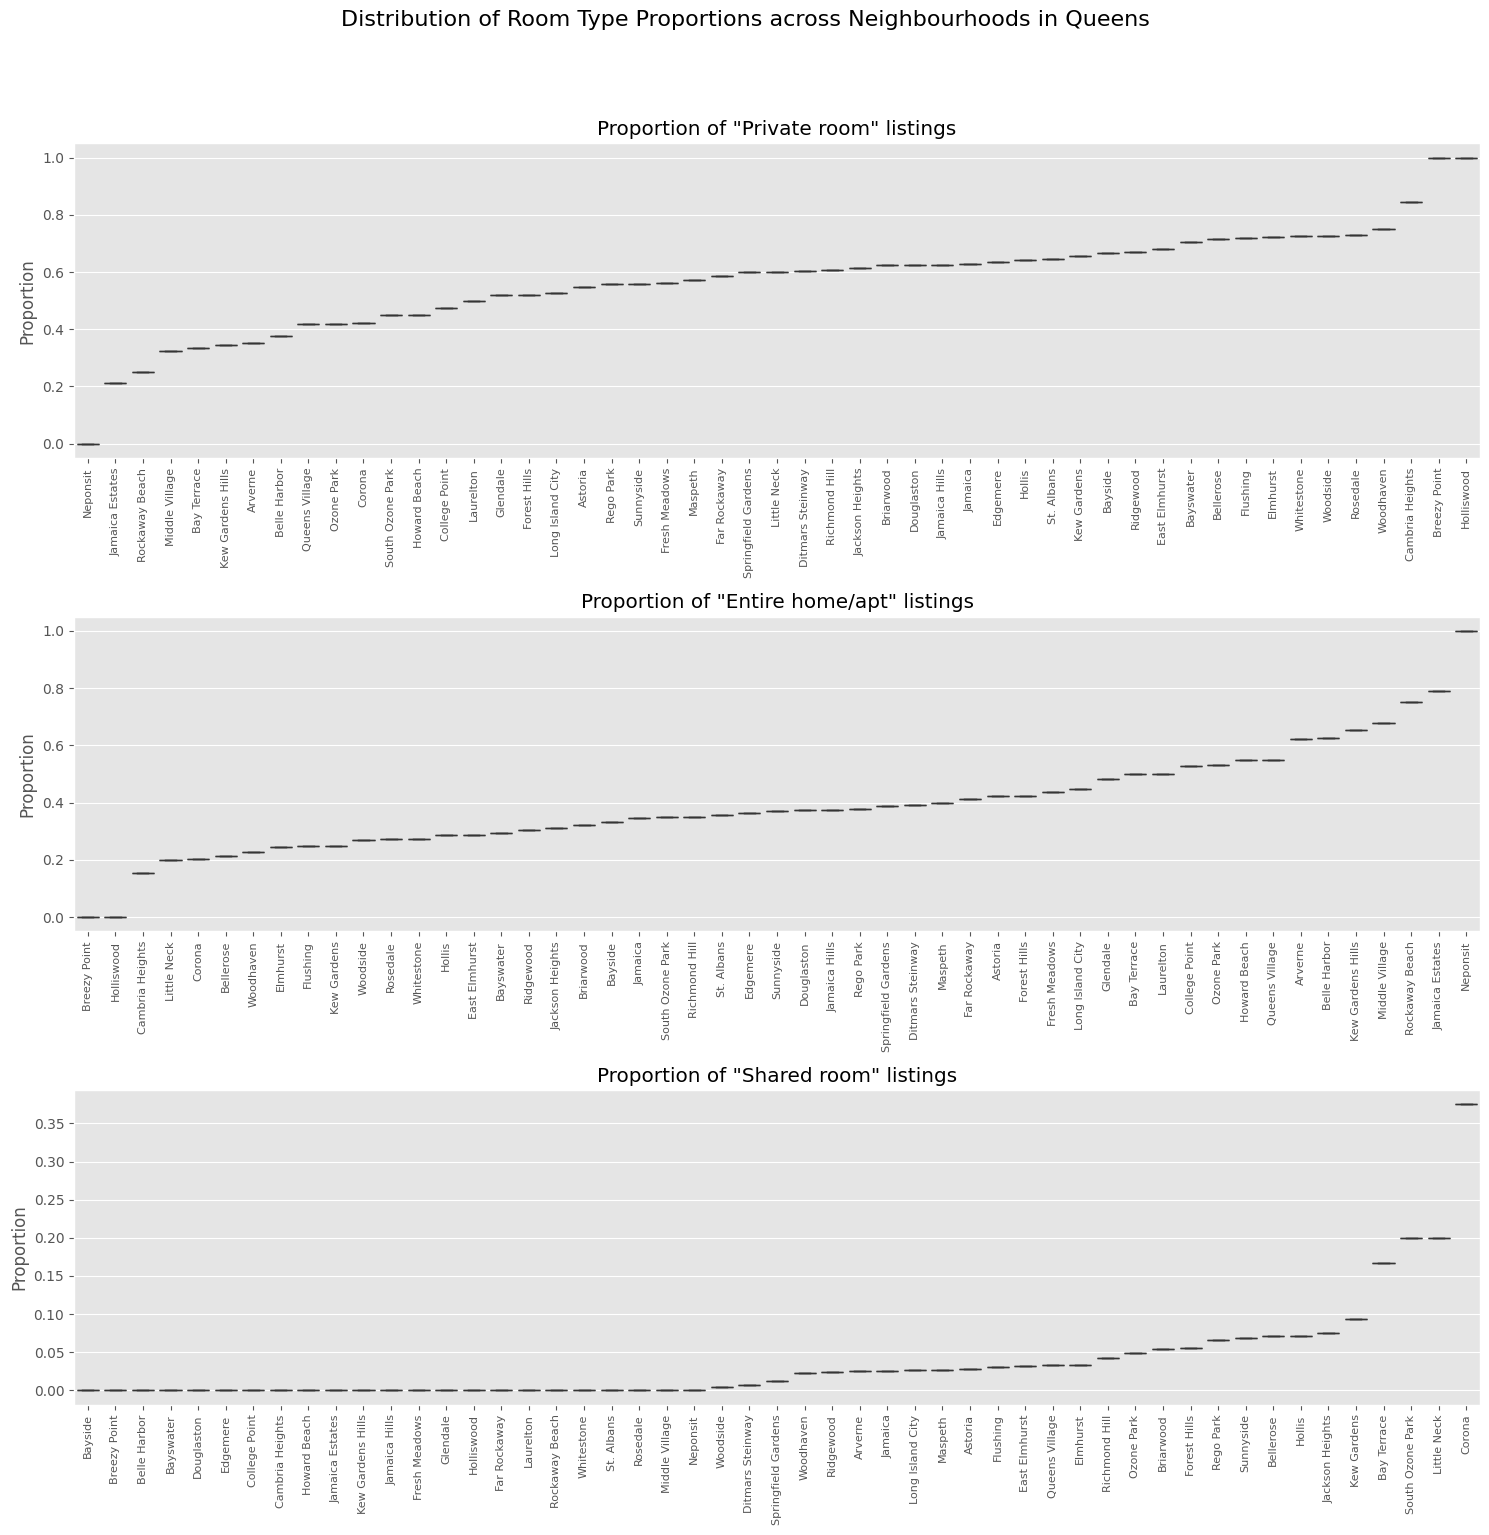

Summary of 'Entire home/apt' proportions in Queens (example):
room_type  Entire home/apt
count            51.000000
mean              0.392974
std               0.184681
min               0.000000
25%               0.279221
50%               0.371901
75%               0.490741
max               1.000000
--------------------------------------------------


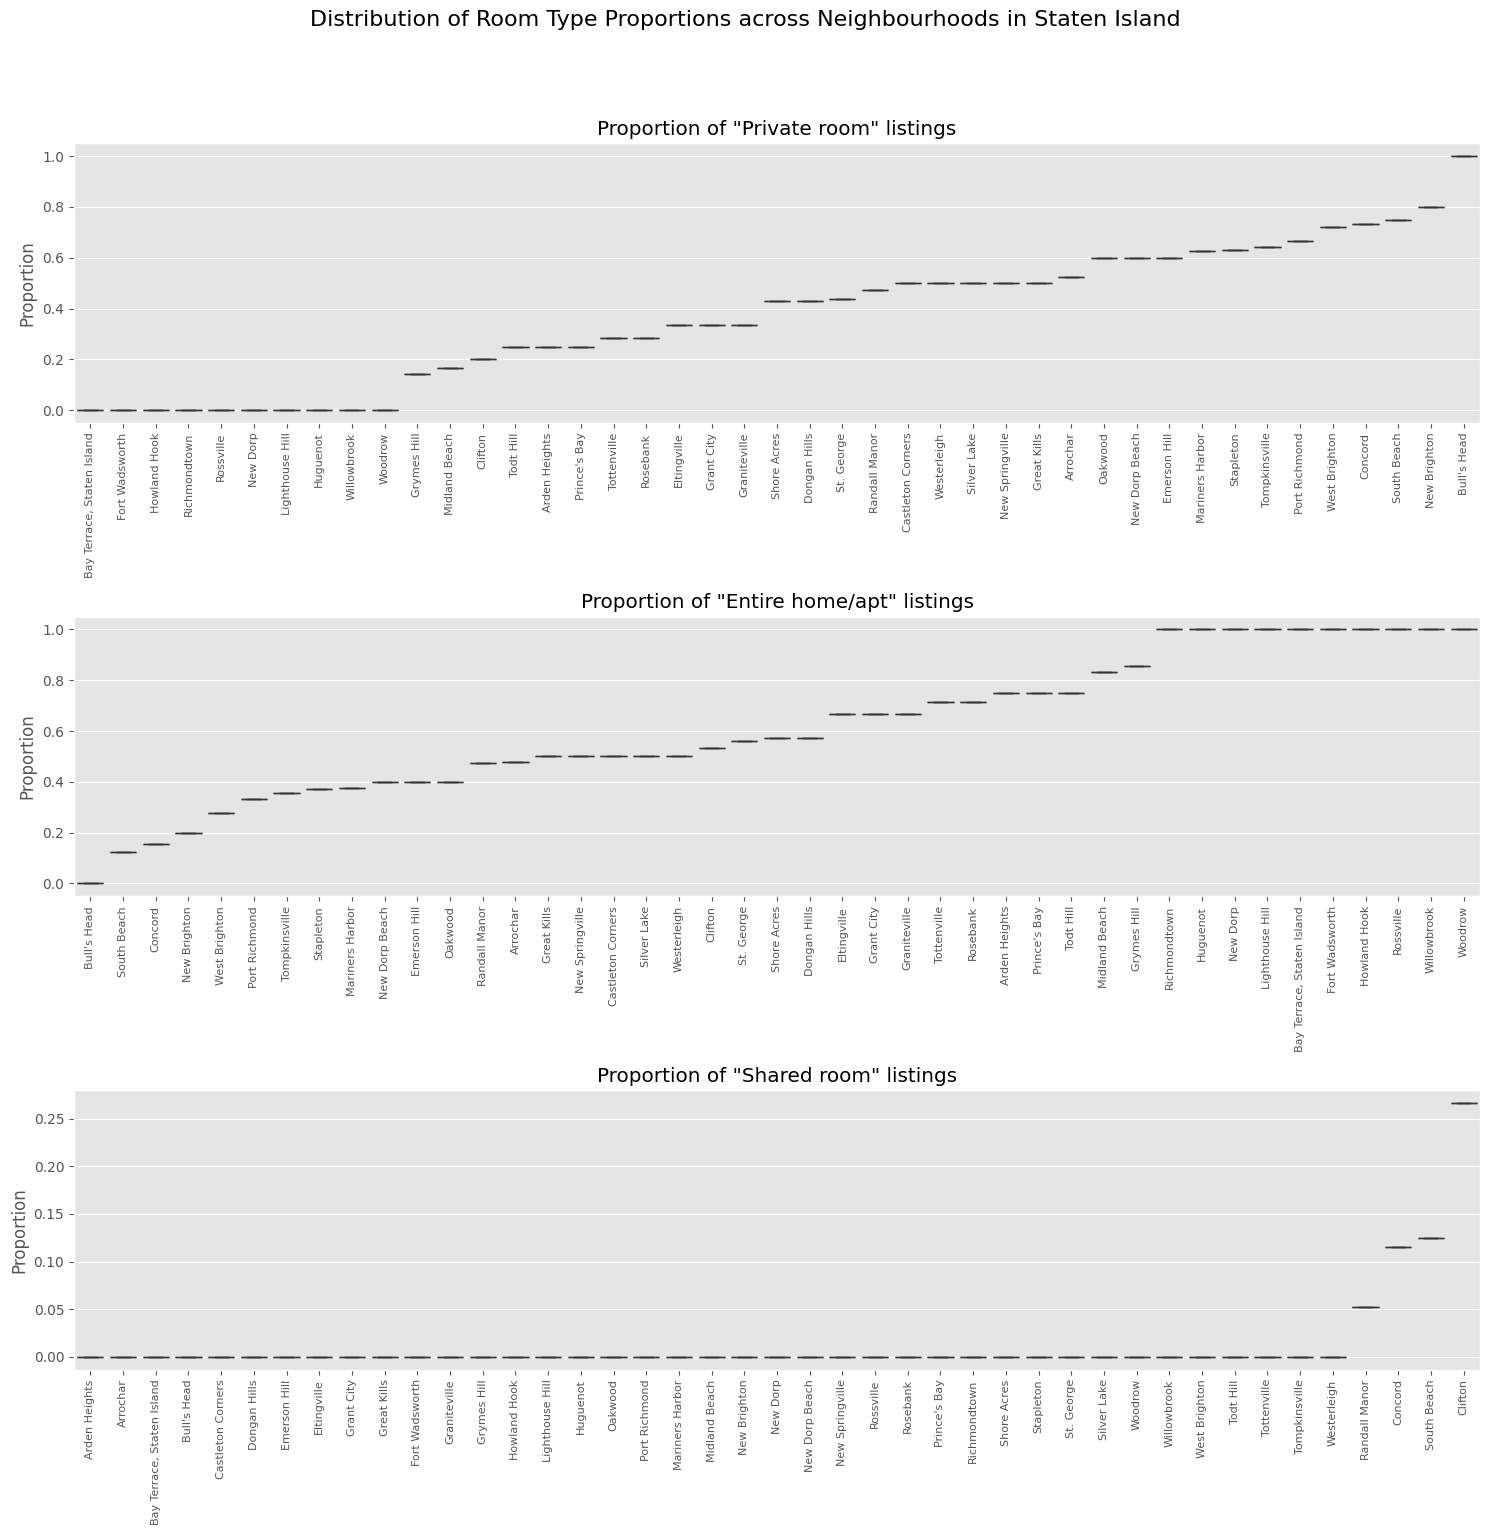

Summary of 'Entire home/apt' proportions in Staten Island (example):
room_type  Entire home/apt
count            43.000000
mean              0.615118
std               0.280663
min               0.000000
25%               0.400000
50%               0.571429
75%               0.845238
max               1.000000
--------------------------------------------------


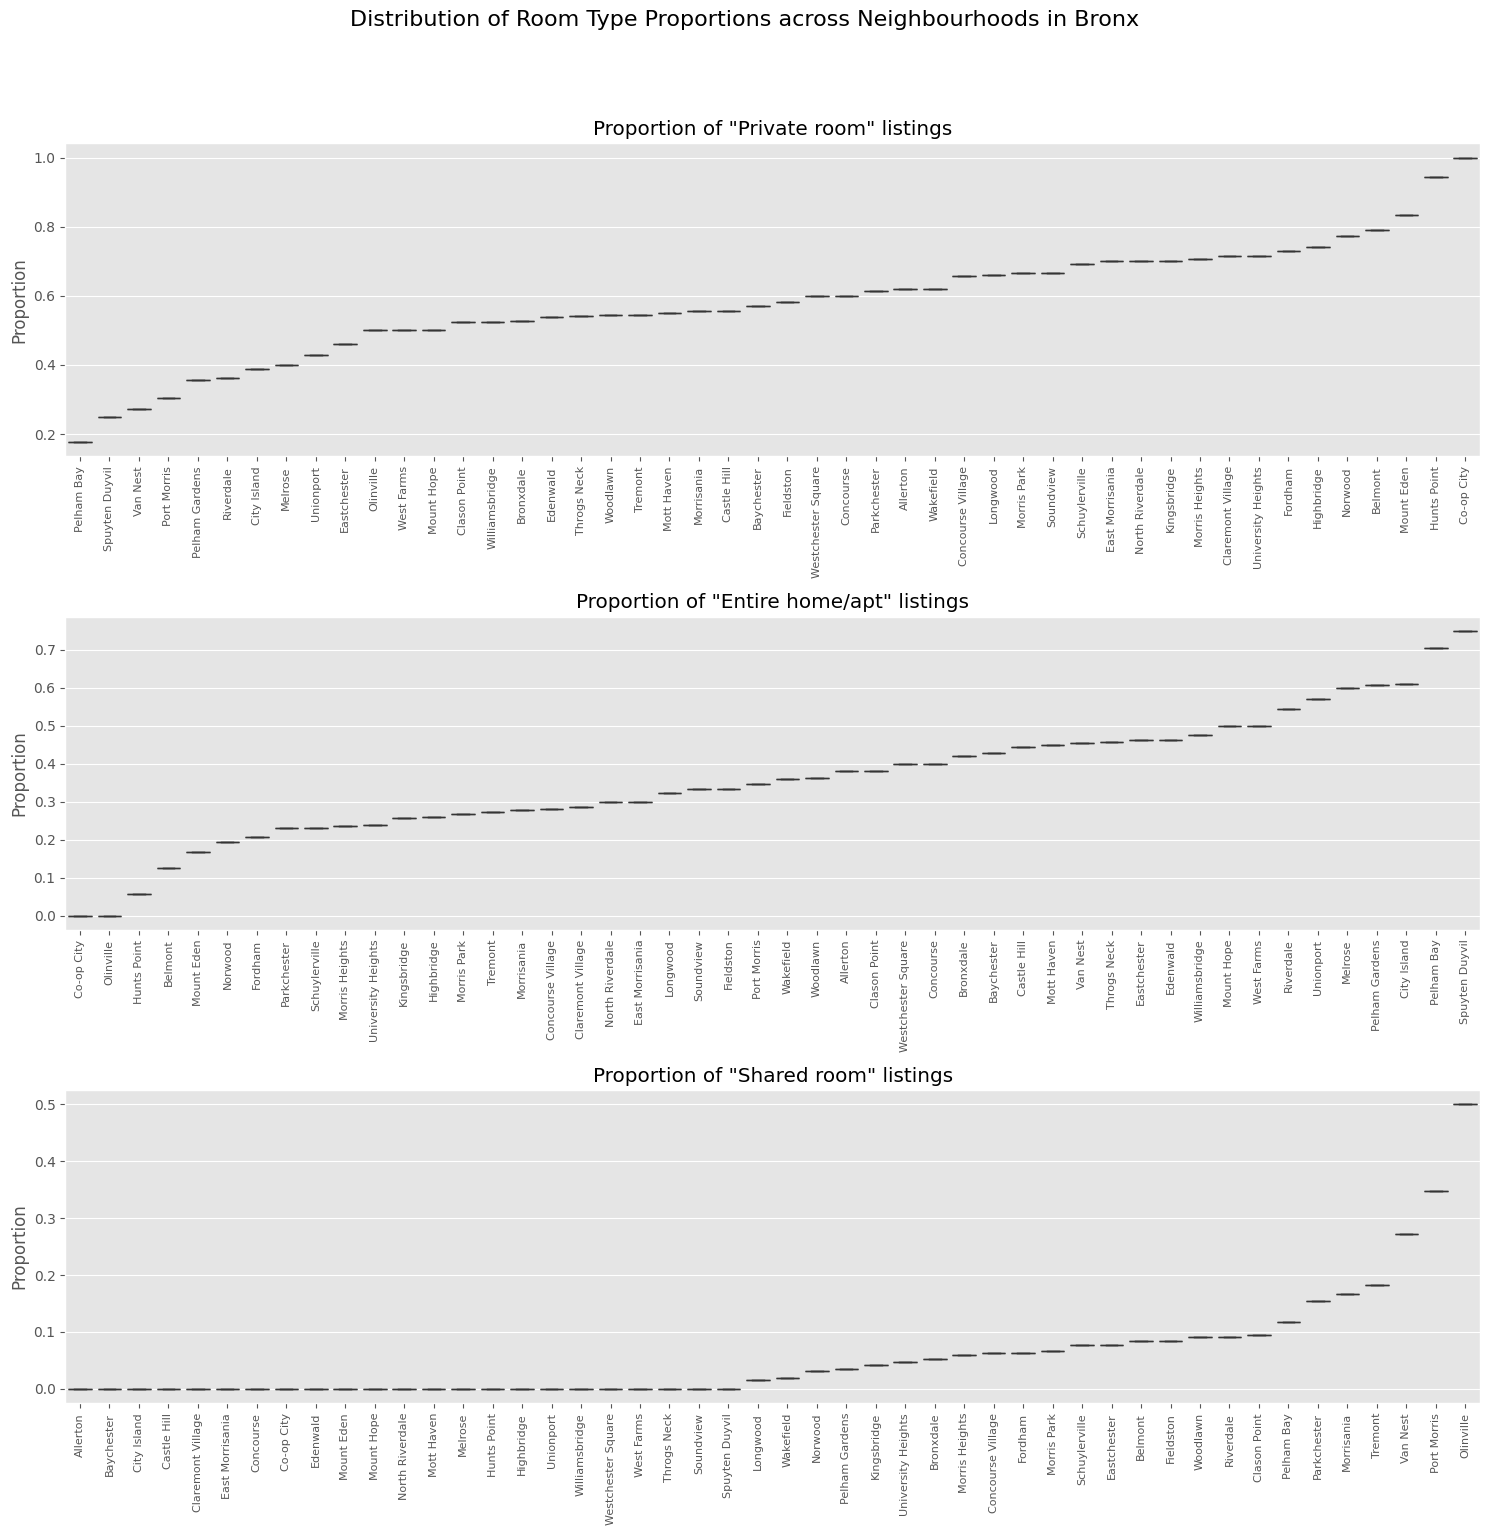

Summary of 'Entire home/apt' proportions in Bronx (example):
room_type  Entire home/apt
count            48.000000
mean              0.359401
std               0.164852
min               0.000000
25%               0.258730
50%               0.353913
75%               0.459135
max               0.750000
--------------------------------------------------


In [85]:
print("\n--- Intra-neighbourhood Variation: Listing Types (Room Type Proportions) ---")

# Calculate room type proportions for each neighbourhood
neighbourhood_room_counts = df.groupby(['neighbourhood_group', 'neighbourhood', 'room_type']).size().unstack(fill_value=0)
neighbourhood_room_proportions = neighbourhood_room_counts.apply(lambda x: x / x.sum() if x.sum() > 0 else x, axis=1).reset_index()

# Get the list of unique room types to plot
room_types_to_plot = df['room_type'].unique()

for group_name in df['neighbourhood_group'].unique():
    group_df_proportions = neighbourhood_room_proportions[neighbourhood_room_proportions['neighbourhood_group'] == group_name]
    
    if group_df_proportions.empty:
        print(f"No data for {group_name} to plot room type proportions.")
        continue
        
    fig, axes = plt.subplots(len(room_types_to_plot), 1, figsize=(15, 5 * len(room_types_to_plot)), sharex=False) # sharex=False might be better if neighborhood lists differ
    if len(room_types_to_plot) == 1: # handles case of single room type if dataset was filtered
        axes = [axes] 

    fig.suptitle(f'Distribution of Room Type Proportions across Neighbourhoods in {group_name}', fontsize=16, y=1.02)
    
    for i, room_type_col in enumerate(room_types_to_plot):
        if room_type_col in group_df_proportions.columns:

            ordered_hoods_rt = group_df_proportions.sort_values(by=room_type_col)['neighbourhood']

            sns.boxplot(ax=axes[i], x='neighbourhood', y=room_type_col, data=group_df_proportions, order=ordered_hoods_rt)
            axes[i].set_title(f'Proportion of "{room_type_col}" listings')
            axes[i].set_xlabel('') # Avoid repetitive x-labels
            axes[i].set_ylabel('Proportion')
            axes[i].tick_params(axis='x', rotation=90, labelsize=8)
        else:
            axes[i].set_title(f'No "{room_type_col}" listings found in proportions for this group.')
            axes[i].tick_params(axis='x', rotation=90, labelsize=8)


    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make room for suptitle
    plt.show()
    
    print(f"Summary of 'Entire home/apt' proportions in {group_name} (example):")
    if 'Entire home/apt' in group_df_proportions.columns:
        print(group_df_proportions[['neighbourhood', 'Entire home/apt']].describe())
    print("-" * 50)

#### Summary of `neighbourhood_group` and `neighbourhood` Characteristic Analysis

Our focused analysis on geographical characteristics provided critical context for our project:

* **Distinct `neighbourhood_group` Level Profiles:**
    * Our findings show each `neighbourhood_group` possesses a unique "fingerprint" based on typical Airbnb offerings.
        * **Price & Room Types:** We observed clear price hierarchies and dominant `room_type` patterns. For instance, 'Manhattan' stands out as the most expensive `neighbourhood_group` and is dominated by 'Entire home/apt' listings. In contrast, the 'Bronx' is the most affordable, primarily featuring 'Private room' listings. 'Brooklyn', 'Queens', and 'Staten Island' each present their own distinct combinations of price and common room types.
        * **Availability Patterns:** Median availability also varies; listings in 'Brooklyn' and 'Manhattan' tend to be less available than those in 'Queens' and the 'Bronx', with 'Staten Island' listings being the most available on average.
        * **Review Volume & Activity:** An interesting discovery was that typical listings (median) in 'Staten Island', followed by the 'Bronx' and 'Queens', actually showed higher `number_of_reviews` and `reviews_per_month` than the typical listings in the denser `neighbourhood_group`s of 'Manhattan' and 'Brooklyn'.

* **Significant Variation at the `neighbourhood` Level (Within `neighbourhood_group`s):**
    * A crucial insight from this phase was the substantial **heterogeneity among `neighbourhoods` even within the same `neighbourhood_group`**.
    * **Price Variation:** We saw considerable price differences between `neighbourhoods` of the same `neighbourhood_group`. For example, popular `neighbourhoods` in 'Manhattan' like Harlem and Midtown, while both "Manhattan," cater to very different price points.
    * **Room Type Mix Variation:** The proportion of `room_type`s is not uniform. Some `neighbourhoods` might align with their `neighbourhood_group`'s average, while others deviate significantly (e.g., some 'Manhattan' `neighbourhoods` having more 'Private rooms' than the 'Manhattan' average).
    * **Availability Variation:** Our visualizations also indicated that availability patterns can differ widely among `neighbourhoods` within a single `neighbourhood_group`.

* **Overall Implication for Our Project:**
    * This analysis strongly reinforces that while `neighbourhood_group` offers a useful high-level context (like general price tier or broad availability pressures), it's too coarse for defining "similarity" for recommendations.
    * To effectively identify "characteristically similar `neighbourhoods`," our approach must rely on **granular, `neighbourhood`-specific profiles.** These profiles will be built from the detailed features we've explored (price, room type mix, availability patterns, minimum stay requirements, host profiles), allowing us to capture the unique character of each `neighbourhood`.

## 5. Consolidated EDA Summary & Key Conclusions for Next Steps

Our comprehensive Exploratory Data Analysis (EDA) of the `AB_NYC_2019.csv` dataset has yielded a deep and nuanced understanding of its structure, key feature distributions, and the interrelationships relevant to our project goal: recommending similar, less busy `neighbourhoods`.

**Key Learnings from EDA:**

1.  **Data Quality & Preparation:**
    * We successfully loaded the dataset of 48,895 listings.
    * Missing values in `reviews_per_month` and `last_review` (10,052 each) were found to be systematically linked to listings with zero `number_of_reviews`. We imputed `reviews_per_month` with 0, while `last_review` NaNs were acknowledged as representing no review history. Minor missing `name` and `host_name` values were imputed with "Unknown."

2.  **Core Listing Characteristics Defining "Similarity":**
    * **Price:** We observed significant right-skewness (median $106, mean $153), making log transformation crucial for visualization. Price is strongly driven by `room_type` (e.g., 'Entire home/apt' median $160 vs. 'Private room' $70) and `neighbourhood_group` ('Manhattan' median $150 vs. 'Bronx' $65). Critically, substantial price variation also exists *within* `neighbourhood_group`s at the `neighbourhood` level (e.g., Midtown's $210 vs. Harlem's $89). Linear correlations between price and review counts/availability were found to be weak.
    * **Room Type:** The market is primarily 'Entire home/apt' (~52%) and 'Private room' (~46%). The specific mix of these `room_type`s varies considerably by `neighbourhood_group` (e.g., 'Manhattan' leans towards 'Entire home/apt', while 'Queens' and 'Bronx' favor 'Private room') and even more so among individual `neighbourhoods` within them.
    * **Minimum Nights:** This feature is also highly right-skewed (median 3 nights, 75% of listings ≤ 5 nights), indicating a focus on short stays. While median `minimum_nights` are consistently short (2-3 days) across all `neighbourhood_group`s, 'Manhattan' and 'Brooklyn' have higher means, suggesting a greater presence of listings with very long minimum stay requirements.
    * **Host Profile:** Our analysis showed the market is dominated by single-listing hosts (~66%) and small-scale hosts. However, a "long tail" of professional hosts managing many listings is also present. The type of host appears to vary by `room_type`, and we noted that listings from larger hosts might have more standardized pricing.

3.  **Understanding "Busyness" and Demand Indicators:**
    * **Availability (`availability_365`):** We found a large segment of listings with very low or zero availability (over 35% have 0 days). At the `neighbourhood_group` level, 'Brooklyn' and 'Manhattan' exhibit the lowest median availability.
    * **Review Activity (`reviews_per_month`):** Most listings show low review rates (median 0.37 after imputation). Interestingly, outer `neighbourhood_group`s ('Staten Island', 'Queens', 'Bronx') displayed higher average `reviews_per_month` per listing than the denser 'Manhattan' and 'Brooklyn'.
    * **Listing Density:** 'Manhattan' and 'Brooklyn' (and specific `neighbourhoods` within them) have the highest concentration of listings.
    * **Complexity of "Busyness":** A key finding was that aggregated neighborhood-level metrics for availability (inverse), review activity, and density showed only weak (and sometimes counterintuitive) linear correlations. This tells us that "busyness" is multi-faceted; these indicators capture different, largely independent aspects.

4.  **Geographical Variation (`neighbourhood_group` and `neighbourhood` levels):**
    * Each `neighbourhood_group` presents a unique profile regarding its typical price points, availability patterns, dominant room types, and review activity.
    * Crucially, our EDA confirmed substantial heterogeneity for all key metrics (price, room type mix, availability) among `neighbourhoods` *within* the same `neighbourhood_group`. No `neighbourhood_group` is internally uniform.

**Implications for Our Project & Next Steps:**

This EDA phase has been invaluable. We've established that:
* "Busyness" is not a monolithic concept. For our recommendation system, we will need to clearly define which aspect(s) of busyness (e.g., low availability, high density, high activity, or a combination) we are using to identify areas to potentially avoid or find alternatives to.
* The concept of "characteristic similarity" between `neighbourhoods` must be built upon rich, granular profiles for each individual `neighbourhood`. These profiles should incorporate aggregated data on price distributions, room type compositions, typical minimum stay requirements, and potentially host profiles.
* Relying solely on `neighbourhood_group` averages would be insufficient for our goal of finding genuinely "similar" alternative `neighbourhoods`.

Our next steps will involve using these insights for feature engineering (creating the neighborhood profiles) and then developing our K-Means clustering (for potential listing archetypes, if pursued, or neighborhood busyness types) and KNN model to recommend similar, less busy `neighbourhoods`.